
### Entrada
- x1: Local da Coleta em km
- x2: Nivel da Mare em m
- x3: Umidade do Ar (%)
- x4: Índice Pluvimétrico (mm)¹
- x5: Temperatura (°C)

### Saida
- y1: pH
- y2: Condutividade Elétrica (mS.cmˉ¹)
- y3: Oxigênio Dissolvido (mg.Lˉ¹)
- y4: Sólidos Totais Dissolvidos (ppm)


In [1]:
!pip install --upgrade pip
!pip install tensorflow 
!pip install openpyxl

In [2]:
import os

os.chdir("./content")

lm_dir = "tf-levenberg-marquardt"
if not os.path.exists(lm_dir):
  !git clone https://github.com/fabiodimarco/$lm_dir

os.chdir(lm_dir)

/tmp/ipykernel_49985/3046165550.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


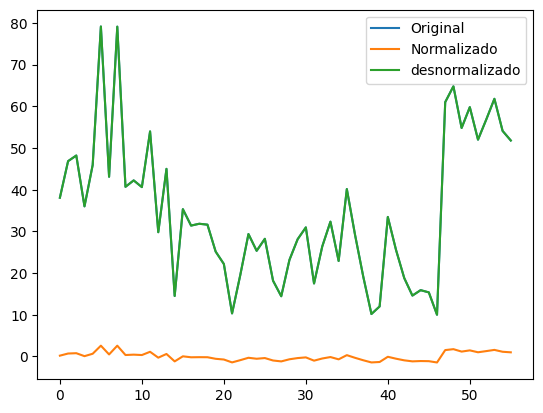

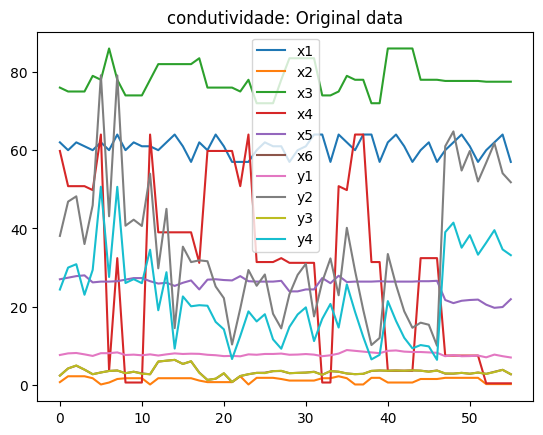

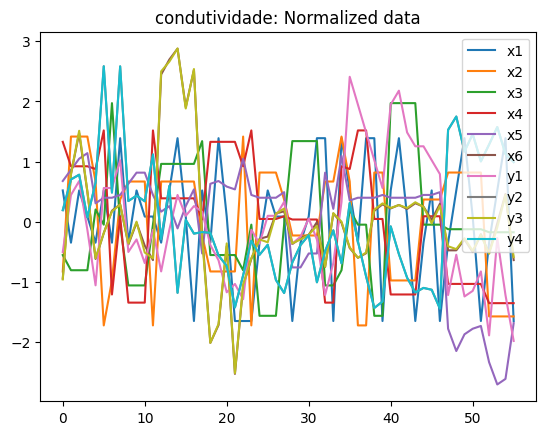

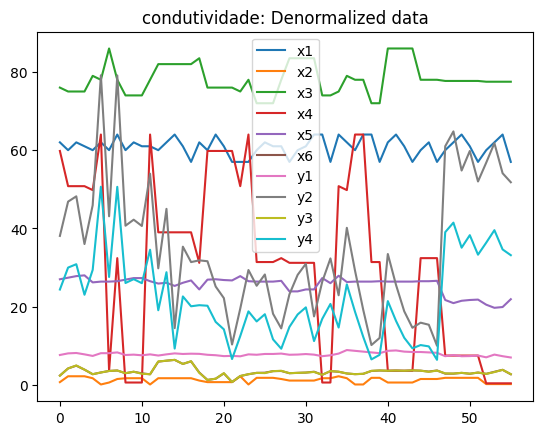

In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
out_scaler = StandardScaler()

def getData():
    df_orig = pd.read_excel("../../../data.xlsx")    
    df = pd.DataFrame(scaler.fit_transform(df_orig), columns=df_orig.columns)
    df_denorm = pd.DataFrame(scaler.inverse_transform(df), columns=df.columns)
    return (df_orig, df, df_denorm)

def create_dataframe(df, output):
    x1, x2, x3, x4, x5, x6  = df['x1'], df['x2'], df['x3'], df['x4'], df['x5'], df['x6']

    input = np.vstack([x1, x2, x3, x4, x5, x6 ]).T
    output = np.array(df[output])
    scaler.fit(output.reshape(-1, 1))
    return output, input

def test_out_scaler():
    out = df_orig["y2"].values.reshape(-1, 1)  
    plt.plot(out, label='Original')
    out_scaler.fit(out)
    norm = out_scaler.transform(out)
    plt.plot(norm, label='Normalizado')
    plt.plot(out_scaler.inverse_transform(norm), label='desnormalizado')
    plt.legend()
    plt.show()

def show_norm(label):
    df_orig.plot(title=f"{label}: Original data")
    df.plot(title=f"{label}: Normalized data")
    df_denorm.plot(title=f"{label}: Denormalized data")

df_orig, df, df_denorm = getData()
output, input = create_dataframe(df, output="y2")
test_out_scaler()
show_norm(label="condutividade")


In [4]:
import tensorflow as tf
import numpy as np
from keras import regularizers
from keras import initializers
import levenberg_marquardt as lm

# layers, neurons
class ShuffleArchitecture:
    def __init__(self, input_size, hidden_sizes, output_size, act_h, act_o, param_reg):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.act_h = act_h
        self.act_o = act_o
        self.regularizer = regularizers.L2(param_reg)
        self.initializer = initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=np.random.randint(1, 10000))

    def set_architecture(self):
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(self.hidden_sizes[0],
                        input_shape=(self.input_size,),
                        activation=self.act_h,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,                        
                        ))  # input layer
        
        for size in self.hidden_sizes[1:]:  # hidden layers
            self.model.add(tf.keras.layers.Dense(size,
                            activation=self.act_h,
                            kernel_regularizer=self.regularizer,
                            kernel_initializer=self.initializer,  
                        ))

        self.model.add(tf.keras.layers.Dense(self.output_size,
                        activation=self.act_o,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,  
                        ))  # output layer

    def create_model(self, _learning_rate):
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
            loss=tf.keras.losses.MeanSquaredError())

        self.lm_model = lm.ModelWrapper(
            tf.keras.models.clone_model(self.model))

        self.lm_model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=_learning_rate),
            loss=lm.MeanSquaredError())
        return(self.lm_model)

2024-05-26 19:59:38.814546: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-26 19:59:38.848150: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-26 19:59:38.848183: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-26 19:59:38.849310: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-26 19:59:38.855043: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-26 19:59:38.855960: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [5]:
import tensorflow as tf
import time
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error

class TrainWithSmallDataset:
    def __init__(self, batch_size=1000):
        self.batch_size = batch_size
        self.betters = []
    
    def create_dataset(self, input, output):
      input = tf.expand_dims(tf.cast(input, tf.float32), axis=-1)
      output = tf.expand_dims(tf.cast(output, tf.float32), axis=-1)

      dataset = tf.data.Dataset.from_tensor_slices((input, output))
      dataset = dataset.shuffle(len(input))
      dataset = dataset.batch(self.batch_size).cache()
      dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
      return (dataset, input, output)

    def split_dataset(self, input, output):
      input_train, input_vt, output_train, output_vt = train_test_split(input, output, test_size=0.3, shuffle = True)
      input_val, input_test, output_val, output_test = train_test_split(input_vt, output_vt, test_size=0.5, shuffle = True)

      self.train_dataset, self.train_input, self.train_output = self.create_dataset(input_train, output_train)
      self.val_dataset, self.val_input, self.val_output = self.create_dataset(input_val, output_val)
      self.test_dataset, self.test_input, self.test_output = self.create_dataset(input_test, output_test)
      self.vt_dataset, self.vt_input, self.vt_output = self.create_dataset(input_vt, output_vt)
      self.dataset, self.input, self.output = self.create_dataset(input, output)

      self._data = (input, output)
      self._train = (input_train, output_train)
      self._vt = (input_vt, output_vt)
      self._val = (input_val, output_val)
      self._test = (input_test, output_test)
    
    def train_using_lm(self, train_dataset, epochs=1000):
      early_stopping_monitor = EarlyStopping(monitor='val_loss',
                                              patience=6,
                                              restore_best_weights=True)

      t2_start = time.perf_counter()
      self.results = self.lm_model.fit(train_dataset,
                                            epochs=epochs,
                                            validation_data=self.val_dataset,
                                            callbacks=[early_stopping_monitor],
                                            verbose=0)
      t2_stop = time.perf_counter()
      print("Elapsed time: ", t2_stop - t2_start)
      print ("Stopped at epoch: ", early_stopping_monitor.stopped_epoch)

    def get_metrics(self):
    # Calculando a saida com os dados normalizados
      pred = self.lm_model.predict(self.input).flatten()
      test_pred = self.lm_model.predict(self.test_input).flatten()
      val_pred = self.lm_model.predict(self.val_input).flatten()
      vt_pred = self.lm_model.predict(self.vt_input).flatten()
  
    # Calculando as metricas com a saida desnormalizada
      self.pred_denorm = out_scaler.inverse_transform(pred.reshape(-1, 1))
      test_pred_denorm = out_scaler.inverse_transform(test_pred.reshape(-1, 1))
      val_pred_denorm = out_scaler.inverse_transform(val_pred.reshape(-1, 1))
      vt_pred_denorm = out_scaler.inverse_transform(vt_pred.reshape(-1, 1))

      self.out_denorm = out_scaler.inverse_transform(self._data[1].reshape(-1, 1))
      test_denorm = out_scaler.inverse_transform(self._test[1].reshape(-1, 1))
      val_denorm = out_scaler.inverse_transform(self._val[1].reshape(-1, 1))
      vt_denorm = out_scaler.inverse_transform(self._vt[1].reshape(-1, 1))      

      r2 = r2_score(self.out_denorm, self.pred_denorm)
      r2_test = r2_score(test_denorm, test_pred_denorm)
      r2_val = r2_score(val_denorm, val_pred_denorm)
      r2_vt = r2_score(vt_denorm,  vt_pred_denorm)

      mse = mean_squared_error(self.out_denorm, self.pred_denorm)
      mse_test = mean_squared_error(test_denorm, test_pred_denorm)
      mse_val = mean_squared_error(val_denorm, val_pred_denorm)
      mse_vt = mean_squared_error(vt_denorm,  vt_pred_denorm)

      metrics = {
                      'r2': r2,
                      'r2_test': r2_test,
                      'r2_val': r2_val,
                      'r2_vt': r2_vt,
                      'mse': mse,
                      'mse_test': mse_test,
                      'mse_val': mse_val,
                      'mse_vt': mse_vt
                      }

      return metrics

In [6]:
from itertools import product
import pickle

class Tester:
  def __init__(self, input, output, run_times=500, dataset_run_times=10):
    self.run_times = run_times
    self.better_metrics = {}
    self.dataset_run_times = dataset_run_times
    self.input, self.output = input, output
  
  def setArchitecure(self, trainer, _hidden_sizes, _pg, _lr):
    shuffler = ShuffleArchitecture(input_size=6,
                                    hidden_sizes=_hidden_sizes,
                                    output_size=1,
                                    act_h='tanh',
                                    act_o='linear',
                                    param_reg=_pg)
    shuffler.set_architecture()    
    trainer.lm_model = shuffler.create_model(_lr)

  def Train(self, trainer, epochs=1000):
    trainer.train_using_lm(trainer.train_dataset, epochs=epochs)
    return(trainer.get_metrics(), trainer.lm_model)

  def SaveModelWeights(self, model, fileName):
    path = f"../models/{fileName}.keras"
    open(path,'w').close()
    model.save_weights(path) 

  def SaveDataset(self, trainer, fileName):
    path = f"../dataset/{fileName}.pkl" 
    with open(path, 'wb') as f:
      pickle.dump((trainer._data, trainer._train, trainer._vt, trainer._val, trainer._test), f)

  def LoopWeights(self, sort_by, boundarie, trainer, idx):
    better_model = 0
    save = False

    for i in range(self.run_times):
      print (f"+++++++++++ [{idx}] | {i + 1} ++++++++++++++++++")
      metrics, model = self.Train(trainer)
      if (metrics[sort_by] >= boundarie): # should be <= to descending metrics
        fileName = f"model_{idx}_{better_model}"
        self.SaveModelWeights(model, fileName)
        self.better_metrics[fileName] = metrics
        better_model += 1
        save = True
    
    return(save)

# Init
  def Loop(self, sort_by, boundarie, hidden_sizes, regularizers, learning_rate):
    trainer = TrainWithSmallDataset()

    for count, (hidden_size, reg, lr) in enumerate(product(hidden_sizes, regularizers, learning_rate), start=1):
      header =  f"Hidden Size={hidden_size}, regularizer={reg}, learning_rate={lr}"
      print(f"Testando combinação {count}: {header}")
      self.setArchitecure(trainer, hidden_size, reg, lr)
      for j in range(self.dataset_run_times):
        trainer.split_dataset(self.input, self.output)
        if (self.LoopWeights(sort_by, boundarie, trainer, f"{count}_{j}") == True):
          self.SaveDataset(trainer, f"dataset_{count}_{j}")
          self.DisplayBetterResults(sort_by, header, f"{count}_{j}")
        self.better_metrics = {}

  def DisplayBetterResults(self, sort_by, header, dataset=0):
    df = pd.DataFrame.from_dict(self.better_metrics, orient='index')
    df = df.sort_values([sort_by])
    display(df)
    path = f'../results/metrics_{dataset}'
    df.to_excel(f"{path}.xlsx", index=True)
    print(f"DataFrame salvo em {path}")
    with open(f"{path}.txt", 'w') as arquivo:
      arquivo.write(header)

In [7]:
tester = Tester(input, output, run_times=25, dataset_run_times=10)

In [8]:
tester.Loop(sort_by='r2',
            boundarie=0.8,
            hidden_sizes = [[30], [25], [20], [25, 15], [20, 10], [35], [10, 5], [30, 15]],
            regularizers=[0.01, 0.1],
            learning_rate=[0.1])

Testando combinação 1: Hidden Size=[30], regularizer=0.01, learning_rate=0.1
+++++++++++ [1_0] | 1 ++++++++++++++++++
Elapsed time:  0.9642110240001784
Stopped at epoch:  17
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_0] | 2 ++++++++++++++++++
Elapsed time:  0.15902839000045788
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_0] | 3 ++++++++++++++++++
Elapsed time:  0.2668875729996216
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [1_0] | 4 ++++++++++++++++++
Elapsed time:  0.14313064300040423
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_0] | 5 ++++++++++++++++++
Elapsed time:  0.14351554000040778
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [1_0] | 6 ++++++++++++++++++
Elapsed time:  0.21518463199936377
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_0] | 7 ++++++++

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_1_2_13,0.805367,0.666992,0.328697,0.521989,57.306510,105.188292,274.634386,184.927618
model_1_2_0,0.806773,0.790444,0.514479,0.667804,56.892787,66.193065,198.629794,128.516222
model_1_2_12,0.807139,0.672075,0.337878,0.528755,56.784968,103.582634,270.878428,182.310048
model_1_2_11,0.808950,0.677700,0.347882,0.536165,56.251564,101.805870,266.785603,179.443397
model_1_2_10,0.810770,0.683919,0.358757,0.544265,55.715751,99.841415,262.336720,176.309789
model_1_2_1,0.812145,0.775661,0.496458,0.652446,55.311027,70.862583,206.002359,134.457785
model_1_2_9,0.812553,0.690788,0.370541,0.553098,55.190740,97.671689,257.515865,172.892454
model_1_2_8,0.814239,0.698364,0.383266,0.562705,54.694404,95.278734,252.310035,169.175846
model_1_2_2,0.815488,0.761772,0.478425,0.637469,54.326762,75.249959,213.379620,140.252145
model_1_2_7,0.815746,0.706706,0.396946,0.573119,54.250624,92.643722,246.713079,165.146978


DataFrame salvo em ../results/metrics_1_2
+++++++++++ [1_3] | 1 ++++++++++++++++++
Elapsed time:  0.2466668529996241
Stopped at epoch:  10
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_3] | 2 ++++++++++++++++++
Elapsed time:  0.1793249160000414
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [1_3] | 3 ++++++++++++++++++
Elapsed time:  0.17244712299998355
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_3] | 4 ++++++++++++++++++
Elapsed time:  0.20205350799915323
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_3] | 5 ++++++++++++++++++
Elapsed time:  0.21781057399948622
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_3] | 6 ++++++++++++++++++
Elapsed time:  0.16470809500060568
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [1_3] | 7 ++++++++++++++++++
Elapsed time:  0.2302352

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_1_3_24,0.865234,0.490667,0.670934,0.549299,39.679683,190.092347,63.414028,130.479016
model_1_3_23,0.865958,0.493857,0.672320,0.551910,39.466627,188.902014,63.146907,129.723137
model_1_3_22,0.866747,0.497371,0.673841,0.554785,39.234226,187.590462,62.853790,128.890857
model_1_3_21,0.867606,0.501239,0.675507,0.557947,38.981329,186.146805,62.532703,127.975432
model_1_3_20,0.868538,0.505492,0.677331,0.561421,38.706912,184.559569,62.181324,126.969810
model_1_3_19,0.869546,0.510162,0.679321,0.565231,38.410131,182.816715,61.797882,125.866703
model_1_3_18,0.870632,0.515281,0.681488,0.569405,38.090367,180.905940,61.380135,124.658482
model_1_3_17,0.871797,0.520885,0.683844,0.573967,37.747429,178.814522,60.926187,123.337640
model_1_3_16,0.873039,0.527007,0.686397,0.578945,37.381580,176.529802,60.434125,121.896543
model_1_3_15,0.874356,0.533680,0.689155,0.584363,36.993792,174.039336,59.902606,120.327918


DataFrame salvo em ../results/metrics_1_3
+++++++++++ [1_4] | 1 ++++++++++++++++++
Elapsed time:  0.16817699999955948
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [1_4] | 2 ++++++++++++++++++
Elapsed time:  0.2074009259995364
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [1_4] | 3 ++++++++++++++++++
Elapsed time:  0.18028089699964767
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_4] | 4 ++++++++++++++++++
Elapsed time:  0.2226527109996823
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_4] | 5 ++++++++++++++++++
Elapsed time:  0.2144102149995888
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_4] | 6 ++++++++++++++++++
Elapsed time:  0.19573897900045267
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_4] | 7 ++++++++++++++++++
Elapsed time:  0.256312071

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_1_4_0,0.887779,0.930038,0.975764,0.968589,33.041706,11.496178,1.989561,7.022476
model_1_4_24,0.902891,0.264460,0.235391,0.581668,28.592334,120.864956,62.766418,93.524465
model_1_4_1,0.904025,0.899451,0.961943,0.954298,28.258464,16.522437,3.124117,10.217347
model_1_4_23,0.904303,0.274974,0.251203,0.588491,28.176415,119.137287,61.468441,91.999032
model_1_4_22,0.905830,0.286488,0.268568,0.595972,27.726933,117.245400,60.042953,90.326586
model_1_4_21,0.907473,0.299076,0.287613,0.604161,27.243056,115.176929,58.479526,88.495828
model_1_4_20,0.909234,0.312816,0.308458,0.613109,26.724495,112.919123,56.768389,86.495227
model_1_4_19,0.911112,0.327787,0.331219,0.622868,26.171799,110.459041,54.899923,84.313539
model_1_4_18,0.913100,0.344071,0.356008,0.633488,25.586395,107.783164,52.865045,81.939342
model_1_4_17,0.915189,0.361747,0.382913,0.645015,24.971183,104.878672,50.656406,79.362318


DataFrame salvo em ../results/metrics_1_4
+++++++++++ [1_5] | 1 ++++++++++++++++++
Elapsed time:  0.21025704699968628
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [1_5] | 2 ++++++++++++++++++
Elapsed time:  0.1829810039998847
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [1_5] | 3 ++++++++++++++++++
Elapsed time:  0.24656471999969654
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_5] | 4 ++++++++++++++++++
Elapsed time:  0.2749039840000478
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [1_5] | 5 ++++++++++++++++++
Elapsed time:  0.18017409100048098
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [1_5] | 6 ++++++++++++++++++
Elapsed time:  0.2543883349999305
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_5] | 7 ++++++++++++++++++
Elapsed time:  0.174872735

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_1_5_24,0.904992,0.636724,0.548851,0.598353,27.973535,71.991899,113.952478,91.738067
model_1_5_23,0.906000,0.638439,0.556365,0.603052,27.676971,71.651945,112.054492,90.664919
model_1_5_22,0.907105,0.640365,0.564690,0.608268,27.351331,71.270296,109.951930,89.473416
model_1_5_21,0.908318,0.642530,0.573906,0.614059,26.994342,70.841177,107.623982,88.150745
model_1_5_20,0.909645,0.644969,0.584102,0.620486,26.603746,70.357913,105.048603,86.682952
model_1_5_19,0.911093,0.647719,0.595372,0.627614,26.177380,69.812800,102.202022,85.054791
model_1_5_18,0.912669,0.650829,0.607816,0.635518,25.713147,69.196589,99.058861,83.249411
model_1_5_17,0.914380,0.654353,0.621532,0.644274,25.209538,68.498212,95.594662,81.249477
model_1_5_0,0.916195,0.863597,0.978911,0.926370,24.675131,27.031453,5.326660,16.817429
model_1_5_16,0.916228,0.658356,0.636621,0.653966,24.665377,67.704828,91.783373,79.035914


DataFrame salvo em ../results/metrics_1_5
+++++++++++ [1_6] | 1 ++++++++++++++++++
Elapsed time:  0.18839044800006377
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [1_6] | 2 ++++++++++++++++++
Elapsed time:  0.262237167999956
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [1_6] | 3 ++++++++++++++++++
Elapsed time:  0.2604271520003749
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [1_6] | 4 ++++++++++++++++++
Elapsed time:  0.2622781660002147
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_6] | 5 ++++++++++++++++++
Elapsed time:  0.23633021699970413
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_6] | 6 ++++++++++++++++++
Elapsed time:  0.22890722699958133
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [1_6] | 7 ++++++++++++++++++
Elapsed time:  0.2555053650

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_1_6_0,0.918732,0.914317,0.957295,0.925839,23.927957,39.320153,7.688530,24.434683
model_1_6_1,0.929537,0.915842,0.954277,0.926187,20.746710,38.620400,8.231842,24.319902
model_1_6_2,0.937998,0.916398,0.950630,0.925659,18.255395,38.365484,8.888540,24.493992
model_1_6_3,0.944590,0.916192,0.946650,0.924484,16.314654,38.459602,9.605061,24.880991
model_1_6_4,0.949691,0.915411,0.942523,0.922847,14.812652,38.818077,10.348043,25.420409
model_1_6_5,0.953607,0.914210,0.938367,0.920892,13.659682,39.369583,11.096224,26.064468
model_1_6_6,0.956582,0.912714,0.934262,0.918734,12.783687,40.055762,11.835430,26.775597
model_1_6_7,0.958813,0.911026,0.930261,0.916460,12.126878,40.830620,12.555728,27.524787
model_1_6_8,0.960457,0.909223,0.926403,0.914139,11.642850,41.657733,13.250282,28.289527
model_1_6_9,0.961640,0.907368,0.922714,0.911823,11.294445,42.509010,13.914438,29.052757


DataFrame salvo em ../results/metrics_1_6
+++++++++++ [1_7] | 1 ++++++++++++++++++
Elapsed time:  0.2901678929993068
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [1_7] | 2 ++++++++++++++++++
Elapsed time:  0.310509204000482
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [1_7] | 3 ++++++++++++++++++
Elapsed time:  0.1859546389996467
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [1_7] | 4 ++++++++++++++++++
Elapsed time:  0.19272584800000914
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_7] | 5 ++++++++++++++++++
Elapsed time:  0.20049045300038415
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [1_7] | 6 ++++++++++++++++++
Elapsed time:  0.1696134539997729
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_7] | 7 ++++++++++++++++++
Elapsed time:  0.21328791299

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_1_7_24,0.931310,0.876856,-1.399544,0.667153,20.224655,30.532837,107.023792,66.528592
model_1_7_23,0.931939,0.878694,-1.380924,0.670315,20.039472,30.077246,106.193315,65.896559
model_1_7_22,0.932631,0.880714,-1.360306,0.673806,19.835865,29.576444,105.273695,65.198668
model_1_7_21,0.933390,0.882932,-1.337483,0.677660,19.612244,29.026424,104.255774,64.428466
model_1_7_20,0.934223,0.885364,-1.312241,0.681907,19.367094,28.423508,103.129905,63.579456
model_1_7_19,0.935134,0.888025,-1.284331,0.686586,19.098763,27.763721,101.885070,62.644353
model_1_7_18,0.936130,0.890932,-1.253493,0.691733,18.805609,27.042845,100.509660,61.615450
model_1_7_17,0.937215,0.894101,-1.219445,0.697390,18.486103,26.257245,98.991063,60.484889
model_1_7_16,0.938395,0.897546,-1.181887,0.703596,18.138766,25.402898,97.315895,59.244301
model_1_7_15,0.939673,0.901281,-1.140490,0.710396,17.762326,24.476842,95.469545,57.885187


DataFrame salvo em ../results/metrics_1_7
+++++++++++ [1_8] | 1 ++++++++++++++++++
Elapsed time:  0.3261137890003738
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_8] | 2 ++++++++++++++++++
Elapsed time:  0.2747900390004361
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [1_8] | 3 ++++++++++++++++++
Elapsed time:  0.28861225099990406
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [1_8] | 4 ++++++++++++++++++
Elapsed time:  0.3303045809998366
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [1_8] | 5 ++++++++++++++++++
Elapsed time:  0.3207525820007504
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [1_8] | 6 ++++++++++++++++++
Elapsed time:  0.3673234460002277
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [1_8] | 7 ++++++++++++++++++
Elapsed time:  0.36351014000

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_1_8_0,0.937106,0.769426,0.990053,0.881041,18.518090,73.162441,2.857315,40.077674
model_1_8_1,0.941651,0.772400,0.989587,0.882337,17.179866,72.218748,2.990954,39.640963
model_1_8_2,0.945206,0.774815,0.988285,0.883019,16.133332,71.452593,3.364991,39.411367
model_1_8_3,0.947975,0.776824,0.986375,0.883254,15.317842,70.815114,3.913676,39.332087
model_1_8_4,0.950124,0.778534,0.984040,0.883170,14.685253,70.272533,4.584488,39.360516
model_1_8_5,0.951781,0.780017,0.981424,0.882860,14.197422,69.801959,5.335665,39.464870
model_1_8_6,0.953049,0.781323,0.978644,0.882396,13.823971,69.387404,6.134250,39.621213
model_1_8_7,0.954011,0.782486,0.975788,0.881830,13.540830,69.018351,6.954552,39.811854
model_1_8_8,0.954731,0.783531,0.972926,0.881202,13.328768,68.686972,7.776871,40.023400
model_1_8_9,0.955262,0.784473,0.970108,0.880542,13.172490,68.387849,8.586293,40.245937


DataFrame salvo em ../results/metrics_1_8
+++++++++++ [1_9] | 1 ++++++++++++++++++
Elapsed time:  0.31826376800017897
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [1_9] | 2 ++++++++++++++++++
Elapsed time:  0.2823852689998603
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [1_9] | 3 ++++++++++++++++++
Elapsed time:  0.3281487459998971
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [1_9] | 4 ++++++++++++++++++
Elapsed time:  0.4187585100007709
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [1_9] | 5 ++++++++++++++++++
Elapsed time:  0.2958120399998734
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [1_9] | 6 ++++++++++++++++++
Elapsed time:  0.23480336800002988
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [1_9] | 7 ++++++++++++++++++
Elapsed time:  0.2942141349

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_1_9_0,0.959758,0.996942,-0.033907,0.924040,11.848772,1.532817,46.770833,22.821296
model_1_9_1,0.962870,0.996790,-0.035411,0.923799,10.932475,1.609339,46.838876,22.893823
model_1_9_2,0.965314,0.996599,-0.039111,0.923368,10.212700,1.704968,47.006248,23.023216
model_1_9_3,0.967222,0.996382,-0.044537,0.922792,9.651096,1.813679,47.251701,23.196275
model_1_9_4,0.968698,0.996149,-0.051259,0.922110,9.216347,1.930476,47.555780,23.401212
model_1_9_5,0.969830,0.995908,-0.058910,0.921355,8.882995,2.051309,47.901879,23.628042
model_1_9_6,0.970688,0.995665,-0.067164,0.920556,8.630358,2.173045,48.275292,23.868223
model_1_9_7,0.971329,0.995426,-0.075756,0.919735,8.441672,2.293209,48.663961,24.114742
model_1_9_8,0.971799,0.995192,-0.084471,0.918912,8.303440,2.410077,49.058183,24.362124
model_1_9_24,0.972082,0.992973,-0.179561,0.910214,8.220029,3.522498,53.359757,26.975326


DataFrame salvo em ../results/metrics_1_9
Testando combinação 2: Hidden Size=[30], regularizer=0.1, learning_rate=0.1
+++++++++++ [2_0] | 1 ++++++++++++++++++
Elapsed time:  0.6962049679996198
Stopped at epoch:  7
1/1 [==============================] - 0s 29ms/step
+++++++++++ [2_0] | 2 ++++++++++++++++++
Elapsed time:  0.46088625300035346
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [2_0] | 3 ++++++++++++++++++
Elapsed time:  0.307260825999947
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [2_0] | 4 ++++++++++++++++++
Elapsed time:  0.470914210999581
Stopped at epoch:  6
1/1 [==============================] - 0s 52ms/step
+++++++++++ [2_0] | 5 ++++++++++++++++++
Elapsed time:  0.3943478060000416
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [2_0] | 6 ++++++++++++++++++
Elapsed time:  0.38888577699981397
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_2_2_24,0.863310,-0.898019,-0.365723,0.418246,40.246332,159.203943,102.238135,132.396518
model_2_2_23,0.863850,-0.892975,-0.356021,0.420732,40.087375,158.780805,101.511886,131.830744
model_2_2_22,0.864437,-0.887382,-0.345412,0.423466,39.914299,158.311651,100.717650,131.208590
model_2_2_21,0.865076,-0.881185,-0.333829,0.426468,39.726392,157.791902,99.850538,130.525395
model_2_2_20,0.865767,-0.874318,-0.321207,0.429762,39.522911,157.215921,98.905672,129.775814
model_2_2_19,0.866512,-0.866717,-0.307489,0.433369,39.303443,156.578314,97.878769,128.955000
model_2_2_18,0.867313,-0.858307,-0.292618,0.437311,39.067716,155.872911,96.765476,128.057663
model_2_2_17,0.868168,-0.849008,-0.276543,0.441614,38.815721,155.092881,95.562140,127.078389
model_2_2_16,0.869078,-0.838730,-0.259231,0.446299,38.547951,154.230847,94.266190,126.012192
model_2_2_0,0.869380,-0.456289,0.040623,0.567338,38.459030,122.152049,71.819092,98.465944


DataFrame salvo em ../results/metrics_2_2
+++++++++++ [2_3] | 1 ++++++++++++++++++
Elapsed time:  0.48945022000043537
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [2_3] | 2 ++++++++++++++++++
Elapsed time:  0.3905838520004181
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [2_3] | 3 ++++++++++++++++++
Elapsed time:  0.4492132959994706
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [2_3] | 4 ++++++++++++++++++
Elapsed time:  0.4031556760000967
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [2_3] | 5 ++++++++++++++++++
Elapsed time:  0.2702730490000249
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [2_3] | 6 ++++++++++++++++++
Elapsed time:  0.30898580199936987
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [2_3] | 7 ++++++++++++++++++
Elapsed time:  0.3163645190

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_2_3_2,0.828956,0.461535,0.876528,0.652467,50.361184,135.334076,26.334478,84.040174
model_2_3_1,0.841686,0.626383,0.916464,0.759749,46.612929,93.902308,17.816684,58.097302
model_2_3_0,0.857177,0.843333,0.986771,0.908305,42.052111,39.375671,2.821462,22.173721


DataFrame salvo em ../results/metrics_2_3
+++++++++++ [2_4] | 1 ++++++++++++++++++
Elapsed time:  1.8529912430003606
Stopped at epoch:  37
1/1 [==============================] - 0s 21ms/step
+++++++++++ [2_4] | 2 ++++++++++++++++++
Elapsed time:  0.3112099469999521
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [2_4] | 3 ++++++++++++++++++
Elapsed time:  0.3748297879992606
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [2_4] | 4 ++++++++++++++++++
Elapsed time:  0.36186229000031744
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [2_4] | 5 ++++++++++++++++++
Elapsed time:  0.2688881700005368
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [2_4] | 6 ++++++++++++++++++
Elapsed time:  0.4363764870004161
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [2_4] | 7 ++++++++++++++++++
Elapsed time:  0.2927997569

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_2_5_7,0.800529,-0.087854,0.823561,0.276954,58.731060,327.176158,39.779782,191.930762
model_2_5_6,0.801716,-0.079788,0.825707,0.282650,58.381532,324.750252,39.295931,190.418860
model_2_5_5,0.802975,-0.070878,0.828038,0.288927,58.010880,322.070480,38.770408,188.752747
model_2_5_4,0.804299,-0.061040,0.830562,0.295836,57.620945,319.111809,38.201341,186.918612
model_2_5_3,0.805679,-0.050189,0.833285,0.303433,57.214789,315.848361,37.587369,184.902012
model_2_5_2,0.807099,-0.038227,0.836211,0.311778,56.796791,312.250726,36.927693,182.687017
model_2_5_1,0.808537,-0.025054,0.839339,0.320930,56.373411,308.288718,36.222549,180.257487
model_2_5_0,0.809962,-0.010558,0.842663,0.330953,55.953720,303.929249,35.473106,177.597038


DataFrame salvo em ../results/metrics_2_5
+++++++++++ [2_6] | 1 ++++++++++++++++++
Elapsed time:  0.40598286600015854
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [2_6] | 2 ++++++++++++++++++
Elapsed time:  0.36355860000003304
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [2_6] | 3 ++++++++++++++++++
Elapsed time:  0.34179403800044383
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [2_6] | 4 ++++++++++++++++++
Elapsed time:  0.30531930800043483
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [2_6] | 5 ++++++++++++++++++
Elapsed time:  0.298550016000263
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [2_6] | 6 ++++++++++++++++++
Elapsed time:  0.2535766609998973
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [2_6] | 7 ++++++++++++++++++
Elapsed time:  0.336249054

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_2_6_0,0.826066,0.853235,0.832824,0.840063,51.212171,21.408502,56.031139,37.701501
model_2_6_1,0.853717,0.876645,0.834829,0.849074,43.070867,17.993813,55.359198,35.577525
model_2_6_2,0.874703,0.879066,0.836168,0.850762,36.891615,17.640677,54.910432,35.179398
model_2_6_3,0.890405,0.865215,0.837037,0.846807,32.268594,19.661054,54.619081,36.111908
model_2_6_24,0.892858,-0.021442,0.846954,0.562970,31.546408,148.997394,51.295420,103.020058
model_2_6_23,0.894498,0.002894,0.846458,0.570610,31.063266,145.447606,51.461748,101.218989
model_2_6_22,0.896270,0.029577,0.845927,0.578997,30.541535,141.555290,51.639720,99.242070
model_2_6_21,0.898174,0.058761,0.845363,0.588180,29.980992,137.298212,51.828816,97.077348
model_2_6_20,0.900207,0.090588,0.844768,0.598209,29.382343,132.655621,52.028264,94.713318
model_2_6_4,0.901909,0.838849,0.837586,0.838537,28.881331,23.506989,54.435087,38.061385


DataFrame salvo em ../results/metrics_2_6
+++++++++++ [2_7] | 1 ++++++++++++++++++
Elapsed time:  0.45480845300062356
Stopped at epoch:  9
1/1 [==============================] - 0s 25ms/step
+++++++++++ [2_7] | 2 ++++++++++++++++++
Elapsed time:  0.3806683480006541
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [2_7] | 3 ++++++++++++++++++
Elapsed time:  0.3871048160008286
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [2_7] | 4 ++++++++++++++++++
Elapsed time:  0.36420751599962387
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [2_7] | 5 ++++++++++++++++++
Elapsed time:  0.33726572599971405
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [2_7] | 6 ++++++++++++++++++
Elapsed time:  0.3725281910001286
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [2_7] | 7 ++++++++++++++++++
Elapsed time:  0.366621753

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_2_7_0,0.949034,0.989438,0.959086,0.976765,15.006060,2.592864,8.556678,5.399367
model_2_7_1,0.956191,0.985060,0.950296,0.970594,12.898937,3.667532,10.395052,6.833432
model_2_7_2,0.961655,0.980479,0.941308,0.964225,11.290000,4.792115,12.274782,8.313369
model_2_7_3,0.965781,0.975836,0.932326,0.957824,10.075110,5.931689,14.153361,9.800718
model_2_7_4,0.968853,0.971237,0.923501,0.951515,9.170867,7.060751,15.998988,11.266985
model_2_7_5,0.971095,0.966756,0.914946,0.945385,8.510537,8.160845,17.788188,12.691365
model_2_7_24,0.971530,0.920615,0.827107,0.882378,8.382522,19.487525,36.158795,27.332807
model_2_7_23,0.971782,0.921589,0.828972,0.883713,8.308303,19.248342,35.768647,27.022607
model_2_7_22,0.972051,0.922664,0.831030,0.885186,8.229035,18.984488,35.338258,26.680361
model_2_7_21,0.972337,0.923850,0.833299,0.886810,8.144887,18.693480,34.863762,26.303021


DataFrame salvo em ../results/metrics_2_7
+++++++++++ [2_8] | 1 ++++++++++++++++++
Elapsed time:  0.3127613440001369
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [2_8] | 2 ++++++++++++++++++
Elapsed time:  0.33851667899944005
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [2_8] | 3 ++++++++++++++++++
Elapsed time:  0.36619363099998736
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [2_8] | 4 ++++++++++++++++++
Elapsed time:  0.35516868600007
Stopped at epoch:  6
1/1 [==============================] - 0s 32ms/step
+++++++++++ [2_8] | 5 ++++++++++++++++++
Elapsed time:  0.4040247670000099
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [2_8] | 6 ++++++++++++++++++
Elapsed time:  0.3088315649993092
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [2_8] | 7 ++++++++++++++++++
Elapsed time:  0.338855052999

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_2_8_0,0.973279,0.964804,0.799233,0.906939,7.867463,7.497354,35.452656,20.652784
model_2_8_1,0.974687,0.968410,0.798734,0.908585,7.453007,6.729212,35.540810,20.287577
model_2_8_2,0.975818,0.971396,0.798138,0.909879,7.119916,6.093197,35.646007,20.000415
model_2_8_3,0.976726,0.973870,0.797484,0.910891,6.852527,5.566044,35.761634,19.775739
model_2_8_4,0.977455,0.975925,0.796798,0.911679,6.638125,5.128379,35.882633,19.600965
model_2_8_5,0.978038,0.977633,0.796105,0.912287,6.466464,4.764571,36.005071,19.466001
model_2_8_6,0.978504,0.979055,0.795417,0.912752,6.329253,4.461547,36.126499,19.362698
model_2_8_7,0.978876,0.980243,0.794749,0.913105,6.219740,4.208641,36.244613,19.284411
model_2_8_8,0.979172,0.981235,0.794106,0.913369,6.132495,3.997166,36.358021,19.225802
model_2_8_9,0.979407,0.982067,0.793495,0.913563,6.063168,3.819905,36.465903,19.182750


DataFrame salvo em ../results/metrics_2_8
+++++++++++ [2_9] | 1 ++++++++++++++++++
Elapsed time:  0.3497176680002667
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [2_9] | 2 ++++++++++++++++++
Elapsed time:  0.31260007099990617
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [2_9] | 3 ++++++++++++++++++
Elapsed time:  0.3596304359998612
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [2_9] | 4 ++++++++++++++++++
Elapsed time:  0.25816620199930185
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [2_9] | 5 ++++++++++++++++++
Elapsed time:  0.4142339820000416
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [2_9] | 6 ++++++++++++++++++
Elapsed time:  0.27467743899978814
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [2_9] | 7 ++++++++++++++++++
Elapsed time:  0.272249476

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_2_9_24,0.976650,0.923855,0.986096,0.947847,6.874958,38.233570,4.904115,22.549123
model_2_9_23,0.977224,0.925815,0.986449,0.949187,6.705946,37.249584,4.779380,21.969467
model_2_9_22,0.977842,0.927937,0.986833,0.950639,6.523971,36.184116,4.644016,21.341737
model_2_9_21,0.978505,0.930228,0.987249,0.952207,6.328743,35.033732,4.497477,20.663732
model_2_9_20,0.979214,0.932694,0.987697,0.953896,6.120216,33.795343,4.339358,19.933741
model_2_9_19,0.979967,0.935340,0.988179,0.955708,5.898535,32.466902,4.169213,19.150342
model_2_9_18,0.980763,0.938168,0.988697,0.957645,5.664164,31.046856,3.986779,18.312698
model_2_9_17,0.981599,0.941178,0.989249,0.959708,5.418019,29.535501,3.791977,17.420919
model_2_9_16,0.982470,0.944368,0.989836,0.961894,5.161353,27.933920,3.584869,16.475540
model_2_9_15,0.983371,0.947731,0.990457,0.964200,4.896076,26.245205,3.365744,15.478417


DataFrame salvo em ../results/metrics_2_9
Testando combinação 3: Hidden Size=[25], regularizer=0.01, learning_rate=0.1
+++++++++++ [3_0] | 1 ++++++++++++++++++
Elapsed time:  0.8028180680003061
Stopped at epoch:  11
1/1 [==============================] - 0s 16ms/step
+++++++++++ [3_0] | 2 ++++++++++++++++++
Elapsed time:  0.3364649980003378
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [3_0] | 3 ++++++++++++++++++
Elapsed time:  0.3032287340001858
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [3_0] | 4 ++++++++++++++++++
Elapsed time:  0.3913581130000239
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [3_0] | 5 ++++++++++++++++++
Elapsed time:  0.37758153100003256
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [3_0] | 6 ++++++++++++++++++
Elapsed time:  0.31606585899953643
Stopped at epoch:  6
1/1 [==============================] - 0s 

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_3_0,0.816476,0.840787,0.483838,0.701542,54.035747,52.296548,129.994367,88.860206
model_3_3_1,0.830009,0.829816,0.467433,0.688604,50.051305,55.900407,134.125916,92.712420
model_3_3_2,0.840146,0.818165,0.451562,0.675482,47.066461,59.727280,138.122990,96.619376
model_3_3_3,0.847634,0.806207,0.436558,0.662525,44.861824,63.655245,141.901615,100.477069
model_3_3_20,0.852800,0.661905,0.302523,0.524888,43.340748,111.053871,175.658078,141.455866
model_3_3_4,0.853049,0.794202,0.422542,0.649934,43.267411,67.598278,145.431627,104.225744
model_3_3_19,0.853731,0.666437,0.306092,0.528955,43.066667,109.565429,174.759224,140.244879
model_3_3_18,0.854705,0.671384,0.310012,0.533405,42.779937,107.940230,173.772071,138.919930
model_3_3_17,0.855713,0.676776,0.314312,0.538266,42.483149,106.169243,172.689198,137.472752
model_3_3_16,0.856742,0.682639,0.319025,0.543567,42.180080,104.243502,171.502111,135.894611


DataFrame salvo em ../results/metrics_3_3
+++++++++++ [3_4] | 1 ++++++++++++++++++
Elapsed time:  0.3041476469998088
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [3_4] | 2 ++++++++++++++++++
Elapsed time:  0.32903873400027805
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [3_4] | 3 ++++++++++++++++++
Elapsed time:  0.2327472819997638
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [3_4] | 4 ++++++++++++++++++


2024-05-26 20:05:37.968151: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  0.3449758290007594
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [3_4] | 5 ++++++++++++++++++
Elapsed time:  0.3099743029997626
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [3_4] | 6 ++++++++++++++++++


2024-05-26 20:05:39.357316: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  0.3782150970000657
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [3_4] | 7 ++++++++++++++++++
Elapsed time:  0.2931744419993265
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [3_4] | 8 ++++++++++++++++++
Elapsed time:  0.35347737000029156
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [3_4] | 9 ++++++++++++++++++
Elapsed time:  0.35774750400014454
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [3_4] | 10 ++++++++++++++++++
Elapsed time:  0.31505670699971233
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [3_4] | 11 ++++++++++++++++++
Elapsed time:  0.3241441210002449
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [3_4] | 12 ++++++++++++++++++
Elapsed time:  0.34353695299978426
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/ste

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_4_7,0.805233,-0.177455,0.432872,0.043603,57.346153,290.086811,46.549860,175.481207
model_3_4_6,0.819593,-0.065452,0.497014,0.136725,53.118148,262.493008,41.285084,158.395175
model_3_4_5,0.833235,0.034520,0.600599,0.229597,49.101285,237.863119,32.782821,141.354743
model_3_4_4,0.848198,0.157048,0.683264,0.334101,44.695650,207.676072,25.997652,122.180311
model_3_4_3,0.861237,0.259088,0.791052,0.429327,40.856585,182.536841,17.150470,104.707969
model_3_4_2,0.871221,0.374471,0.832034,0.519976,37.916916,154.110108,13.786652,88.075577
model_3_4_0,0.872507,0.505897,0.952419,0.638745,37.538188,121.730895,3.905435,66.283626
model_3_4_1,0.876796,0.463510,0.918418,0.601456,36.275613,132.173874,6.696274,73.125575


DataFrame salvo em ../results/metrics_3_4
+++++++++++ [3_5] | 1 ++++++++++++++++++
Elapsed time:  0.3422205950000716
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [3_5] | 2 ++++++++++++++++++
Elapsed time:  0.3169486730002973
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [3_5] | 3 ++++++++++++++++++
Elapsed time:  0.2955479689999265
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [3_5] | 4 ++++++++++++++++++
Elapsed time:  0.3594465799997124
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [3_5] | 5 ++++++++++++++++++
Elapsed time:  0.3013494639999408
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [3_5] | 6 ++++++++++++++++++
Elapsed time:  0.32525509700008115
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [3_5] | 7 ++++++++++++++++++
Elapsed time:  0.35639805099

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_5_0,0.807374,0.881186,0.976299,0.924369,56.715684,54.335247,9.997058,33.470214
model_3_5_1,0.832906,0.867948,0.970367,0.914466,49.198153,60.389487,12.499113,37.852838
model_3_5_2,0.852626,0.854537,0.964220,0.904373,43.392106,66.522484,15.091828,42.319823
model_3_5_3,0.867784,0.841401,0.958070,0.894428,38.929036,72.529595,17.685689,46.720693
model_3_5_4,0.879363,0.828814,0.952061,0.884847,35.519746,78.285803,20.220560,50.960971
model_3_5_5,0.888135,0.816932,0.946284,0.875756,32.936845,83.719465,22.657020,54.984203
model_3_5_6,0.894710,0.805834,0.940799,0.867224,31.001055,88.794798,24.970566,58.759865
model_3_5_7,0.899567,0.795546,0.935639,0.859281,29.571068,93.499581,27.147228,62.274952
model_3_5_8,0.903085,0.786064,0.930818,0.851931,28.535187,97.836094,29.180552,65.527597
model_3_5_22,0.905529,0.715356,0.893109,0.796335,27.815426,130.171841,45.086098,90.131508


DataFrame salvo em ../results/metrics_3_5
+++++++++++ [3_6] | 1 ++++++++++++++++++
Elapsed time:  0.3374525090002862
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [3_6] | 2 ++++++++++++++++++
Elapsed time:  0.36003901900039637
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [3_6] | 3 ++++++++++++++++++
Elapsed time:  0.30859022099957656
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [3_6] | 4 ++++++++++++++++++
Elapsed time:  0.30975006700009544
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [3_6] | 5 ++++++++++++++++++
Elapsed time:  0.3141235989996858
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [3_6] | 6 ++++++++++++++++++
Elapsed time:  0.33535828399999446
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [3_6] | 7 ++++++++++++++++++
Elapsed time:  0.34766774

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_6_0,0.923184,0.972461,0.956392,0.975370,22.617366,4.724872,5.327036,5.008250
model_3_6_1,0.936375,0.979246,0.934294,0.972154,18.733340,3.560776,8.026549,5.662315
model_3_6_24,0.945170,0.867475,0.291730,0.740570,16.143701,22.737676,86.520862,52.753269
model_3_6_2,0.946054,0.982228,0.904599,0.965091,15.883611,3.049222,11.653974,7.098515
model_3_6_23,0.946076,0.870822,0.303461,0.745381,15.877061,22.163467,85.087886,51.774952
model_3_6_22,0.947060,0.874483,0.316424,0.750681,15.587372,21.535309,83.504344,50.697225
model_3_6_21,0.948125,0.878479,0.330730,0.756511,15.273804,20.849697,81.756701,49.511834
model_3_6_20,0.949273,0.882829,0.346494,0.762911,14.935912,20.103424,79.830988,48.210489
model_3_6_19,0.950502,0.887549,0.363831,0.769920,14.573832,19.293642,77.713225,46.785201
model_3_6_18,0.951811,0.892649,0.382850,0.777575,14.188472,18.418502,75.389824,45.228516


DataFrame salvo em ../results/metrics_3_6
+++++++++++ [3_7] | 1 ++++++++++++++++++
Elapsed time:  0.36568726600035006
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [3_7] | 2 ++++++++++++++++++
Elapsed time:  0.31425955899976543
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [3_7] | 3 ++++++++++++++++++
Elapsed time:  0.3522440529995947
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [3_7] | 4 ++++++++++++++++++
Elapsed time:  0.3498125039996012
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_7] | 5 ++++++++++++++++++
Elapsed time:  0.28917914199973893
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [3_7] | 6 ++++++++++++++++++
Elapsed time:  0.2733478569998624
Stopped at epoch:  6
1/1 [==============================] - 0s 41ms/step
+++++++++++ [3_7] | 7 ++++++++++++++++++
Elapsed time:  0.367201234

2024-05-26 20:06:36.037839: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  0.3068077670004641
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [3_7] | 17 ++++++++++++++++++
Elapsed time:  0.3262288759997318
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [3_7] | 18 ++++++++++++++++++
Elapsed time:  0.33769671600020956
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [3_7] | 19 ++++++++++++++++++
Elapsed time:  0.3342863190000571
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [3_7] | 20 ++++++++++++++++++
Elapsed time:  0.31848941699990974
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [3_7] | 21 ++++++++++++++++++
Elapsed time:  0.3593598669995117
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [3_7] | 22 ++++++++++++++++++
Elapsed time:  0.31804119200023706
Stopped at epoch:  6
1/1 [==============================] - 0s 54ms/s

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_7_0,0.952172,0.922066,0.926854,0.930983,14.082207,27.988431,7.333931,18.268671
model_3_7_1,0.957691,0.923232,0.921936,0.930944,12.457279,27.569709,7.827083,18.279046
model_3_7_2,0.962019,0.923894,0.916316,0.930418,11.182863,27.331855,8.390489,18.418269
model_3_7_3,0.965392,0.924164,0.910196,0.929521,10.189780,27.235001,9.004096,18.655766
model_3_7_4,0.967999,0.924133,0.903738,0.928348,9.422118,27.246027,9.651611,18.966296
model_3_7_5,0.969994,0.923877,0.897079,0.926976,8.834740,27.338161,10.319354,19.329309
model_3_7_6,0.971501,0.923455,0.890330,0.925470,8.391106,27.489688,10.995971,19.727956
model_3_7_7,0.972620,0.922916,0.883590,0.923882,8.061659,27.683256,11.671774,20.148445
model_3_7_8,0.973432,0.922298,0.876939,0.922253,7.822509,27.904984,12.338683,20.579680
model_3_7_24,0.973475,0.913627,0.806564,0.903480,7.809833,31.018999,19.394753,25.548764


DataFrame salvo em ../results/metrics_3_7
+++++++++++ [3_8] | 1 ++++++++++++++++++
Elapsed time:  0.34953106900047715
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [3_8] | 2 ++++++++++++++++++
Elapsed time:  0.3832507449997138
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [3_8] | 3 ++++++++++++++++++
Elapsed time:  0.40365955699962797
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [3_8] | 4 ++++++++++++++++++
Elapsed time:  0.41028487799940194
Stopped at epoch:  6
1/1 [==============================] - 0s 55ms/step
+++++++++++ [3_8] | 5 ++++++++++++++++++
Elapsed time:  0.42604201399990416
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [3_8] | 6 ++++++++++++++++++
Elapsed time:  0.22768357299992203
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [3_8] | 7 ++++++++++++++++++
Elapsed time:  0.3159640

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_8_0,0.978029,0.973570,0.999590,0.989846,6.468949,6.734038,0.195558,3.657111
model_3_8_1,0.981513,0.974779,0.998935,0.989891,5.443321,6.426033,0.507493,3.640844
model_3_8_2,0.984151,0.975080,0.998031,0.989441,4.666562,6.349396,0.938135,3.802935
model_3_8_3,0.986123,0.974719,0.996959,0.988639,4.085816,6.441193,1.449129,4.091974
model_3_8_4,0.987573,0.973888,0.995780,0.987594,3.658957,6.652989,2.010614,4.468332
model_3_8_24,0.988153,0.950680,0.978922,0.968408,3.488205,12.566051,10.043009,11.378731
model_3_8_23,0.988291,0.951258,0.979288,0.968852,3.447556,12.418742,9.868409,11.218589
model_3_8_22,0.988439,0.951893,0.979691,0.969341,3.403962,12.257072,9.676350,11.042592
model_3_8_21,0.988597,0.952588,0.980134,0.969877,3.357505,12.080019,9.465344,10.849564
model_3_8_5,0.988614,0.972732,0.994544,0.986392,3.352379,6.947540,2.599524,4.901418


DataFrame salvo em ../results/metrics_3_8
+++++++++++ [3_9] | 1 ++++++++++++++++++
Elapsed time:  0.4185631439995632
Stopped at epoch:  7
1/1 [==============================] - 0s 24ms/step
+++++++++++ [3_9] | 2 ++++++++++++++++++
Elapsed time:  0.4075017499999376
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [3_9] | 3 ++++++++++++++++++
Elapsed time:  0.3377188209997257
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [3_9] | 4 ++++++++++++++++++
Elapsed time:  0.3704579619998185
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [3_9] | 5 ++++++++++++++++++
Elapsed time:  0.3460092559998884
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [3_9] | 6 ++++++++++++++++++
Elapsed time:  0.30821926799944777
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [3_9] | 7 ++++++++++++++++++
Elapsed time:  0.31129502900

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_9_24,0.989415,0.992220,0.846924,0.956318,3.116477,2.581813,18.837263,10.231438
model_3_9_23,0.989536,0.992338,0.848731,0.956853,3.080874,2.542574,18.614957,10.106044
model_3_9_22,0.989668,0.992468,0.850721,0.957443,3.041974,2.499348,18.369993,9.967878
model_3_9_21,0.989813,0.992612,0.852913,0.958093,2.999549,2.451779,18.100224,9.815750
model_3_9_20,0.989969,0.992769,0.855324,0.958807,2.953406,2.399475,17.803605,9.648474
model_3_9_19,0.990139,0.992942,0.857971,0.959591,2.903361,2.342040,17.477825,9.464762
model_3_9_18,0.990323,0.993132,0.860874,0.960451,2.849283,2.279059,17.120641,9.263337
model_3_9_17,0.990521,0.993340,0.864051,0.961392,2.791086,2.210132,16.729696,9.042874
model_3_9_16,0.990732,0.993567,0.867521,0.962420,2.728755,2.134866,16.302649,8.802056
model_3_9_15,0.990958,0.993814,0.871303,0.963541,2.662394,2.052809,15.837295,8.539630


DataFrame salvo em ../results/metrics_3_9
Testando combinação 4: Hidden Size=[25], regularizer=0.1, learning_rate=0.1
+++++++++++ [4_0] | 1 ++++++++++++++++++
Elapsed time:  0.6775676560000647
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [4_0] | 2 ++++++++++++++++++
Elapsed time:  0.5615591020005013
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [4_0] | 3 ++++++++++++++++++
Elapsed time:  0.26645043900043675
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [4_0] | 4 ++++++++++++++++++
Elapsed time:  0.3537860570004341
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [4_0] | 5 ++++++++++++++++++
Elapsed time:  0.2749049720005132
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [4_0] | 6 ++++++++++++++++++
Elapsed time:  0.3080539739994492
Stopped at epoch:  6
1/1 [==============================] - 0s 20m

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_3_7,0.801956,0.130810,0.532788,0.400098,58.310968,147.261838,171.798737,158.808615
model_4_3_0,0.802835,0.775100,0.848995,0.825092,58.052219,38.103556,55.526205,46.302441
model_4_3_6,0.808814,0.215897,0.572156,0.454661,56.291863,132.845988,157.322866,144.364525
model_4_3_1,0.814638,0.687528,0.801986,0.764692,54.576881,52.940296,72.812029,62.291708
model_4_3_5,0.814717,0.305750,0.614243,0.512616,54.553594,117.622787,141.847021,129.022439
model_4_3_4,0.819118,0.399574,0.658839,0.573557,53.257798,101.726689,125.448468,112.889878
model_4_3_2,0.820219,0.593052,0.753614,0.701063,52.933611,68.946784,90.598726,79.135932
model_4_3_3,0.821280,0.496037,0.705531,0.636761,52.621414,85.383455,108.279558,96.158103


DataFrame salvo em ../results/metrics_4_3
+++++++++++ [4_4] | 1 ++++++++++++++++++
Elapsed time:  0.33381076400019083
Stopped at epoch:  6
1/1 [==============================] - 0s 64ms/step
+++++++++++ [4_4] | 2 ++++++++++++++++++
Elapsed time:  0.3823572900000727
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [4_4] | 3 ++++++++++++++++++
Elapsed time:  0.28293787500024337
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [4_4] | 4 ++++++++++++++++++
Elapsed time:  0.33785929900022893
Stopped at epoch:  6
1/1 [==============================] - 0s 36ms/step
+++++++++++ [4_4] | 5 ++++++++++++++++++
Elapsed time:  0.42876032200001646
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [4_4] | 6 ++++++++++++++++++
Elapsed time:  0.40801109800031554
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [4_4] | 7 ++++++++++++++++++
Elapsed time:  0.3179521

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_4_0,0.827655,0.945002,0.943128,0.944613,50.744374,23.055519,11.179580,17.466840
model_4_4_22,0.836465,0.427462,0.674524,0.501612,48.150300,240.010106,63.980530,157.172623
model_4_4_21,0.838935,0.438049,0.678678,0.510281,47.422942,235.571960,63.164029,154.438747
model_4_4_20,0.841605,0.449678,0.683275,0.519813,46.637023,230.696885,62.260341,151.432682
model_4_4_19,0.844477,0.462434,0.688360,0.530281,45.791237,225.349815,61.260862,148.131516
model_4_4_18,0.847554,0.476401,0.693980,0.541760,44.885400,219.494430,60.156032,144.511664
model_4_4_1,0.849088,0.917812,0.923382,0.919687,44.433556,34.453367,15.061171,25.327629
model_4_4_17,0.850830,0.491668,0.700190,0.554324,43.920845,213.094816,58.935344,140.549155
model_4_4_16,0.854294,0.508316,0.707047,0.568052,42.900940,206.115723,57.587416,136.220048
model_4_4_15,0.857925,0.526428,0.714610,0.583016,41.831698,198.523289,56.100666,131.500858


DataFrame salvo em ../results/metrics_4_4
+++++++++++ [4_5] | 1 ++++++++++++++++++
Elapsed time:  0.36224775899972883
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [4_5] | 2 ++++++++++++++++++
Elapsed time:  0.3181313629993383
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [4_5] | 3 ++++++++++++++++++
Elapsed time:  0.32991908800067904
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [4_5] | 4 ++++++++++++++++++
Elapsed time:  0.3350305120002304
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [4_5] | 5 ++++++++++++++++++
Elapsed time:  0.4209663299998283
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [4_5] | 6 ++++++++++++++++++
Elapsed time:  0.31102930400084006
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [4_5] | 7 ++++++++++++++++++
Elapsed time:  0.352921622

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_5_12,0.810518,-0.590087,0.637587,0.353001,55.790026,185.859171,153.168389,170.475338
model_4_5_11,0.819317,-0.364270,0.623722,0.395569,53.199366,159.464239,159.028431,159.259184
model_4_5_10,0.842579,-0.091768,0.665177,0.490859,46.350077,127.612489,141.507964,134.151567
model_4_5_9,0.843356,0.026761,0.648387,0.506023,46.121445,113.758088,148.603921,130.156157
model_4_5_7,0.856481,0.249214,0.682886,0.584307,42.256787,87.756505,134.023665,109.529262
model_4_5_8,0.861503,0.197805,0.701514,0.586294,40.778211,93.765461,126.150839,109.005738
model_4_5_0,0.866496,0.946985,0.987797,0.978338,39.308138,6.196775,5.157399,5.707653
model_4_5_5,0.868338,0.464083,0.733075,0.672655,38.765945,62.641223,112.811663,86.250816
model_4_5_3,0.871823,0.644661,0.801256,0.766529,37.739591,41.534147,83.996284,61.516316
model_4_5_6,0.873192,0.412174,0.738585,0.664623,37.336566,68.708696,110.483056,88.367217


DataFrame salvo em ../results/metrics_4_5
+++++++++++ [4_6] | 1 ++++++++++++++++++
Elapsed time:  0.6376303919996644
Stopped at epoch:  11
1/1 [==============================] - 0s 20ms/step
+++++++++++ [4_6] | 2 ++++++++++++++++++
Elapsed time:  0.30591317100061133
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [4_6] | 3 ++++++++++++++++++
Elapsed time:  0.3461724510007116
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [4_6] | 4 ++++++++++++++++++
Elapsed time:  0.3567512750005335
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [4_6] | 5 ++++++++++++++++++
Elapsed time:  0.37833101199976227
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [4_6] | 6 ++++++++++++++++++
Elapsed time:  0.3658537699993758
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [4_6] | 7 ++++++++++++++++++
Elapsed time:  0.410446113

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_6_0,0.837944,0.782669,0.766902,0.782889,47.714730,76.263778,76.574652,76.410138
model_4_6_1,0.848216,0.756837,0.762743,0.767427,44.690282,85.328432,77.940754,81.851814
model_4_6_2,0.855575,0.732889,0.757134,0.752321,42.523710,93.732057,79.783405,87.167958
model_4_6_3,0.860823,0.711953,0.750057,0.738161,40.978559,101.078613,82.108480,92.151480
model_4_6_24,0.861126,0.614621,0.595126,0.618729,40.889388,135.233531,133.004581,134.184612
model_4_6_23,0.861650,0.615375,0.598283,0.620513,40.735032,134.968938,131.967463,133.556470
model_4_6_22,0.862214,0.616217,0.601770,0.622489,40.568814,134.673669,130.822063,132.861150
model_4_6_21,0.862819,0.617157,0.605616,0.624675,40.390698,134.343811,129.558571,132.091930
model_4_6_20,0.863464,0.618208,0.609854,0.627091,40.200913,133.974814,128.166313,131.241410
model_4_6_19,0.864146,0.619387,0.614518,0.629762,40.000045,133.561225,126.634234,130.301468


DataFrame salvo em ../results/metrics_4_6
+++++++++++ [4_7] | 1 ++++++++++++++++++
Elapsed time:  0.7245277530000749
Stopped at epoch:  14
1/1 [==============================] - 0s 22ms/step
+++++++++++ [4_7] | 2 ++++++++++++++++++
Elapsed time:  0.39399932699961937
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [4_7] | 3 ++++++++++++++++++
Elapsed time:  0.31529947800027003
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [4_7] | 4 ++++++++++++++++++
Elapsed time:  0.2927357729995492
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [4_7] | 5 ++++++++++++++++++
Elapsed time:  0.36705898299987894
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [4_7] | 6 ++++++++++++++++++
Elapsed time:  0.394017005999558
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [4_7] | 7 ++++++++++++++++++
Elapsed time:  0.278580420

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_7_24,0.875725,0.621882,-1.775619,0.570560,36.590919,171.111942,63.408703,120.428120
model_4_7_23,0.876382,0.624467,-1.771587,0.572923,36.397381,169.942313,63.316592,119.765564
model_4_7_22,0.877107,0.627330,-1.767119,0.575540,36.183914,168.646544,63.214529,119.031484
model_4_7_21,0.877906,0.630501,-1.762170,0.578439,35.948742,167.211716,63.101468,118.218658
model_4_7_20,0.878785,0.634012,-1.756683,0.581648,35.689815,165.623091,62.976099,117.318641
model_4_7_19,0.879752,0.637895,-1.750619,0.585199,35.405200,163.865516,62.837580,116.322953
model_4_7_18,0.880813,0.642190,-1.743903,0.589125,35.092710,161.921980,62.684141,115.221810
model_4_7_17,0.881977,0.646937,-1.736474,0.593466,34.750112,159.773781,62.514437,114.004659
model_4_7_16,0.883250,0.652179,-1.728266,0.598259,34.375298,157.401519,62.326930,112.660598
model_4_7_15,0.884640,0.657964,-1.719196,0.603548,33.965953,154.783776,62.119716,111.177132


DataFrame salvo em ../results/metrics_4_7
+++++++++++ [4_8] | 1 ++++++++++++++++++
Elapsed time:  0.3508092669999314
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [4_8] | 2 ++++++++++++++++++
Elapsed time:  0.34116049200019916
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [4_8] | 3 ++++++++++++++++++
Elapsed time:  0.3886270240000158
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [4_8] | 4 ++++++++++++++++++
Elapsed time:  0.3466170840001723
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [4_8] | 5 ++++++++++++++++++
Elapsed time:  0.2965173769998728
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [4_8] | 6 ++++++++++++++++++
Elapsed time:  0.3563717399993038
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [4_8] | 7 ++++++++++++++++++
Elapsed time:  0.33007308600

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_8_24,0.828411,0.524738,0.408020,0.484731,50.521790,169.203343,162.383137,165.993839
model_4_8_23,0.830901,0.532657,0.415954,0.492544,49.788426,166.383912,160.206592,163.476937
model_4_8_22,0.833625,0.541336,0.424716,0.501133,48.986376,163.293908,157.803281,160.710038
model_4_8_21,0.836598,0.550832,0.434382,0.510561,48.111093,159.913137,155.151879,157.672601
model_4_8_20,0.839834,0.561200,0.445033,0.520895,47.158262,156.221966,152.230223,154.343497
model_4_8_19,0.843347,0.572495,0.456757,0.532202,46.123922,152.200686,149.014312,150.701230
model_4_8_18,0.847148,0.584770,0.469642,0.544546,45.004777,147.830572,145.479936,146.724385
model_4_8_17,0.851245,0.598069,0.483777,0.557992,43.798679,143.095702,141.602388,142.392946
model_4_8_16,0.855639,0.612430,0.499255,0.572596,42.504817,137.982950,137.356697,137.688224
model_4_8_15,0.860328,0.627878,0.516161,0.588408,41.124374,132.483261,132.719333,132.594328


DataFrame salvo em ../results/metrics_4_8
+++++++++++ [4_9] | 1 ++++++++++++++++++
Elapsed time:  0.3107511650005108
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [4_9] | 2 ++++++++++++++++++
Elapsed time:  0.37887939699976414
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [4_9] | 3 ++++++++++++++++++
Elapsed time:  0.3099366380001811
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [4_9] | 4 ++++++++++++++++++
Elapsed time:  0.3516277170001558
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [4_9] | 5 ++++++++++++++++++
Elapsed time:  0.3542321049999373
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [4_9] | 6 ++++++++++++++++++
Elapsed time:  0.34804090299985546
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [4_9] | 7 ++++++++++++++++++
Elapsed time:  0.3477714179

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_9_0,0.838981,0.827240,0.160716,0.543143,47.409600,41.694272,173.072991,103.519563
model_4_9_1,0.846855,0.818891,0.146683,0.532425,45.091109,43.709099,175.966908,105.948085
model_4_9_2,0.852643,0.809643,0.132857,0.521289,43.386929,45.941179,178.817941,108.471434
model_4_9_24,0.856727,0.684070,-0.012588,0.388191,42.184557,76.247192,208.810992,138.630171
model_4_9_3,0.856820,0.799994,0.119513,0.510134,42.157116,48.269875,181.569701,110.999177
model_4_9_23,0.857116,0.686055,-0.010517,0.390198,42.070099,75.768090,208.383863,138.175519
model_4_9_22,0.857535,0.688249,-0.008225,0.392417,41.946558,75.238496,207.911199,137.672713
model_4_9_21,0.857986,0.690674,-0.005687,0.394870,41.813707,74.653451,207.387965,137.116742
model_4_9_20,0.858469,0.693348,-0.002882,0.397580,41.671667,74.007880,206.809420,136.502713
model_4_9_19,0.858981,0.696298,0.000220,0.400572,41.520687,73.295942,206.169845,135.824900


DataFrame salvo em ../results/metrics_4_9
Testando combinação 5: Hidden Size=[20], regularizer=0.01, learning_rate=0.1
+++++++++++ [5_0] | 1 ++++++++++++++++++
Elapsed time:  0.8521163920004255
Stopped at epoch:  12
1/1 [==============================] - 0s 19ms/step
+++++++++++ [5_0] | 2 ++++++++++++++++++
Elapsed time:  0.5294172940002682
Stopped at epoch:  7
1/1 [==============================] - 0s 23ms/step
+++++++++++ [5_0] | 3 ++++++++++++++++++
Elapsed time:  0.3891754520000177
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [5_0] | 4 ++++++++++++++++++
Elapsed time:  0.33707085400055803
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [5_0] | 5 ++++++++++++++++++
Elapsed time:  0.38192023600004177
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [5_0] | 6 ++++++++++++++++++
Elapsed time:  0.40812970899969514
Stopped at epoch:  6
1/1 [==============================] - 0s

2024-05-26 20:10:28.414873: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  0.35708479799995985
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [5_1] | 10 ++++++++++++++++++
Elapsed time:  0.415140856999642
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [5_1] | 11 ++++++++++++++++++
Elapsed time:  0.36611494199951267
Stopped at epoch:  6
1/1 [==============================] - 0s 35ms/step
+++++++++++ [5_1] | 12 ++++++++++++++++++
Elapsed time:  0.31694537900057185
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_1] | 13 ++++++++++++++++++
Elapsed time:  0.19544067199967685
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [5_1] | 14 ++++++++++++++++++
Elapsed time:  0.2881363730002704
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [5_1] | 15 ++++++++++++++++++
Elapsed time:  0.29911068299952603
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_5_0,0.817683,0.046836,0.934621,0.677874,53.680238,136.609971,25.604901,84.372286
model_5_5_1,0.835288,0.042071,0.933643,0.675806,48.496742,137.292908,25.987799,84.914028
model_5_5_2,0.849031,0.034970,0.931533,0.672264,44.450473,138.310690,26.814247,85.841772
model_5_5_3,0.859707,0.026305,0.928681,0.667747,41.306989,139.552614,27.931138,87.024866
model_5_5_4,0.867955,0.016667,0.925384,0.662635,38.878472,140.933962,29.222195,88.363706
model_5_5_5,0.874284,0.006500,0.921863,0.657212,37.015063,142.391033,30.601433,89.784168
model_5_5_6,0.879100,-0.003863,0.918274,0.651684,35.597181,143.876333,32.007027,91.231944
model_5_5_7,0.882725,-0.014178,0.914727,0.646201,34.529658,145.354659,33.396174,92.668313
model_5_5_8,0.885418,-0.024265,0.911296,0.640864,33.736751,146.800475,34.739811,94.066043
model_5_5_9,0.887383,-0.034005,0.908028,0.635744,33.158419,148.196333,36.019487,95.407224


DataFrame salvo em ../results/metrics_5_5
+++++++++++ [5_6] | 1 ++++++++++++++++++
Elapsed time:  0.3018114910000804
Stopped at epoch:  7
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_6] | 2 ++++++++++++++++++
Elapsed time:  0.31446076900010667
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_6] | 3 ++++++++++++++++++
Elapsed time:  0.2743446380000023
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [5_6] | 4 ++++++++++++++++++
Elapsed time:  0.29568344099971
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [5_6] | 5 ++++++++++++++++++
Elapsed time:  0.2679605760004051
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [5_6] | 6 ++++++++++++++++++
Elapsed time:  0.25899872300033167
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [5_6] | 7 ++++++++++++++++++
Elapsed time:  0.255265181999

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_6_0,0.920175,0.831796,0.994496,0.951749,23.503117,27.317677,2.353367,15.569761
model_5_6_1,0.929431,0.813578,0.989880,0.944016,20.777808,30.276565,4.327272,18.065133
model_5_6_2,0.935979,0.791145,0.984995,0.934992,18.849866,33.919847,6.416005,20.976867
model_5_6_24,0.939946,0.462019,0.942686,0.820911,17.682044,87.372650,24.506918,57.788792
model_5_6_23,0.940402,0.467783,0.942948,0.822611,17.547834,86.436516,24.394878,57.240453
model_5_6_3,0.940638,0.767277,0.980285,0.925696,17.478087,37.796196,8.429759,23.976710
model_5_6_22,0.940893,0.474109,0.943262,0.824492,17.403193,85.409076,24.260562,56.633310
model_5_6_21,0.941421,0.481049,0.943639,0.826576,17.247783,84.281996,24.099278,55.960731
model_5_6_20,0.941985,0.488656,0.944091,0.828885,17.081539,83.046581,23.905921,55.215690
model_5_6_19,0.942586,0.496987,0.944633,0.831443,16.904570,81.693520,23.674203,54.390310


DataFrame salvo em ../results/metrics_5_6
+++++++++++ [5_7] | 1 ++++++++++++++++++
Elapsed time:  0.2312310739998793
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_7] | 2 ++++++++++++++++++
Elapsed time:  0.2907111510003233
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [5_7] | 3 ++++++++++++++++++
Elapsed time:  0.3142984520000027
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [5_7] | 4 ++++++++++++++++++
Elapsed time:  0.3162530469999183
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [5_7] | 5 ++++++++++++++++++
Elapsed time:  0.25273862999983976
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [5_7] | 6 ++++++++++++++++++
Elapsed time:  0.2078557249997175
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [5_7] | 7 ++++++++++++++++++
Elapsed time:  0.29908980800

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_7_0,0.949186,0.839381,0.966366,0.930475,14.961441,17.957919,8.147043,13.341040
model_5_7_24,0.952340,0.749084,0.726754,0.760284,14.032669,28.053552,66.186604,45.998498
model_5_7_23,0.953030,0.753546,0.730773,0.764047,13.829577,27.554738,65.213113,45.276319
model_5_7_22,0.953780,0.758417,0.735205,0.768183,13.608623,27.010146,64.139606,44.482821
model_5_7_21,0.954594,0.763721,0.740088,0.772720,13.368938,26.417143,62.956720,43.612235
model_5_7_20,0.955474,0.769479,0.745462,0.777688,13.109865,25.773276,61.654983,42.658783
model_5_7_1,0.956196,0.854850,0.957419,0.929931,12.897436,16.228504,10.314195,13.445300
model_5_7_19,0.956422,0.775712,0.751368,0.783119,12.831005,25.076468,60.224464,41.616689
model_5_7_18,0.957436,0.782428,0.757850,0.789041,12.532308,24.325560,58.654379,40.480292
model_5_7_17,0.958516,0.789632,0.764951,0.795482,12.214254,23.520080,56.934237,39.244395


DataFrame salvo em ../results/metrics_5_7
+++++++++++ [5_8] | 1 ++++++++++++++++++
Elapsed time:  0.44903541799976665
Stopped at epoch:  9
1/1 [==============================] - 0s 22ms/step
+++++++++++ [5_8] | 2 ++++++++++++++++++
Elapsed time:  0.2744582800005446
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [5_8] | 3 ++++++++++++++++++
Elapsed time:  0.3306612119995407
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_8] | 4 ++++++++++++++++++
Elapsed time:  0.25268287400012923
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [5_8] | 5 ++++++++++++++++++
Elapsed time:  0.22742512199965859
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [5_8] | 6 ++++++++++++++++++
Elapsed time:  0.27003722400058905
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [5_8] | 7 ++++++++++++++++++
Elapsed time:  0.26560693

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_8_24,0.978562,0.962684,0.885904,0.929815,6.311948,11.715009,30.786121,20.689647
model_5_8_0,0.978826,0.996554,0.969435,0.984891,6.234295,1.081845,8.247362,4.453859
model_5_8_23,0.978835,0.963221,0.887473,0.930794,6.231647,11.546369,30.362590,20.401069
model_5_8_22,0.979132,0.963813,0.889203,0.931873,6.144139,11.360521,29.895955,20.083075
model_5_8_21,0.979455,0.964464,0.891106,0.933060,6.049023,11.155946,29.382319,19.733059
model_5_8_20,0.979806,0.965181,0.893199,0.934366,5.945947,10.930985,28.817613,19.348225
model_5_8_19,0.980183,0.965967,0.895496,0.935798,5.834711,10.684067,28.197944,18.925895
model_5_8_18,0.980589,0.966830,0.898013,0.937369,5.715140,10.413347,27.518813,18.462988
model_5_8_17,0.981024,0.967774,0.900766,0.939087,5.587269,10.117042,26.776037,17.956570
model_5_8_16,0.981485,0.968804,0.903769,0.940962,5.451411,9.793529,25.965506,17.403869


DataFrame salvo em ../results/metrics_5_8
+++++++++++ [5_9] | 1 ++++++++++++++++++
Elapsed time:  0.3187014539998927
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [5_9] | 2 ++++++++++++++++++
Elapsed time:  0.30407804799961013
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [5_9] | 3 ++++++++++++++++++
Elapsed time:  0.2777497189999849
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [5_9] | 4 ++++++++++++++++++
Elapsed time:  0.2967374159998144
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [5_9] | 5 ++++++++++++++++++
Elapsed time:  0.35341653100022086
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_9] | 6 ++++++++++++++++++
Elapsed time:  0.3064139749994865
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [5_9] | 7 ++++++++++++++++++
Elapsed time:  0.3090345330

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_9_0,0.981860,0.928194,0.988222,0.976430,5.341165,6.202945,4.149289,5.236519
model_5_9_24,0.982931,0.895256,0.929514,0.925842,5.025602,9.048279,24.831584,16.475710
model_5_9_23,0.983164,0.896243,0.930712,0.926940,4.957201,8.962998,24.409255,16.231832
model_5_9_22,0.983416,0.897325,0.932027,0.928144,4.882947,8.869556,23.945953,15.964307
model_5_9_21,0.983689,0.898507,0.933468,0.929462,4.802640,8.767415,23.438487,15.671466
model_5_9_20,0.983983,0.899797,0.935043,0.930903,4.716061,8.655949,22.883620,15.351324
model_5_9_1,0.984279,0.931246,0.987415,0.976456,4.628832,5.939315,4.433681,5.230781
model_5_9_19,0.984298,0.901202,0.936761,0.932474,4.623164,8.534628,22.278238,15.002203
model_5_9_18,0.984635,0.902726,0.938632,0.934184,4.523999,8.402946,21.619110,14.622318
model_5_9_17,0.984992,0.904375,0.940664,0.936040,4.418792,8.260473,20.903331,14.210053


DataFrame salvo em ../results/metrics_5_9
Testando combinação 6: Hidden Size=[20], regularizer=0.1, learning_rate=0.1
+++++++++++ [6_0] | 1 ++++++++++++++++++
Elapsed time:  0.5472390920003818
Stopped at epoch:  7
1/1 [==============================] - 0s 23ms/step
+++++++++++ [6_0] | 2 ++++++++++++++++++
Elapsed time:  0.3094800649996614
Stopped at epoch:  7
1/1 [==============================] - 0s 18ms/step
+++++++++++ [6_0] | 3 ++++++++++++++++++
Elapsed time:  0.3408611539998674
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [6_0] | 4 ++++++++++++++++++
Elapsed time:  0.31020222100050887
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [6_0] | 5 ++++++++++++++++++
Elapsed time:  0.3242704149997735
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [6_0] | 6 ++++++++++++++++++
Elapsed time:  0.24530326100011735
Stopped at epoch:  6
1/1 [==============================] - 0s 26

2024-05-26 20:12:37.797677: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  0.253748416000235
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [6_0] | 17 ++++++++++++++++++
Elapsed time:  0.2982524059998468
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [6_0] | 18 ++++++++++++++++++
Elapsed time:  0.35034105599970644
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [6_0] | 19 ++++++++++++++++++
Elapsed time:  0.227903339000477
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [6_0] | 20 ++++++++++++++++++
Elapsed time:  0.20764626700020017
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [6_0] | 21 ++++++++++++++++++
Elapsed time:  0.34384005300034914
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [6_0] | 22 ++++++++++++++++++
Elapsed time:  0.2832349760001307
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/ste

2024-05-26 20:13:18.658113: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  0.28529849000005925
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [6_3] | 17 ++++++++++++++++++
Elapsed time:  0.3005429640006696
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_3] | 18 ++++++++++++++++++
Elapsed time:  0.25877736500024184
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_3] | 19 ++++++++++++++++++
Elapsed time:  0.23473242500040215
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_3] | 20 ++++++++++++++++++
Elapsed time:  0.25961096700029884
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_3] | 21 ++++++++++++++++++
Elapsed time:  0.28437357300026633
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [6_3] | 22 ++++++++++++++++++
Elapsed time:  0.34721428900047613
Stopped at epoch:  6
1/1 [==============================] - 0s 20m

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_5_0,0.805592,0.991783,0.958974,0.975768,57.240340,2.466852,13.260302,7.546115
model_6_5_1,0.839224,0.986786,0.948827,0.968262,47.338117,3.966994,16.539954,9.883682
model_6_5_2,0.865600,0.980335,0.938842,0.960094,39.572102,5.903341,19.767227,12.427514
model_6_5_3,0.886314,0.973278,0.929362,0.951862,33.473058,8.021986,22.831412,14.991138
model_6_5_4,0.902557,0.965977,0.920497,0.943806,28.690548,10.213672,25.696620,17.499749
model_6_5_5,0.915241,0.958562,0.912256,0.935997,24.956004,12.439654,28.360143,19.931676
model_6_5_6,0.925075,0.951047,0.904606,0.928425,22.060523,14.695882,30.832795,22.289718
model_6_5_7,0.932617,0.943401,0.897498,0.921051,19.839834,16.991231,33.130320,24.586101
model_6_5_8,0.938310,0.935591,0.890875,0.913831,18.163675,19.335798,35.270684,26.834581
model_6_5_24,0.942405,0.820198,0.828045,0.824254,16.957802,53.976818,55.578302,54.730423


DataFrame salvo em ../results/metrics_6_5
+++++++++++ [6_6] | 1 ++++++++++++++++++
Elapsed time:  0.28015487500033487
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [6_6] | 2 ++++++++++++++++++
Elapsed time:  0.3344926090003355
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [6_6] | 3 ++++++++++++++++++
Elapsed time:  0.2675875340000857
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [6_6] | 4 ++++++++++++++++++
Elapsed time:  0.3485842029995183
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_6] | 5 ++++++++++++++++++
Elapsed time:  0.2048913580001681
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_6] | 6 ++++++++++++++++++
Elapsed time:  0.2850994680002259
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [6_6] | 7 ++++++++++++++++++
Elapsed time:  0.32625852000

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_6_0,0.951134,0.926594,0.961449,0.962513,14.387689,9.350300,15.259618,12.131151
model_6_6_1,0.957630,0.918835,0.961548,0.960953,12.475294,10.338703,15.220357,12.635952
model_6_6_2,0.962401,0.908845,0.960583,0.958316,11.070300,11.611152,15.602507,13.489444
model_6_6_24,0.965840,0.729840,0.921112,0.898294,10.057844,34.412557,31.226127,32.913045
model_6_6_3,0.965847,0.897498,0.958913,0.954991,10.055916,13.056535,16.263188,14.565538
model_6_6_23,0.966161,0.733044,0.921896,0.899414,9.963483,34.004409,30.915626,32.550879
model_6_6_22,0.966507,0.736574,0.922760,0.900646,9.861627,33.554801,30.573791,32.151967
model_6_6_21,0.966878,0.740458,0.923709,0.902002,9.752169,33.060002,30.197882,31.713114
model_6_6_20,0.967276,0.744728,0.924752,0.903492,9.635134,32.516081,29.785117,31.230916
model_6_6_19,0.967698,0.749416,0.925896,0.905128,9.510731,31.918941,29.332433,30.701734


DataFrame salvo em ../results/metrics_6_6
+++++++++++ [6_7] | 1 ++++++++++++++++++
Elapsed time:  0.304534701999728
Stopped at epoch:  9
1/1 [==============================] - 0s 16ms/step
+++++++++++ [6_7] | 2 ++++++++++++++++++
Elapsed time:  0.23916685299991514
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_7] | 3 ++++++++++++++++++
Elapsed time:  0.2794264069998462
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_7] | 4 ++++++++++++++++++
Elapsed time:  0.28721414299980097
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [6_7] | 5 ++++++++++++++++++
Elapsed time:  0.20183501099927526
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [6_7] | 6 ++++++++++++++++++
Elapsed time:  0.33340304700050183
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [6_7] | 7 ++++++++++++++++++
Elapsed time:  0.288977580

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_7_0,0.980377,0.959085,0.934477,0.952163,5.777669,8.881773,8.417444,8.663252
model_6_7_1,0.982292,0.958057,0.934687,0.951580,5.213903,9.104974,8.390492,8.768749
model_6_7_2,0.983779,0.956846,0.934517,0.950755,4.776067,9.367770,8.412252,8.918109
model_6_7_3,0.984925,0.955529,0.934067,0.949769,4.438467,9.653647,8.470103,9.096689
model_6_7_4,0.985802,0.954164,0.933414,0.948685,4.180392,9.950049,8.554023,9.293096
model_6_7_5,0.986465,0.952791,0.932620,0.947549,3.985255,10.248019,8.655927,9.498797
model_6_7_6,0.986959,0.951441,0.931737,0.946397,3.839748,10.541033,8.769450,9.707331
model_6_7_7,0.987321,0.950135,0.930802,0.945257,3.733191,10.824547,8.889467,9.913928
model_6_7_24,0.987526,0.937712,0.919382,0.933561,3.672796,13.521408,10.356550,12.032059
model_6_7_23,0.987570,0.938036,0.919724,0.933880,3.659944,13.450980,10.312654,11.974118


DataFrame salvo em ../results/metrics_6_7
+++++++++++ [6_8] | 1 ++++++++++++++++++
Elapsed time:  0.2774580259992945
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [6_8] | 2 ++++++++++++++++++
Elapsed time:  0.2871825420006644
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_8] | 3 ++++++++++++++++++
Elapsed time:  0.23347635899972374
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [6_8] | 4 ++++++++++++++++++
Elapsed time:  0.315319375999934
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [6_8] | 5 ++++++++++++++++++
Elapsed time:  0.29568936200030294
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [6_8] | 6 ++++++++++++++++++
Elapsed time:  0.3118374750001749
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [6_8] | 7 ++++++++++++++++++
Elapsed time:  0.24583457999

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_8_0,0.989659,0.986679,0.997732,0.993569,3.044782,2.197099,0.678492,1.482457
model_6_8_1,0.991331,0.986329,0.997950,0.993569,2.552507,2.254797,0.613441,1.482395
model_6_8_2,0.992633,0.985781,0.997922,0.993345,2.169239,2.345146,0.621684,1.534104
model_6_8_3,0.993638,0.985092,0.997711,0.992955,1.873225,2.458756,0.685031,1.624060
model_6_8_4,0.994407,0.984309,0.997364,0.992447,1.646792,2.587989,0.788619,1.741226
model_6_8_5,0.994988,0.983467,0.996924,0.991859,1.475637,2.726779,0.920489,1.876763
model_6_8_6,0.995421,0.982597,0.996420,0.991221,1.348222,2.870309,1.071150,2.023648
model_6_8_7,0.995737,0.981720,0.995879,0.990559,1.255240,3.014951,1.233089,2.176432
model_6_8_24,0.995842,0.972133,0.989025,0.982741,1.224324,4.596148,3.283741,3.978552
model_6_8_23,0.995884,0.972407,0.989234,0.982972,1.212034,4.550918,3.221452,3.925283


DataFrame salvo em ../results/metrics_6_8
+++++++++++ [6_9] | 1 ++++++++++++++++++
Elapsed time:  0.29432179000014
Stopped at epoch:  7
1/1 [==============================] - 0s 16ms/step
+++++++++++ [6_9] | 2 ++++++++++++++++++
Elapsed time:  0.22257532099956734
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [6_9] | 3 ++++++++++++++++++
Elapsed time:  0.29174761600006605
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [6_9] | 4 ++++++++++++++++++
Elapsed time:  0.3515924079993056
Stopped at epoch:  6
1/1 [==============================] - 0s 45ms/step
+++++++++++ [6_9] | 5 ++++++++++++++++++
Elapsed time:  0.3207510709999042
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [6_9] | 6 ++++++++++++++++++
Elapsed time:  0.25910946700059867
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [6_9] | 7 ++++++++++++++++++
Elapsed time:  0.33009881799

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_9_0,0.996872,0.979007,0.998306,0.992826,0.920913,1.574650,0.333975,0.990806
model_6_9_1,0.997216,0.977845,0.998214,0.992430,0.819573,1.661781,0.352203,1.045511
model_6_9_2,0.997478,0.976640,0.998072,0.991989,0.742617,1.752188,0.380125,1.106509
model_6_9_3,0.997674,0.975426,0.997897,0.991522,0.684876,1.843220,0.414613,1.170931
model_6_9_4,0.997819,0.974230,0.997701,0.991047,0.642230,1.932943,0.453276,1.236631
model_6_9_24,0.997907,0.961292,0.994824,0.985394,0.616379,2.903404,1.020674,2.017413
model_6_9_23,0.997920,0.961538,0.994886,0.985507,0.612564,2.884922,1.008273,2.001794
model_6_9_5,0.997924,0.973068,0.997493,0.990573,0.611392,2.020066,0.494256,1.302041
model_6_9_22,0.997933,0.961809,0.994956,0.985631,0.608493,2.864585,0.994648,1.984618
model_6_9_21,0.997948,0.962109,0.995031,0.985768,0.604160,2.842137,0.979686,1.965693


DataFrame salvo em ../results/metrics_6_9
Testando combinação 7: Hidden Size=[25, 15], regularizer=0.01, learning_rate=0.1
+++++++++++ [7_0] | 1 ++++++++++++++++++
Elapsed time:  0.7613265380005032
Stopped at epoch:  9
1/1 [==============================] - 0s 19ms/step
+++++++++++ [7_0] | 2 ++++++++++++++++++
Elapsed time:  0.3105865580000682
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [7_0] | 3 ++++++++++++++++++
Elapsed time:  0.270460880000428
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [7_0] | 4 ++++++++++++++++++
Elapsed time:  0.3571407029994589
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [7_0] | 5 ++++++++++++++++++
Elapsed time:  0.25817077000010613
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [7_0] | 6 ++++++++++++++++++
Elapsed time:  0.24358510399997613
Stopped at epoch:  6
1/1 [==============================] - 0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_2_0,0.800130,0.892037,0.898726,0.895053,58.848482,49.450077,36.155692,43.193900
model_7_2_1,0.821026,0.860878,0.895110,0.875220,52.696001,63.721784,37.446384,51.356886
model_7_2_20,0.833040,0.545142,0.705729,0.611899,49.158609,208.337146,105.057118,159.734751
model_7_2_19,0.835189,0.551806,0.711591,0.618218,48.525917,205.284905,102.964053,157.133897
model_7_2_2,0.836468,0.830357,0.890197,0.855233,48.149439,77.701036,39.200661,59.583241
model_7_2_18,0.837481,0.559138,0.718037,0.625169,47.851198,201.926881,100.662758,154.273153
model_7_2_17,0.839908,0.567195,0.725112,0.632803,47.136555,198.236381,98.137044,151.130825
model_7_2_16,0.842458,0.576040,0.732861,0.641177,46.385851,194.185327,95.370733,147.684310
model_7_2_15,0.845108,0.585736,0.741327,0.650346,45.605439,189.744130,92.348368,143.910829
model_7_2_3,0.847370,0.800958,0.883082,0.835008,44.939618,91.166539,41.740582,67.907249


DataFrame salvo em ../results/metrics_7_2
+++++++++++ [7_3] | 1 ++++++++++++++++++
Elapsed time:  0.35502806799922837
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [7_3] | 2 ++++++++++++++++++
Elapsed time:  0.30804830500073876
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [7_3] | 3 ++++++++++++++++++
Elapsed time:  0.29104696799913654
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [7_3] | 4 ++++++++++++++++++
Elapsed time:  0.3150620149999668
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [7_3] | 5 ++++++++++++++++++
Elapsed time:  0.27652785400005087
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [7_3] | 6 ++++++++++++++++++
Elapsed time:  0.3429052370001955
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [7_3] | 7 ++++++++++++++++++
Elapsed time:  0.35533041

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_3_24,0.823872,0.786073,-0.640799,0.548181,51.858004,107.798848,240.279821,170.142856
model_7_3_23,0.825790,0.787937,-0.618695,0.553546,51.293391,106.859672,237.042897,168.122388
model_7_3_22,0.827890,0.790006,-0.594269,0.559482,50.675027,105.817087,233.465817,165.887096
model_7_3_21,0.830186,0.792303,-0.567299,0.566045,49.999184,104.659682,229.516426,163.415819
model_7_3_20,0.832689,0.794852,-0.537550,0.573295,49.262223,103.375132,225.159841,160.685594
model_7_3_19,0.835410,0.797680,-0.504772,0.581297,48.460943,101.949899,220.359915,157.672281
model_7_3_18,0.838359,0.800818,-0.468707,0.590120,47.592515,100.368684,215.078545,154.349788
model_7_3_17,0.841543,0.804298,-0.429090,0.599835,46.655077,98.615050,209.276924,150.691211
model_7_3_16,0.844964,0.808156,-0.385656,0.610516,45.648033,96.671234,202.916370,146.668940
model_7_3_15,0.848616,0.812429,-0.338149,0.622238,44.572541,94.517784,195.959483,142.255080


DataFrame salvo em ../results/metrics_7_3
+++++++++++ [7_4] | 1 ++++++++++++++++++
Elapsed time:  6.139773265000258
Stopped at epoch:  131
1/1 [==============================] - 0s 16ms/step
+++++++++++ [7_4] | 2 ++++++++++++++++++
Elapsed time:  0.35956126899964147
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [7_4] | 3 ++++++++++++++++++
Elapsed time:  0.24166128100023343
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [7_4] | 4 ++++++++++++++++++
Elapsed time:  0.5508175069999197
Stopped at epoch:  0
1/1 [==============================] - 0s 21ms/step
+++++++++++ [7_4] | 5 ++++++++++++++++++
Elapsed time:  0.047111717999541725
Stopped at epoch:  0
1/1 [==============================] - 0s 16ms/step
+++++++++++ [7_4] | 6 ++++++++++++++++++
Elapsed time:  0.03471477800030698
Stopped at epoch:  0
1/1 [==============================] - 0s 18ms/step
+++++++++++ [7_4] | 7 ++++++++++++++++++
Elapsed time:  0.034387

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_4_12,0.923475,0.865354,0.520933,0.761195,22.531609,47.974339,103.750097,74.221770
model_7_4_22,0.923475,0.865354,0.520933,0.761195,22.531609,47.974339,103.750097,74.221770
model_7_4_21,0.923475,0.865354,0.520933,0.761195,22.531609,47.974339,103.750097,74.221770
model_7_4_20,0.923475,0.865354,0.520933,0.761195,22.531609,47.974339,103.750097,74.221770
model_7_4_19,0.923475,0.865354,0.520933,0.761195,22.531609,47.974339,103.750097,74.221770
model_7_4_18,0.923475,0.865354,0.520933,0.761195,22.531609,47.974339,103.750097,74.221770
model_7_4_17,0.923475,0.865354,0.520933,0.761195,22.531609,47.974339,103.750097,74.221770
model_7_4_16,0.923475,0.865354,0.520933,0.761195,22.531609,47.974339,103.750097,74.221770
model_7_4_15,0.923475,0.865354,0.520933,0.761195,22.531609,47.974339,103.750097,74.221770
model_7_4_14,0.923475,0.865354,0.520933,0.761195,22.531609,47.974339,103.750097,74.221770


DataFrame salvo em ../results/metrics_7_4
+++++++++++ [7_5] | 1 ++++++++++++++++++
Elapsed time:  0.04993573699994158
Stopped at epoch:  0
1/1 [==============================] - 0s 19ms/step
+++++++++++ [7_5] | 2 ++++++++++++++++++
Elapsed time:  0.027354772999387933
Stopped at epoch:  0
1/1 [==============================] - 0s 17ms/step
+++++++++++ [7_5] | 3 ++++++++++++++++++
Elapsed time:  0.029269593999742938
Stopped at epoch:  0
1/1 [==============================] - 0s 14ms/step
+++++++++++ [7_5] | 4 ++++++++++++++++++
Elapsed time:  0.032388576999437646
Stopped at epoch:  0
1/1 [==============================] - 0s 21ms/step
+++++++++++ [7_5] | 5 ++++++++++++++++++
Elapsed time:  0.02770210800008499
Stopped at epoch:  0
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_5] | 6 ++++++++++++++++++
Elapsed time:  0.04283052000027965
Stopped at epoch:  0
1/1 [==============================] - 0s 20ms/step
+++++++++++ [7_5] | 7 ++++++++++++++++++
Elapsed time:  0.043

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_5_0,0.923475,0.923406,0.99303,0.948994,22.531609,15.361126,0.88547,8.549052
model_7_5_22,0.923475,0.923406,0.99303,0.948994,22.531609,15.361126,0.88547,8.549052
model_7_5_21,0.923475,0.923406,0.99303,0.948994,22.531609,15.361126,0.88547,8.549052
model_7_5_20,0.923475,0.923406,0.99303,0.948994,22.531609,15.361126,0.88547,8.549052
model_7_5_19,0.923475,0.923406,0.99303,0.948994,22.531609,15.361126,0.88547,8.549052
model_7_5_18,0.923475,0.923406,0.99303,0.948994,22.531609,15.361126,0.88547,8.549052
model_7_5_17,0.923475,0.923406,0.99303,0.948994,22.531609,15.361126,0.88547,8.549052
model_7_5_16,0.923475,0.923406,0.99303,0.948994,22.531609,15.361126,0.88547,8.549052
model_7_5_15,0.923475,0.923406,0.99303,0.948994,22.531609,15.361126,0.88547,8.549052
model_7_5_14,0.923475,0.923406,0.99303,0.948994,22.531609,15.361126,0.88547,8.549052


DataFrame salvo em ../results/metrics_7_5
+++++++++++ [7_6] | 1 ++++++++++++++++++
Elapsed time:  0.5264315509994049
Stopped at epoch:  13
1/1 [==============================] - 0s 14ms/step
+++++++++++ [7_6] | 2 ++++++++++++++++++
Elapsed time:  0.21825865100072406
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [7_6] | 3 ++++++++++++++++++
Elapsed time:  0.2990894929998831
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [7_6] | 4 ++++++++++++++++++
Elapsed time:  0.24213028499980283
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_6] | 5 ++++++++++++++++++
Elapsed time:  0.257168983000156
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [7_6] | 6 ++++++++++++++++++
Elapsed time:  0.33708410899998853
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_6] | 7 ++++++++++++++++++
Elapsed time:  0.238610901

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_6_0,0.923485,0.989060,0.689476,0.842270,22.528687,2.707011,98.597363,47.831892
model_7_6_1,0.928490,0.992499,0.684883,0.841493,21.054870,1.855989,100.055771,48.067642
model_7_6_2,0.932212,0.994200,0.680043,0.839842,19.958986,1.435285,101.592609,48.568128
model_7_6_3,0.934931,0.994617,0.675137,0.837605,19.158621,1.331965,103.150507,49.246592
model_7_6_24,0.936130,0.967017,0.615410,0.796253,18.805549,8.161470,122.114915,61.786646
model_7_6_23,0.936356,0.967689,0.616541,0.797101,18.738985,7.995172,121.755733,61.529542
model_7_6_22,0.936599,0.968428,0.617785,0.798033,18.667413,7.812409,121.360926,61.246993
model_7_6_21,0.936859,0.969238,0.619150,0.799056,18.590785,7.611808,120.927478,60.936817
model_7_6_4,0.936873,0.994129,0.670287,0.835005,18.586648,1.452688,104.690541,50.035176
model_7_6_20,0.937136,0.970127,0.620646,0.800177,18.509233,7.392002,120.452254,60.596829


DataFrame salvo em ../results/metrics_7_6
+++++++++++ [7_7] | 1 ++++++++++++++++++
Elapsed time:  0.31785543499972846
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [7_7] | 2 ++++++++++++++++++
Elapsed time:  0.28950132699992537
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_7] | 3 ++++++++++++++++++
Elapsed time:  0.2560505550000016
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [7_7] | 4 ++++++++++++++++++
Elapsed time:  0.3419056639995688
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [7_7] | 5 ++++++++++++++++++
Elapsed time:  0.30634759299937286
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [7_7] | 6 ++++++++++++++++++
Elapsed time:  0.20952804500029742
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [7_7] | 7 ++++++++++++++++++
Elapsed time:  0.32907927

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_7_24,0.912157,0.954351,-0.245952,0.598248,25.864051,11.947234,166.966852,84.897639
model_7_7_23,0.913072,0.955004,-0.232183,0.602786,25.594461,11.776161,165.121694,83.938745
model_7_7_22,0.914082,0.955724,-0.216846,0.607834,25.297148,11.587910,163.066331,82.871884
model_7_7_21,0.915195,0.956515,-0.199757,0.613452,24.969541,11.380927,160.776294,81.684657
model_7_7_20,0.916420,0.957383,-0.180713,0.619705,24.608947,11.153685,158.224261,80.363352
model_7_7_19,0.917766,0.958335,-0.159485,0.626664,24.212571,10.904445,155.379662,78.892770
model_7_7_18,0.919243,0.959377,-0.135820,0.634410,23.777527,10.631692,152.208312,77.255985
model_7_7_17,0.920862,0.960517,-0.109431,0.643032,23.300823,10.333532,148.672031,75.433994
model_7_7_16,0.922633,0.961759,-0.080004,0.652628,22.779619,10.008357,144.728511,73.406108
model_7_7_15,0.924563,0.963111,-0.047186,0.663309,22.211142,9.654472,140.330640,71.149142


DataFrame salvo em ../results/metrics_7_7
+++++++++++ [7_8] | 1 ++++++++++++++++++
Elapsed time:  0.3259995059997891
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [7_8] | 2 ++++++++++++++++++
Elapsed time:  0.2912960670000757
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [7_8] | 3 ++++++++++++++++++
Elapsed time:  0.2876696739995168
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [7_8] | 4 ++++++++++++++++++
Elapsed time:  0.30315671599964844
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [7_8] | 5 ++++++++++++++++++
Elapsed time:  0.30482615400069335
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [7_8] | 6 ++++++++++++++++++
Elapsed time:  0.3058835629999521
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [7_8] | 7 ++++++++++++++++++
Elapsed time:  0.1871287499

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_8_0,0.928026,0.977430,0.996919,0.986211,21.191667,8.640983,1.061079,5.073969
model_7_8_24,0.934019,0.813225,0.840712,0.826970,19.426977,71.506064,54.857225,63.671316
model_7_8_23,0.934589,0.815268,0.842040,0.828680,19.259145,70.724074,54.399673,63.042000
model_7_8_22,0.935208,0.817533,0.843497,0.830570,19.076852,69.856701,53.898074,62.346752
model_7_8_21,0.935878,0.820044,0.845091,0.832654,18.879675,68.895652,53.349252,61.579708
model_7_8_20,0.936599,0.822822,0.846829,0.834950,18.667527,67.832074,52.750473,60.734870
model_7_8_19,0.937369,0.825891,0.848720,0.837473,18.440821,66.657014,52.099388,59.806353
model_7_8_18,0.938184,0.829276,0.850767,0.840239,18.200717,65.361213,51.394414,58.788598
model_7_8_17,0.939037,0.833000,0.852968,0.843260,17.949527,63.935362,50.636276,57.676969
model_7_8_1,0.939333,0.973073,0.988194,0.979969,17.862584,10.309102,4.065967,7.371155


DataFrame salvo em ../results/metrics_7_8
+++++++++++ [7_9] | 1 ++++++++++++++++++
Elapsed time:  0.3361738349994994
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [7_9] | 2 ++++++++++++++++++
Elapsed time:  0.3009379019995322
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [7_9] | 3 ++++++++++++++++++
Elapsed time:  0.21733780399972602
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [7_9] | 4 ++++++++++++++++++
Elapsed time:  0.3045808090000719
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [7_9] | 5 ++++++++++++++++++
Elapsed time:  0.2757298529995751
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [7_9] | 6 ++++++++++++++++++
Elapsed time:  0.29117968599985034
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [7_9] | 7 ++++++++++++++++++
Elapsed time:  0.2941470079

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_9_0,0.944964,0.897130,0.997060,0.971241,16.204458,13.489282,1.213461,7.712422
model_7_9_1,0.953579,0.892751,0.996530,0.969723,13.668026,14.063531,1.432212,8.119391
model_7_9_2,0.960325,0.888302,0.995354,0.967720,11.681754,14.646865,1.917698,8.656680
model_7_9_3,0.965575,0.883921,0.993694,0.965383,10.135945,15.221362,2.603181,9.283401
model_7_9_4,0.969630,0.879674,0.991685,0.962828,8.941897,15.778254,3.432450,9.968449
model_7_9_5,0.972735,0.875597,0.989440,0.960146,8.027863,16.312960,4.359055,10.687590
model_7_9_6,0.975085,0.871707,0.987051,0.957409,7.335970,16.822997,5.345179,11.421656
model_7_9_7,0.976838,0.868019,0.984591,0.954673,6.819571,17.306629,6.360472,12.155493
model_7_9_8,0.978123,0.864538,0.982119,0.951981,6.441253,17.763042,7.381132,12.877417
model_7_9_24,0.978945,0.833716,0.955766,0.924913,6.199184,21.804777,18.259216,20.136290


DataFrame salvo em ../results/metrics_7_9
Testando combinação 8: Hidden Size=[25, 15], regularizer=0.1, learning_rate=0.1
+++++++++++ [8_0] | 1 ++++++++++++++++++
Elapsed time:  0.8792664669999795
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [8_0] | 2 ++++++++++++++++++
Elapsed time:  0.39877522199913074
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [8_0] | 3 ++++++++++++++++++
Elapsed time:  0.2957245129991861
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [8_0] | 4 ++++++++++++++++++
Elapsed time:  0.3118368700006613
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [8_0] | 5 ++++++++++++++++++
Elapsed time:  0.255229132999375
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_0] | 6 ++++++++++++++++++
Elapsed time:  0.28905515699989337
Stopped at epoch:  6
1/1 [==============================] - 0s

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_4_0,0.815262,0.650259,0.849663,0.779983,54.393295,57.923785,28.125846,43.901227
model_8_4_1,0.838019,0.669736,0.791364,0.762819,47.692769,54.697961,39.032611,47.326024
model_8_4_22,0.839171,0.399852,-0.158786,0.224997,47.353528,99.395940,216.791268,154.640795
model_8_4_21,0.841325,0.409847,-0.141434,0.237045,46.719486,97.740504,213.545006,152.236750
model_8_4_20,0.843645,0.420703,-0.122260,0.250276,46.036213,95.942547,209.957768,149.596755
model_8_4_19,0.846135,0.432459,-0.101087,0.264784,45.303210,93.995594,205.996574,146.701908
model_8_4_18,0.848792,0.445148,-0.077726,0.280667,44.520968,91.894132,201.626090,143.532683
model_8_4_17,0.851609,0.458789,-0.051975,0.298023,43.691515,89.634807,196.808618,140.069535
model_8_4_2,0.854122,0.678491,0.725149,0.737451,42.951541,53.248011,51.420458,52.387975
model_8_4_16,0.854573,0.473391,-0.023623,0.316949,42.818744,87.216412,191.504262,136.293039


DataFrame salvo em ../results/metrics_8_4
+++++++++++ [8_5] | 1 ++++++++++++++++++
Elapsed time:  0.373610710000321
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [8_5] | 2 ++++++++++++++++++
Elapsed time:  0.40724381000018184
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [8_5] | 3 ++++++++++++++++++
Elapsed time:  0.3218220349999683
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [8_5] | 4 ++++++++++++++++++
Elapsed time:  0.34210327999971923
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [8_5] | 5 ++++++++++++++++++
Elapsed time:  0.3514407400007258
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_5] | 6 ++++++++++++++++++
Elapsed time:  0.25599206300012156
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [8_5] | 7 ++++++++++++++++++
Elapsed time:  0.3208427789

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_5_0,0.861902,0.745032,0.903531,0.821512,40.660790,51.139821,11.321808,32.401951
model_8_5_1,0.879441,0.722129,0.901123,0.807383,35.496714,55.733509,11.604457,34.966895
model_8_5_2,0.892878,0.698759,0.896452,0.792292,31.540327,60.420916,12.152632,37.706423
model_8_5_3,0.903058,0.675289,0.889912,0.776573,28.543121,65.128488,12.920191,40.559876
model_8_5_4,0.910648,0.652026,0.881870,0.760520,26.308402,69.794248,13.863999,43.474134
model_8_5_5,0.916185,0.629240,0.872687,0.744397,24.677922,74.364587,14.941799,46.400965
model_8_5_24,0.916363,0.385056,0.724823,0.556582,24.625650,123.341385,32.295401,80.496161
model_8_5_23,0.917011,0.390364,0.728647,0.560849,24.434929,122.276773,31.846686,79.721414
model_8_5_22,0.917703,0.396214,0.732840,0.565547,24.230971,121.103391,31.354538,78.868612
model_8_5_21,0.918440,0.402657,0.737432,0.570712,24.014174,119.811187,30.815649,77.930958


DataFrame salvo em ../results/metrics_8_5
+++++++++++ [8_6] | 1 ++++++++++++++++++
Elapsed time:  0.39090612699965277
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [8_6] | 2 ++++++++++++++++++
Elapsed time:  0.24719740799991996
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [8_6] | 3 ++++++++++++++++++
Elapsed time:  0.24641078500008007
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [8_6] | 4 ++++++++++++++++++
Elapsed time:  0.25338981799995963
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [8_6] | 5 ++++++++++++++++++
Elapsed time:  0.29779004600004555
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [8_6] | 6 ++++++++++++++++++
Elapsed time:  0.3370930499986571
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [8_6] | 7 ++++++++++++++++++
Elapsed time:  0.3668259

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_6_0,0.923265,0.661739,0.950521,0.756746,22.593520,102.042003,8.178442,57.870908
model_8_6_1,0.928661,0.674612,0.950791,0.765476,21.004726,98.158661,8.133791,55.794013
model_8_6_2,0.932865,0.684712,0.949647,0.771882,19.766810,95.112005,8.322977,54.270110
model_8_6_3,0.936127,0.692622,0.947512,0.776494,18.806410,92.725654,8.675886,53.172829
model_8_6_4,0.938644,0.698808,0.944704,0.779729,18.065193,90.859595,9.139920,52.403273
model_8_6_5,0.940575,0.703634,0.941465,0.781910,17.496895,89.403652,9.675318,51.884434
model_8_6_6,0.942042,0.707390,0.937975,0.783290,17.064762,88.270734,10.252255,51.556146
model_8_6_7,0.943147,0.710303,0.934368,0.784066,16.739582,87.391906,10.848384,51.371436
model_8_6_8,0.943967,0.712555,0.930746,0.784393,16.498117,86.712762,11.447113,51.293626
model_8_6_9,0.944565,0.714285,0.927181,0.784389,16.322054,86.190750,12.036405,51.294581


DataFrame salvo em ../results/metrics_8_6
+++++++++++ [8_7] | 1 ++++++++++++++++++
Elapsed time:  0.4708006960008788
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [8_7] | 2 ++++++++++++++++++
Elapsed time:  0.3100317870012077
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [8_7] | 3 ++++++++++++++++++
Elapsed time:  0.30421228499835706
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [8_7] | 4 ++++++++++++++++++
Elapsed time:  0.33447117499963497
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [8_7] | 5 ++++++++++++++++++
Elapsed time:  0.27626227000109793
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [8_7] | 6 ++++++++++++++++++
Elapsed time:  0.2713263099994947
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [8_7] | 7 ++++++++++++++++++
Elapsed time:  0.305078830

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_7_0,0.955110,0.968217,0.997511,0.981618,13.217218,7.007982,0.520278,3.954945
model_8_7_1,0.963018,0.970532,0.996124,0.982240,10.888740,6.497584,0.810045,3.821094
model_8_7_2,0.969215,0.971898,0.993544,0.981801,9.064282,6.196456,1.349274,3.915430
model_8_7_3,0.974054,0.972546,0.990236,0.980641,7.639461,6.053466,2.040627,4.165072
model_8_7_4,0.977818,0.972663,0.986530,0.979011,6.531057,6.027665,2.815100,4.515870
model_8_7_5,0.980733,0.972395,0.982657,0.977094,5.672796,6.086816,3.624702,4.928173
model_8_7_6,0.982978,0.971856,0.978770,0.975025,5.011978,6.205741,4.436861,5.373327
model_8_7_7,0.984694,0.971133,0.974975,0.972898,4.506712,6.365157,5.230091,5.831005
model_8_7_8,0.985994,0.970293,0.971336,0.970779,4.123765,6.550378,5.990645,6.286979
model_8_7_9,0.986969,0.969386,0.967892,0.968713,3.836741,6.750295,6.710329,6.731486


DataFrame salvo em ../results/metrics_8_7
+++++++++++ [8_8] | 1 ++++++++++++++++++
Elapsed time:  0.35898180900039733
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [8_8] | 2 ++++++++++++++++++
Elapsed time:  0.2513083799985907
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [8_8] | 3 ++++++++++++++++++
Elapsed time:  0.31362542700117046
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [8_8] | 4 ++++++++++++++++++
Elapsed time:  0.3232462329997361
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [8_8] | 5 ++++++++++++++++++
Elapsed time:  0.23538742399978219
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [8_8] | 6 ++++++++++++++++++
Elapsed time:  0.3305625590001
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [8_8] | 7 ++++++++++++++++++
Elapsed time:  0.265104269999

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_8_24,0.988315,0.930255,0.963822,0.953020,3.440386,11.641090,10.897267,11.291063
model_8_8_23,0.988457,0.931004,0.964392,0.953632,3.398748,11.516114,10.725476,11.144055
model_8_8_22,0.988611,0.931828,0.965020,0.954305,3.353309,11.378605,10.536268,10.982214
model_8_8_21,0.988779,0.932733,0.965712,0.955046,3.303824,11.227533,10.327955,10.804199
model_8_8_20,0.988962,0.933726,0.966472,0.955860,3.250100,11.061802,10.098934,10.608689
model_8_8_19,0.989159,0.934813,0.967307,0.956752,3.191942,10.880279,9.847412,10.394228
model_8_8_18,0.989372,0.936003,0.968223,0.957729,3.129219,10.681743,9.571665,10.159355
model_8_8_17,0.989601,0.937300,0.969224,0.958797,3.061893,10.465173,9.269899,9.902695
model_8_8_16,0.989845,0.938713,0.970319,0.959962,2.989980,10.229433,8.940203,9.622735
model_8_8_15,0.990104,0.940246,0.971512,0.961229,2.913662,9.973580,8.580793,9.318151


DataFrame salvo em ../results/metrics_8_8
+++++++++++ [8_9] | 1 ++++++++++++++++++
Elapsed time:  0.28956783800094854
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [8_9] | 2 ++++++++++++++++++
Elapsed time:  0.2918421499998658
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [8_9] | 3 ++++++++++++++++++
Elapsed time:  0.28092329100036295
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [8_9] | 4 ++++++++++++++++++
Elapsed time:  0.31848755499959225
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [8_9] | 5 ++++++++++++++++++
Elapsed time:  0.26295872799892095
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [8_9] | 6 ++++++++++++++++++
Elapsed time:  0.2910516109986929
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [8_9] | 7 ++++++++++++++++++
Elapsed time:  0.24769100

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_9_0,0.988928,0.952209,0.998295,0.980100,3.259879,13.211884,0.798432,7.370265
model_8_9_1,0.989390,0.950881,0.998299,0.979578,3.123977,13.578963,0.796254,7.563568
model_8_9_2,0.989732,0.949613,0.998294,0.979074,3.023185,13.929554,0.798880,7.750413
model_8_9_24,0.989944,0.936688,0.997886,0.973724,2.960815,17.502613,0.989843,9.731903
model_8_9_23,0.989969,0.936873,0.997895,0.973802,2.953487,17.451301,0.985624,9.702749
model_8_9_3,0.989981,0.948411,0.998280,0.978591,2.949917,14.261673,0.805006,7.929121
model_8_9_22,0.989996,0.937079,0.997905,0.973889,2.945578,17.394508,0.980994,9.670504
model_8_9_21,0.990025,0.937306,0.997915,0.973986,2.937077,17.331689,0.975930,9.634860
model_8_9_20,0.990056,0.937557,0.997927,0.974092,2.927990,17.262257,0.970377,9.595491
model_8_9_19,0.990088,0.937834,0.997940,0.974209,2.918337,17.185579,0.964329,9.552044


DataFrame salvo em ../results/metrics_8_9
Testando combinação 9: Hidden Size=[20, 10], regularizer=0.01, learning_rate=0.1
+++++++++++ [9_0] | 1 ++++++++++++++++++
Elapsed time:  0.6798980490002577
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [9_0] | 2 ++++++++++++++++++
Elapsed time:  0.4366459239990945
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [9_0] | 3 ++++++++++++++++++
Elapsed time:  0.30764304799959064
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_0] | 4 ++++++++++++++++++
Elapsed time:  0.30389490200104774
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [9_0] | 5 ++++++++++++++++++
Elapsed time:  0.2730565470010333
Stopped at epoch:  6
1/1 [==============================] - 0s 38ms/step
+++++++++++ [9_0] | 6 ++++++++++++++++++
Elapsed time:  0.31892963599966606
Stopped at epoch:  6
1/1 [==============================] -

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_2_0,0.812028,0.163122,0.938954,0.574207,55.345411,172.613174,15.577955,98.714237
model_9_2_20,0.817309,-0.344587,0.757383,0.241024,53.790626,277.332466,61.912296,175.958253
model_9_2_19,0.818287,-0.337431,0.761190,0.246366,53.502638,275.856361,60.940826,174.719607
model_9_2_18,0.819335,-0.329451,0.765387,0.252299,53.193867,274.210553,59.869837,173.344331
model_9_2_17,0.820454,-0.320550,0.770008,0.258884,52.864639,272.374639,58.690617,171.817463
model_9_2_1,0.820673,0.107674,0.927037,0.541918,52.800135,184.049807,18.619111,106.200062
model_9_2_16,0.821638,-0.310614,0.775091,0.266198,52.515791,270.325113,57.393390,170.121952
model_9_2_15,0.822884,-0.299511,0.780676,0.274320,52.149014,268.035102,55.968261,168.238921
model_9_2_14,0.824181,-0.287093,0.786803,0.283343,51.767040,265.473702,54.404824,166.147163
model_9_2_13,0.825517,-0.273183,0.793515,0.293371,51.373782,262.604684,52.691990,163.822243


DataFrame salvo em ../results/metrics_9_2
+++++++++++ [9_3] | 1 ++++++++++++++++++
Elapsed time:  0.585833540000749
Stopped at epoch:  9
1/1 [==============================] - 0s 22ms/step
+++++++++++ [9_3] | 2 ++++++++++++++++++
Elapsed time:  0.35853259900068224
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_3] | 3 ++++++++++++++++++
Elapsed time:  0.25616339599946514
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_3] | 4 ++++++++++++++++++
Elapsed time:  0.33651137500055484
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [9_3] | 5 ++++++++++++++++++
Elapsed time:  0.28784326200002397
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_3] | 6 ++++++++++++++++++
Elapsed time:  0.3647502820003865
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [9_3] | 7 ++++++++++++++++++
Elapsed time:  0.236161973

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_3_0,0.912723,0.971136,0.798348,0.946456,25.697363,9.859936,26.099835,17.502250
model_9_3_1,0.925188,0.968363,0.795230,0.944341,22.027220,10.807035,26.503388,18.193538
model_9_3_2,0.934650,0.965150,0.785393,0.940730,19.241313,11.904675,27.776572,19.373802
model_9_3_3,0.941682,0.961632,0.770093,0.935933,17.170920,13.106221,29.756883,20.941817
model_9_3_24,0.943738,0.909280,0.380421,0.834359,16.565585,30.989553,80.192141,54.143745
model_9_3_23,0.944390,0.910314,0.389371,0.836599,16.373601,30.636442,79.033800,53.411647
model_9_3_22,0.945091,0.911451,0.399176,0.839055,16.167238,30.248116,77.764661,52.608825
model_9_3_21,0.945841,0.912700,0.409904,0.841745,15.946407,29.821361,76.376128,51.729508
model_9_3_20,0.946638,0.914071,0.421618,0.844686,15.711477,29.353149,74.859995,50.768158
model_9_3_4,0.946772,0.957935,0.750646,0.930264,15.672111,14.369321,32.273921,22.795014


DataFrame salvo em ../results/metrics_9_3
+++++++++++ [9_4] | 1 ++++++++++++++++++
Elapsed time:  0.27272984699993685
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [9_4] | 2 ++++++++++++++++++
Elapsed time:  0.3291216859997803
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [9_4] | 3 ++++++++++++++++++
Elapsed time:  0.29063216499889677
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [9_4] | 4 ++++++++++++++++++
Elapsed time:  0.29319432100055565
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [9_4] | 5 ++++++++++++++++++
Elapsed time:  0.23493860500093433
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [9_4] | 6 ++++++++++++++++++
Elapsed time:  0.2709683249995578
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [9_4] | 7 ++++++++++++++++++
Elapsed time:  0.31494319

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_4_0,0.948517,0.780319,0.940396,0.905201,15.158371,29.030214,29.253678,29.135362
model_9_4_1,0.952219,0.780100,0.938926,0.904046,14.068329,29.059151,29.975458,29.490339
model_9_4_2,0.955062,0.778693,0.937447,0.902614,13.231278,29.245092,30.701280,29.930355
model_9_4_3,0.957222,0.776435,0.935982,0.901000,12.595393,29.543422,31.420155,30.426606
model_9_4_4,0.958840,0.773593,0.934549,0.899276,12.118857,29.918933,32.123381,30.956310
model_9_4_5,0.960032,0.770377,0.933162,0.897501,11.768009,30.344032,32.804358,31.501815
model_9_4_24,0.960556,0.723672,0.918638,0.875955,11.613647,36.515908,39.932738,38.123839
model_9_4_23,0.960682,0.724812,0.918954,0.876452,11.576694,36.365247,39.777376,37.970946
model_9_4_22,0.960815,0.726065,0.919303,0.877000,11.537299,36.199687,39.606087,37.802707
model_9_4_6,0.960888,0.766944,0.931830,0.895719,11.515813,30.797659,33.457978,32.049576


DataFrame salvo em ../results/metrics_9_4
+++++++++++ [9_5] | 1 ++++++++++++++++++
Elapsed time:  0.34380128600059834
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [9_5] | 2 ++++++++++++++++++
Elapsed time:  0.47478530800071894
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [9_5] | 3 ++++++++++++++++++
Elapsed time:  0.28776553599891486
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [9_5] | 4 ++++++++++++++++++
Elapsed time:  0.3579475669994281
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [9_5] | 5 ++++++++++++++++++
Elapsed time:  0.29525478599862254
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [9_5] | 6 ++++++++++++++++++
Elapsed time:  0.28184743099882326
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [9_5] | 7 ++++++++++++++++++
Elapsed time:  0.3528924

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_5_0,0.963969,0.912038,0.883304,0.898562,10.608831,7.706199,32.867896,19.546995
model_9_5_1,0.966649,0.906949,0.882592,0.896847,9.819639,8.151987,33.068322,19.877308
model_9_5_2,0.968744,0.901952,0.881786,0.895090,9.202840,8.589834,33.295457,20.216011
model_9_5_3,0.970372,0.897105,0.880917,0.893326,8.723588,9.014410,33.540110,20.555915
model_9_5_4,0.971627,0.892451,0.880015,0.891585,8.353863,9.422200,33.794242,20.891414
model_9_5_5,0.972588,0.888014,0.879103,0.889890,8.071116,9.810908,34.051089,21.218039
model_9_5_6,0.973314,0.883810,0.878201,0.888257,7.857286,10.179157,34.305256,21.532620
model_9_5_7,0.973856,0.879849,0.877323,0.886700,7.697806,10.526192,34.552629,21.832761
model_9_5_8,0.974252,0.876133,0.876478,0.885225,7.581071,10.851729,34.790438,22.116997
model_9_5_24,0.974500,0.843815,0.868800,0.872165,7.507941,13.683080,36.952999,24.633619


DataFrame salvo em ../results/metrics_9_5
+++++++++++ [9_6] | 1 ++++++++++++++++++
Elapsed time:  0.298884301999351
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [9_6] | 2 ++++++++++++++++++
Elapsed time:  0.29350500100008503
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [9_6] | 3 ++++++++++++++++++
Elapsed time:  0.339553337000325
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [9_6] | 4 ++++++++++++++++++
Elapsed time:  0.35268974700011313
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [9_6] | 5 ++++++++++++++++++
Elapsed time:  0.2687705370008189
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [9_6] | 6 ++++++++++++++++++
Elapsed time:  0.253929099000743
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [9_6] | 7 ++++++++++++++++++
Elapsed time:  0.2603113540008

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_6_24,0.973053,0.884891,0.937037,0.899413,7.933995,42.773815,7.331058,26.094871
model_9_6_23,0.973187,0.885292,0.938135,0.899949,7.894665,42.624724,7.203216,25.955780
model_9_6_22,0.973333,0.885735,0.939345,0.900541,7.851656,42.460041,7.062410,25.802330
model_9_6_21,0.973492,0.886224,0.940675,0.901193,7.804720,42.278241,6.907497,25.633184
model_9_6_20,0.973666,0.886763,0.942137,0.901910,7.753648,42.077835,6.737323,25.447008
model_9_6_19,0.973854,0.887358,0.943740,0.902700,7.698209,41.856984,6.550643,25.242232
model_9_6_18,0.974058,0.888012,0.945496,0.903567,7.638230,41.613902,6.346129,25.017302
model_9_6_17,0.974277,0.888731,0.947417,0.904517,7.573616,41.346818,6.122542,24.770689
model_9_6_16,0.974513,0.889520,0.949511,0.905558,7.504313,41.053644,5.878656,24.500704
model_9_6_15,0.974764,0.890384,0.951791,0.906695,7.430391,40.732351,5.613260,24.205721


DataFrame salvo em ../results/metrics_9_6
+++++++++++ [9_7] | 1 ++++++++++++++++++
Elapsed time:  0.28004557700114674
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [9_7] | 2 ++++++++++++++++++
Elapsed time:  0.35086242200122797
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [9_7] | 3 ++++++++++++++++++
Elapsed time:  0.3463677479994658
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [9_7] | 4 ++++++++++++++++++
Elapsed time:  0.26310084700162406
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [9_7] | 5 ++++++++++++++++++
Elapsed time:  0.36185560500052816
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [9_7] | 6 ++++++++++++++++++
Elapsed time:  0.2653601840011106
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [9_7] | 7 ++++++++++++++++++
Elapsed time:  0.30906335

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_7_24,0.888241,0.243444,0.840072,0.675723,32.905763,164.861188,44.598349,108.266853
model_9_7_23,0.890538,0.260496,0.842293,0.682488,32.229247,161.145341,43.978895,106.008211
model_9_7_22,0.893057,0.279178,0.844767,0.689916,31.487695,157.074219,43.288985,103.528250
model_9_7_21,0.895812,0.299609,0.847521,0.698058,30.676379,152.622310,42.520856,100.809797
model_9_7_20,0.898820,0.321898,0.850589,0.706965,29.790776,147.765145,41.665454,97.835878
model_9_7_19,0.902095,0.346156,0.854002,0.716689,28.826507,142.479193,40.713584,94.589533
model_9_7_18,0.905651,0.372475,0.857800,0.727275,27.779679,136.743968,39.654654,91.054861
model_9_7_17,0.909497,0.400937,0.862020,0.738769,26.647119,130.541832,38.477655,87.217505
model_9_7_16,0.913643,0.431601,0.866707,0.751206,25.426487,123.859847,37.170808,83.065014
model_9_7_15,0.918091,0.464497,0.871903,0.764615,24.116761,116.691530,35.721779,78.588126


DataFrame salvo em ../results/metrics_9_7
+++++++++++ [9_8] | 1 ++++++++++++++++++
Elapsed time:  4.098262239000178
Stopped at epoch:  86
1/1 [==============================] - 0s 22ms/step
+++++++++++ [9_8] | 2 ++++++++++++++++++
Elapsed time:  0.6254683410006692
Stopped at epoch:  16
1/1 [==============================] - 0s 23ms/step
+++++++++++ [9_8] | 3 ++++++++++++++++++
Elapsed time:  0.576125793000756
Stopped at epoch:  13
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_8] | 4 ++++++++++++++++++
Elapsed time:  0.3441544500001328
Stopped at epoch:  8
1/1 [==============================] - 0s 16ms/step
+++++++++++ [9_8] | 5 ++++++++++++++++++
Elapsed time:  0.24416885800019372
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [9_8] | 6 ++++++++++++++++++
Elapsed time:  0.3510454890001711
Stopped at epoch:  7
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_8] | 7 ++++++++++++++++++
Elapsed time:  0.3830526570

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_8_24,0.976811,0.923422,0.884204,0.916214,6.827528,23.203892,21.688249,22.490682
model_9_8_22,0.976811,0.923422,0.884204,0.916214,6.827528,23.203892,21.688249,22.490682
model_9_8_21,0.976811,0.923422,0.884204,0.916214,6.827528,23.203892,21.688249,22.490682
model_9_8_20,0.976811,0.923422,0.884204,0.916214,6.827528,23.203892,21.688249,22.490682
model_9_8_19,0.976811,0.923422,0.884204,0.916214,6.827528,23.203892,21.688249,22.490682
model_9_8_18,0.976811,0.923422,0.884204,0.916214,6.827528,23.203892,21.688249,22.490682
model_9_8_17,0.976811,0.923422,0.884204,0.916214,6.827528,23.203892,21.688249,22.490682
model_9_8_16,0.976811,0.923422,0.884204,0.916214,6.827528,23.203892,21.688249,22.490682
model_9_8_15,0.976811,0.923422,0.884204,0.916214,6.827528,23.203892,21.688249,22.490682
model_9_8_14,0.976811,0.923422,0.884204,0.916214,6.827528,23.203892,21.688249,22.490682


DataFrame salvo em ../results/metrics_9_8
+++++++++++ [9_9] | 1 ++++++++++++++++++
Elapsed time:  0.28873226799987606
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_9] | 2 ++++++++++++++++++
Elapsed time:  4.758901208999305
Stopped at epoch:  110
1/1 [==============================] - 0s 23ms/step
+++++++++++ [9_9] | 3 ++++++++++++++++++
Elapsed time:  0.2987505230012175
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_9] | 4 ++++++++++++++++++
Elapsed time:  0.7397302919998765
Stopped at epoch:  14
1/1 [==============================] - 0s 28ms/step
+++++++++++ [9_9] | 5 ++++++++++++++++++
Elapsed time:  0.32567595999898913
Stopped at epoch:  8
1/1 [==============================] - 0s 18ms/step
+++++++++++ [9_9] | 6 ++++++++++++++++++
Elapsed time:  0.28381333099969197
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [9_9] | 7 ++++++++++++++++++
Elapsed time:  0.3422710

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_9_0,0.976811,0.956938,0.959269,0.958443,6.827528,13.620750,8.019221,10.984759
model_9_9_22,0.983205,0.907626,0.991141,0.938374,4.945032,29.218751,1.744096,16.289516
model_9_9_21,0.983205,0.907626,0.991141,0.938374,4.945032,29.218751,1.744096,16.289516
model_9_9_20,0.983205,0.907626,0.991141,0.938374,4.945032,29.218751,1.744096,16.289516
model_9_9_19,0.983205,0.907626,0.991141,0.938374,4.945032,29.218751,1.744096,16.289516
model_9_9_18,0.983205,0.907626,0.991141,0.938374,4.945032,29.218751,1.744096,16.289516
model_9_9_17,0.983205,0.907626,0.991141,0.938374,4.945032,29.218751,1.744096,16.289516
model_9_9_16,0.983205,0.907626,0.991141,0.938374,4.945032,29.218751,1.744096,16.289516
model_9_9_15,0.983205,0.907626,0.991141,0.938374,4.945032,29.218751,1.744096,16.289516
model_9_9_14,0.983205,0.907626,0.991141,0.938374,4.945032,29.218751,1.744096,16.289516


DataFrame salvo em ../results/metrics_9_9
Testando combinação 10: Hidden Size=[20, 10], regularizer=0.1, learning_rate=0.1
+++++++++++ [10_0] | 1 ++++++++++++++++++
Elapsed time:  0.6082904430004419
Stopped at epoch:  6
1/1 [==============================] - 0s 46ms/step
+++++++++++ [10_0] | 2 ++++++++++++++++++
Elapsed time:  0.3758266869990621
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [10_0] | 3 ++++++++++++++++++
Elapsed time:  0.3582966989997658
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [10_0] | 4 ++++++++++++++++++
Elapsed time:  0.27795321099983994
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [10_0] | 5 ++++++++++++++++++
Elapsed time:  0.2911208309997164
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [10_0] | 6 ++++++++++++++++++
Elapsed time:  0.3156525979993603
Stopped at epoch:  6
1/1 [=============================

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_3_0,0.833675,0.984581,0.986573,0.988244,48.971675,2.547248,3.633453,3.058403
model_10_3_1,0.864068,0.983564,0.975146,0.982309,40.023097,2.715294,6.725456,4.602428
model_10_3_2,0.887193,0.978616,0.962227,0.974321,33.214140,3.532720,10.221559,6.680411
model_10_3_3,0.904857,0.970431,0.949059,0.965124,28.013497,4.884856,13.784780,9.073053
model_10_3_4,0.918332,0.959426,0.936317,0.955187,24.045857,6.702851,17.232900,11.658162
model_10_3_5,0.928539,0.945821,0.924346,0.944753,21.040485,8.950399,20.472109,14.372380
model_10_3_6,0.936159,0.929723,0.913314,0.933941,18.797096,11.609808,23.457516,17.185181
model_10_3_24,0.939590,0.577484,0.838338,0.778821,17.786821,69.800461,43.746145,57.539587
model_10_3_23,0.940349,0.587017,0.839521,0.782605,17.563162,68.225532,43.426183,56.555239
model_10_3_22,0.941169,0.597687,0.840834,0.786834,17.321957,66.462919,43.070826,55.454864


DataFrame salvo em ../results/metrics_10_3
+++++++++++ [10_4] | 1 ++++++++++++++++++
Elapsed time:  0.26913072200113675
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [10_4] | 2 ++++++++++++++++++
Elapsed time:  0.34149071100000583
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [10_4] | 3 ++++++++++++++++++
Elapsed time:  0.32977882500017586
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [10_4] | 4 ++++++++++++++++++
Elapsed time:  0.3485014289999526
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [10_4] | 5 ++++++++++++++++++
Elapsed time:  0.3497824980004225
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [10_4] | 6 ++++++++++++++++++
Elapsed time:  0.2886927099989407
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [10_4] | 7 ++++++++++++++++++
Elapsed time:  0.3

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_4_0,0.947786,0.958731,0.944408,0.954830,15.373478,14.707226,10.379516,12.670652
model_10_4_1,0.954007,0.956257,0.937406,0.950972,13.541775,15.589010,11.686733,13.752650
model_10_4_24,0.955141,0.886331,0.751721,0.845778,13.207953,40.509196,46.355527,43.260426
model_10_4_23,0.955679,0.887893,0.754962,0.847844,13.049685,39.952466,45.750413,42.680925
model_10_4_22,0.956259,0.889599,0.758524,0.850107,12.878778,39.344616,45.085435,42.046185
model_10_4_21,0.956883,0.891457,0.762432,0.852581,12.694984,38.682347,44.355761,41.352184
model_10_4_20,0.957552,0.893477,0.766717,0.855282,12.498155,37.962398,43.555664,40.594527
model_10_4_19,0.958264,0.895668,0.771408,0.858225,12.288534,37.181781,42.679924,39.769150
model_10_4_2,0.958614,0.953334,0.928650,0.946264,12.185399,16.630589,13.321542,15.073393
model_10_4_18,0.959017,0.898036,0.776535,0.861423,12.066681,36.337931,41.722652,38.871927


DataFrame salvo em ../results/metrics_10_4
+++++++++++ [10_5] | 1 ++++++++++++++++++
Elapsed time:  0.3346897279989207
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [10_5] | 2 ++++++++++++++++++
Elapsed time:  0.2804112480007461
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_5] | 3 ++++++++++++++++++
Elapsed time:  0.22694828300154768
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [10_5] | 4 ++++++++++++++++++
Elapsed time:  0.3069033900010254
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [10_5] | 5 ++++++++++++++++++
Elapsed time:  0.2673845329991309
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [10_5] | 6 ++++++++++++++++++
Elapsed time:  0.449465286999839
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [10_5] | 7 ++++++++++++++++++
Elapsed time:  0.3631

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_5_24,0.934259,0.821274,0.745182,0.811931,19.356328,48.975897,80.210347,63.674453
model_10_5_23,0.934635,0.822439,0.746640,0.813067,19.245729,48.656826,79.751370,63.289556
model_10_5_22,0.935049,0.823731,0.748259,0.814330,19.123725,48.302537,79.241940,62.862261
model_10_5_21,0.935506,0.825167,0.750055,0.815731,18.989245,47.909067,78.676585,62.387899
model_10_5_20,0.936009,0.826762,0.752049,0.817286,18.841121,47.472173,78.048866,61.861213
model_10_5_19,0.936562,0.828531,0.754261,0.819012,18.678267,46.987274,77.352691,61.276893
model_10_5_18,0.937170,0.830495,0.756715,0.820927,18.499357,46.449061,76.580202,60.628420
model_10_5_17,0.937836,0.832675,0.759435,0.823052,18.303205,45.851815,75.723859,59.909244
model_10_5_16,0.938565,0.835092,0.762452,0.825407,18.088522,45.189525,74.774435,59.111827
model_10_5_15,0.939361,0.837771,0.765793,0.828017,17.854094,44.455356,73.722502,58.228133


DataFrame salvo em ../results/metrics_10_5
+++++++++++ [10_6] | 1 ++++++++++++++++++
Elapsed time:  0.367767855999773
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [10_6] | 2 ++++++++++++++++++
Elapsed time:  0.22470217299996875
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [10_6] | 3 ++++++++++++++++++
Elapsed time:  0.32257140799993067
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [10_6] | 4 ++++++++++++++++++
Elapsed time:  0.3118872889990598
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [10_6] | 5 ++++++++++++++++++
Elapsed time:  0.2832868180012156
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_6] | 6 ++++++++++++++++++
Elapsed time:  0.2575674750005419
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_6] | 7 ++++++++++++++++++
Elapsed time:  0.283

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_6_0,0.945863,0.972189,0.985050,0.979345,15.939728,7.216709,2.680212,5.081887
model_10_6_1,0.955080,0.972485,0.983039,0.978821,13.225858,7.139836,3.040568,5.210767
model_10_6_2,0.962372,0.972044,0.980763,0.977794,11.078882,7.254257,3.448753,5.463426
model_10_6_3,0.968115,0.971008,0.978312,0.976375,9.387951,7.523141,3.888142,5.812555
model_10_6_4,0.972617,0.969520,0.975772,0.974673,8.062417,7.909311,4.343403,6.231239
model_10_6_5,0.976128,0.967710,0.973213,0.972786,7.028611,8.378853,4.802110,6.695681
model_10_6_6,0.978851,0.965690,0.970688,0.970792,6.227123,8.903144,5.254898,7.186328
model_10_6_7,0.980946,0.963548,0.968232,0.968753,5.610165,9.459025,5.695087,7.687760
model_10_6_8,0.982545,0.961354,0.965873,0.966719,5.139438,10.028352,6.118117,8.188238
model_10_6_9,0.983751,0.959161,0.963626,0.964725,4.784271,10.597211,6.520941,8.678962


DataFrame salvo em ../results/metrics_10_6
+++++++++++ [10_7] | 1 ++++++++++++++++++
Elapsed time:  0.24639244500031054
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_7] | 2 ++++++++++++++++++
Elapsed time:  0.3114238269990892
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [10_7] | 3 ++++++++++++++++++
Elapsed time:  0.3283232620015042
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [10_7] | 4 ++++++++++++++++++
Elapsed time:  0.3668380229992181
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [10_7] | 5 ++++++++++++++++++
Elapsed time:  0.29189590999885695
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [10_7] | 6 ++++++++++++++++++
Elapsed time:  0.3197662209986447
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [10_7] | 7 ++++++++++++++++++
Elapsed time:  0.34

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_7_0,0.987821,0.988349,0.978161,0.985655,3.585907,2.395447,4.305222,3.294169
model_10_7_1,0.989264,0.986726,0.977703,0.984700,3.161165,2.729218,4.395495,3.513351
model_10_7_2,0.990358,0.985106,0.976913,0.983613,2.838976,3.062174,4.551301,3.762946
model_10_7_3,0.991177,0.983518,0.975894,0.982449,2.597772,3.388683,4.752109,4.030286
model_10_7_4,0.991780,0.981982,0.974729,0.981250,2.420265,3.704608,4.981895,4.305686
model_10_7_24,0.992066,0.966185,0.957316,0.966727,2.335902,6.952562,8.414483,7.640531
model_10_7_23,0.992122,0.966476,0.957692,0.967017,2.319552,6.892587,8.340517,7.573960
model_10_7_22,0.992182,0.966799,0.958105,0.967337,2.302020,6.826258,8.259028,7.500510
model_10_7_5,0.992214,0.980511,0.973478,0.980047,2.292583,4.007014,5.228401,4.581783
model_10_7_21,0.992245,0.967155,0.958559,0.967689,2.283342,6.753061,8.169493,7.419603


DataFrame salvo em ../results/metrics_10_7
+++++++++++ [10_8] | 1 ++++++++++++++++++
Elapsed time:  0.44374286799939
Stopped at epoch:  10
1/1 [==============================] - 0s 23ms/step
+++++++++++ [10_8] | 2 ++++++++++++++++++
Elapsed time:  0.3858533879993047
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [10_8] | 3 ++++++++++++++++++
Elapsed time:  0.3063138030011032
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [10_8] | 4 ++++++++++++++++++
Elapsed time:  0.3323508560006303
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [10_8] | 5 ++++++++++++++++++
Elapsed time:  0.2759934189998603
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [10_8] | 6 ++++++++++++++++++
Elapsed time:  0.37084593100007623
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [10_8] | 7 ++++++++++++++++++
Elapsed time:  0.2573

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_8_24,0.995352,0.976615,0.974529,0.977158,1.368619,2.164911,7.118537,4.496020
model_10_8_23,0.995379,0.976772,0.974693,0.977306,1.360638,2.150359,7.072855,4.466826
model_10_8_22,0.995408,0.976946,0.974873,0.977470,1.351954,2.134269,7.022547,4.434637
model_10_8_21,0.995440,0.977139,0.975071,0.977650,1.342525,2.116471,6.967172,4.399156
model_10_8_0,0.995466,0.989602,0.985237,0.987546,1.334887,0.962636,4.126054,2.451310
model_10_8_20,0.995475,0.977351,0.975289,0.977849,1.332325,2.096816,6.906273,4.360095
model_10_8_19,0.995512,0.977585,0.975528,0.978067,1.321331,2.075099,6.839441,4.317138
model_10_8_18,0.995552,0.977844,0.975790,0.978306,1.309535,2.051145,6.766130,4.269960
model_10_8_17,0.995595,0.978129,0.976077,0.978569,1.296942,2.024734,6.685860,4.218204
model_10_8_16,0.995640,0.978444,0.976391,0.978857,1.283589,1.995625,6.598173,4.161533


DataFrame salvo em ../results/metrics_10_8
+++++++++++ [10_9] | 1 ++++++++++++++++++
Elapsed time:  0.338156366999101
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [10_9] | 2 ++++++++++++++++++
Elapsed time:  0.3352005279994046
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [10_9] | 3 ++++++++++++++++++
Elapsed time:  0.35815761999947426
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [10_9] | 4 ++++++++++++++++++
Elapsed time:  0.27236121200076013
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [10_9] | 5 ++++++++++++++++++
Elapsed time:  0.26864899000065634
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_9] | 6 ++++++++++++++++++
Elapsed time:  0.289215996999701
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [10_9] | 7 ++++++++++++++++++
Elapsed time:  0.343

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_9_0,0.995932,0.992249,0.990436,0.992008,1.197904,1.722294,1.396908,1.569172
model_10_9_1,0.996378,0.992137,0.990364,0.991916,1.066481,1.747132,1.407404,1.587259
model_10_9_2,0.996718,0.991961,0.990151,0.991735,0.966278,1.786388,1.438585,1.622714
model_10_9_3,0.996975,0.991739,0.989838,0.991493,0.890791,1.835659,1.484198,1.670265
model_10_9_4,0.997165,0.991488,0.989461,0.991210,0.834787,1.891508,1.539374,1.725798
model_10_9_5,0.997303,0.991219,0.989043,0.990903,0.794059,1.951185,1.600398,1.786111
model_10_9_24,0.997312,0.987700,0.983340,0.986798,0.791494,2.733248,2.433387,2.592133
model_10_9_23,0.997328,0.987783,0.983475,0.986895,0.786779,2.714722,2.413676,2.573046
model_10_9_22,0.997345,0.987875,0.983623,0.987002,0.781740,2.694342,2.391998,2.552062
model_10_9_21,0.997363,0.987976,0.983786,0.987119,0.776384,2.671957,2.368179,2.529002


DataFrame salvo em ../results/metrics_10_9
Testando combinação 11: Hidden Size=[35], regularizer=0.01, learning_rate=0.1
+++++++++++ [11_0] | 1 ++++++++++++++++++
Elapsed time:  0.8747518500003935
Stopped at epoch:  13
1/1 [==============================] - 0s 14ms/step
+++++++++++ [11_0] | 2 ++++++++++++++++++
Elapsed time:  0.37954149499819323
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [11_0] | 3 ++++++++++++++++++
Elapsed time:  0.18154278499969223
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [11_0] | 4 ++++++++++++++++++
Elapsed time:  0.25390529800097283
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [11_0] | 5 ++++++++++++++++++
Elapsed time:  0.2979310909995547
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [11_0] | 6 ++++++++++++++++++
Elapsed time:  0.2851439070000197
Stopped at epoch:  6
1/1 [============================

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_3_0,0.800179,0.638575,0.676316,0.698214,58.834121,64.408626,133.636732,96.986556
model_11_3_16,0.802634,-0.189334,0.609189,0.414586,58.111442,211.947900,161.350893,188.137549
model_11_3_15,0.805579,-0.158018,0.612659,0.425877,57.244219,206.367186,159.918024,184.508748
model_11_3_14,0.808673,-0.123787,0.616392,0.438183,56.333131,200.267084,158.376926,180.554044
model_11_3_13,0.811891,-0.086455,0.620389,0.451559,55.385667,193.614194,156.726662,176.255378
model_11_3_1,0.813990,0.586981,0.674962,0.682249,54.767617,73.602926,134.195700,102.117181
model_11_3_12,0.815194,-0.045852,0.624647,0.466052,54.413201,186.378462,154.969006,171.597541
model_11_3_11,0.818527,-0.001833,0.629155,0.481700,53.431948,178.533901,153.107756,166.568661
model_11_3_10,0.821813,0.045709,0.633893,0.498522,52.464498,170.061515,151.151323,161.162606
model_11_3_2,0.823107,0.527647,0.672245,0.663188,52.083452,84.176738,135.317408,108.242943


DataFrame salvo em ../results/metrics_11_3
+++++++++++ [11_4] | 1 ++++++++++++++++++
Elapsed time:  0.2664018360010232
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [11_4] | 2 ++++++++++++++++++
Elapsed time:  0.2799950730004639
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [11_4] | 3 ++++++++++++++++++
Elapsed time:  0.1975085769990983
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_4] | 4 ++++++++++++++++++
Elapsed time:  0.2519526340001903
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [11_4] | 5 ++++++++++++++++++
Elapsed time:  0.32675439699960407
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [11_4] | 6 ++++++++++++++++++
Elapsed time:  0.33325832199989236
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [11_4] | 7 ++++++++++++++++++
Elapsed time:  0.24

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_4_3,0.800085,0.282492,-0.393733,0.045287,58.861885,167.166938,197.380618,181.385091
model_11_4_0,0.800848,0.285067,-0.222189,0.107133,58.637248,166.567030,173.086626,169.635057
model_11_4_2,0.800989,0.283236,-0.338008,0.065317,58.595697,166.993667,189.488867,177.579672
model_11_4_1,0.801311,0.284116,-0.280697,0.085992,58.500901,166.788631,181.372489,173.651620


DataFrame salvo em ../results/metrics_11_4
+++++++++++ [11_5] | 1 ++++++++++++++++++
Elapsed time:  0.312031809000473
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [11_5] | 2 ++++++++++++++++++
Elapsed time:  0.34879053000076965
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [11_5] | 3 ++++++++++++++++++
Elapsed time:  0.3439861050010222
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_5] | 4 ++++++++++++++++++
Elapsed time:  0.30428378200122097
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [11_5] | 5 ++++++++++++++++++
Elapsed time:  0.27667913299956126
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [11_5] | 6 ++++++++++++++++++
Elapsed time:  0.2005533600004128
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [11_5] | 7 ++++++++++++++++++
Elapsed time:  0.25

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_5_6,0.803126,0.659637,-0.076450,0.216366,57.966541,49.695192,310.658643,172.501523
model_11_5_0,0.805278,0.916709,0.136159,0.437805,57.332948,12.160974,249.300828,123.756083
model_11_5_5,0.809261,0.709250,-0.028982,0.263073,56.160157,42.451384,296.959555,162.219953
model_11_5_1,0.813081,0.885908,0.118762,0.416256,55.035267,16.658180,254.321354,128.499672
model_11_5_4,0.814105,0.758371,0.016993,0.308686,54.733975,35.279348,283.691366,152.179110
model_11_5_2,0.816716,0.848281,0.092617,0.386914,53.965132,22.151854,261.866646,134.958777
model_11_5_3,0.816842,0.805279,0.058316,0.350652,53.927907,28.430411,271.765966,142.941223


DataFrame salvo em ../results/metrics_11_5
+++++++++++ [11_6] | 1 ++++++++++++++++++
Elapsed time:  0.28549851900061185
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [11_6] | 2 ++++++++++++++++++
Elapsed time:  0.31678495000051043
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_6] | 3 ++++++++++++++++++
Elapsed time:  0.32404914099970483
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [11_6] | 4 ++++++++++++++++++
Elapsed time:  0.2610150300006353
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_6] | 5 ++++++++++++++++++
Elapsed time:  0.24769933400057198
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [11_6] | 6 ++++++++++++++++++
Elapsed time:  0.27836668499912776
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [11_6] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_6_0,0.810407,0.520621,0.971543,0.781198,55.822624,186.775661,16.803120,106.788564
model_11_6_1,0.830043,0.545229,0.968947,0.790119,50.041187,177.187858,18.336385,102.434217
model_11_6_2,0.845825,0.565254,0.966419,0.797143,45.394387,169.385942,19.829042,99.006231
model_11_6_3,0.858512,0.581586,0.963994,0.802665,41.658850,163.022486,21.260915,96.311128
model_11_6_4,0.868706,0.594924,0.961682,0.806986,38.657573,157.825809,22.625908,94.202309
model_11_6_5,0.876885,0.605817,0.959484,0.810338,36.249412,153.581523,23.923883,92.566152
model_11_6_6,0.883434,0.614709,0.957396,0.812908,34.320887,150.117039,25.156649,91.312159
model_11_6_7,0.888666,0.621958,0.955416,0.814844,32.780453,147.292836,26.325912,90.367245
model_11_6_8,0.892832,0.627858,0.953540,0.816269,31.553822,144.994151,27.433422,89.671443
model_11_6_9,0.896137,0.632649,0.951768,0.817285,30.580818,143.127524,28.480155,89.175802


DataFrame salvo em ../results/metrics_11_6
+++++++++++ [11_7] | 1 ++++++++++++++++++
Elapsed time:  0.7129173150005954
Stopped at epoch:  15
1/1 [==============================] - 0s 18ms/step
+++++++++++ [11_7] | 2 ++++++++++++++++++
Elapsed time:  0.30585317500117526
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [11_7] | 3 ++++++++++++++++++
Elapsed time:  0.2879430760003743
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [11_7] | 4 ++++++++++++++++++
Elapsed time:  0.3039560799988976
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [11_7] | 5 ++++++++++++++++++
Elapsed time:  0.20060286399893812
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [11_7] | 6 ++++++++++++++++++
Elapsed time:  0.34890290099974663
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [11_7] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_7_24,0.880104,-0.735638,0.980551,0.682222,35.301562,209.072817,11.856557,116.265155
model_11_7_23,0.880347,-0.731932,0.980569,0.682882,35.229840,208.626429,11.845517,116.023648
model_11_7_22,0.880617,-0.727818,0.980588,0.683615,35.150455,208.130833,11.833610,115.755669
model_11_7_21,0.880915,-0.723248,0.980609,0.684428,35.062616,207.580427,11.820938,115.458322
model_11_7_20,0.881245,-0.718173,0.980631,0.685329,34.965444,206.969111,11.807518,115.128355
model_11_7_19,0.881610,-0.712537,0.980655,0.686330,34.858015,206.290212,11.793337,114.762277
model_11_7_18,0.882013,-0.706281,0.980679,0.687439,34.739359,205.536512,11.778673,114.356353
model_11_7_17,0.882458,-0.699330,0.980703,0.688670,34.608288,204.699285,11.763538,113.905992
model_11_7_16,0.882949,-0.691617,0.980728,0.690035,34.463743,203.770106,11.748247,113.406880
model_11_7_15,0.883491,-0.683052,0.980753,0.691547,34.304391,202.738407,11.733175,112.853594


DataFrame salvo em ../results/metrics_11_7
+++++++++++ [11_8] | 1 ++++++++++++++++++
Elapsed time:  0.30891476400029205
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [11_8] | 2 ++++++++++++++++++
Elapsed time:  0.3290889999989304
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [11_8] | 3 ++++++++++++++++++
Elapsed time:  0.31935876999887114
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [11_8] | 4 ++++++++++++++++++
Elapsed time:  0.2843849319997389
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [11_8] | 5 ++++++++++++++++++
Elapsed time:  0.2905172610007867
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_8] | 6 ++++++++++++++++++
Elapsed time:  0.26042777499969816
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [11_8] | 7 ++++++++++++++++++
Elapsed time:  0.3

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_8_0,0.900390,0.947435,0.924499,0.942988,29.328599,14.557004,6.025474,10.542166
model_11_8_1,0.916423,0.944095,0.914523,0.938314,24.608047,15.482095,6.821619,11.406576
model_11_8_2,0.929087,0.940674,0.902270,0.933113,20.879208,16.429439,7.799493,12.368283
model_11_8_3,0.939075,0.937248,0.888587,0.927617,17.938452,17.378366,8.891446,13.384523
model_11_8_4,0.946931,0.933869,0.874100,0.921996,15.625258,18.314034,10.047604,14.423952
model_11_8_5,0.953089,0.930578,0.859270,0.916374,13.812352,19.225451,11.231101,15.463401
model_11_8_6,0.957891,0.927403,0.844442,0.910846,12.398286,20.104637,12.414482,16.485739
model_11_8_7,0.961615,0.924364,0.829872,0.905477,11.301973,20.946233,13.577289,17.478484
model_11_8_8,0.964479,0.921474,0.815743,0.900316,10.458459,21.746595,14.704845,18.432813
model_11_8_9,0.966663,0.918741,0.802189,0.895396,9.815609,22.503412,15.786567,19.342536


DataFrame salvo em ../results/metrics_11_8
+++++++++++ [11_9] | 1 ++++++++++++++++++
Elapsed time:  0.34731359500074177
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_9] | 2 ++++++++++++++++++
Elapsed time:  0.35479111400127294
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [11_9] | 3 ++++++++++++++++++
Elapsed time:  0.285607419000371
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_9] | 4 ++++++++++++++++++
Elapsed time:  0.3160359129997232
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_9] | 5 ++++++++++++++++++
Elapsed time:  0.2704758130003029
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [11_9] | 6 ++++++++++++++++++
Elapsed time:  0.24684317100036424
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [11_9] | 7 ++++++++++++++++++
Elapsed time:  0.26

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_9_24,0.950509,0.755885,0.778832,0.840268,14.571870,46.867786,49.054504,47.896823
model_11_9_23,0.951078,0.759625,0.780711,0.842190,14.404391,46.149662,48.637832,47.320575
model_11_9_22,0.951701,0.763741,0.782787,0.844307,14.220809,45.359477,48.177332,46.685522
model_11_9_21,0.952383,0.768264,0.785079,0.846638,14.019985,44.491135,47.668872,45.986540
model_11_9_20,0.953128,0.773228,0.787611,0.849202,13.800617,43.538054,47.107297,45.217705
model_11_9_19,0.953941,0.778669,0.790407,0.852020,13.561471,42.493410,46.487209,44.372845
model_11_9_18,0.954824,0.784624,0.793496,0.855114,13.301246,41.350101,45.802083,43.445151
model_11_9_17,0.955784,0.791129,0.796911,0.858507,13.018753,40.101174,45.044746,42.427554
model_11_9_16,0.956823,0.798223,0.800690,0.862227,12.712751,38.739206,44.206543,41.312068
model_11_9_15,0.957947,0.805945,0.804882,0.866304,12.381929,37.256633,43.276619,40.089566


DataFrame salvo em ../results/metrics_11_9
Testando combinação 12: Hidden Size=[35], regularizer=0.1, learning_rate=0.1
+++++++++++ [12_0] | 1 ++++++++++++++++++
Elapsed time:  0.5795931500015286
Stopped at epoch:  7
1/1 [==============================] - 0s 16ms/step
+++++++++++ [12_0] | 2 ++++++++++++++++++
Elapsed time:  0.35078669100039406
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [12_0] | 3 ++++++++++++++++++
Elapsed time:  0.3447890979987278
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [12_0] | 4 ++++++++++++++++++
Elapsed time:  0.3124559620009677
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [12_0] | 5 ++++++++++++++++++
Elapsed time:  0.2789221830007591
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [12_0] | 6 ++++++++++++++++++
Elapsed time:  0.2901886679992458
Stopped at epoch:  6
1/1 [==============================] 

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_5_24,0.836326,0.075318,0.710997,0.312100,48.191157,254.944096,50.074291,158.534789
model_12_5_23,0.837155,0.080788,0.711670,0.315803,47.947240,253.435902,49.957728,157.681456
model_12_5_22,0.838064,0.086841,0.712407,0.319897,47.679481,251.767155,49.830003,156.737902
model_12_5_21,0.839061,0.093535,0.713215,0.324422,47.385931,249.921581,49.690033,155.694963
model_12_5_20,0.840152,0.100934,0.714095,0.329420,47.064718,247.881431,49.537481,154.543092
model_12_5_19,0.841344,0.109108,0.715056,0.334937,46.713908,245.627927,49.371027,153.271745
model_12_5_18,0.842642,0.118132,0.716099,0.341021,46.331601,243.140019,49.190190,151.869528
model_12_5_17,0.844053,0.128085,0.717229,0.347725,45.916112,240.395709,48.994453,150.324514
model_12_5_16,0.845582,0.139055,0.718448,0.355105,45.465922,237.371089,48.783254,148.623862
model_12_5_15,0.847233,0.151135,0.719757,0.363218,44.979842,234.040635,48.556503,146.753979


DataFrame salvo em ../results/metrics_12_5
+++++++++++ [12_6] | 1 ++++++++++++++++++
Elapsed time:  0.26406247100021574
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [12_6] | 2 ++++++++++++++++++
Elapsed time:  0.2946141619995615
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [12_6] | 3 ++++++++++++++++++
Elapsed time:  0.3200995919996785
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [12_6] | 4 ++++++++++++++++++
Elapsed time:  0.28472858700115466
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [12_6] | 5 ++++++++++++++++++
Elapsed time:  0.2173889229998167
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [12_6] | 6 ++++++++++++++++++
Elapsed time:  0.3262808409999707
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [12_6] | 7 ++++++++++++++++++
Elapsed time:  0.20

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_6_0,0.860203,0.020593,0.995798,0.720682,41.161112,92.794795,1.116514,49.652076
model_12_6_1,0.878800,0.067482,0.990530,0.730208,35.685412,88.352245,2.516025,47.958714
model_12_6_2,0.893205,0.101182,0.982932,0.734373,31.444188,85.159367,4.534656,47.218332
model_12_6_3,0.904279,0.124657,0.973745,0.734535,28.183686,82.935180,6.975514,47.189470
model_12_6_4,0.912708,0.140165,0.963545,0.731738,25.701643,81.465809,9.685206,47.686697
model_12_6_5,0.919044,0.149467,0.952782,0.726792,23.836269,80.584531,12.544912,48.565861
model_12_6_6,0.923725,0.153959,0.941793,0.720330,22.458036,80.158962,15.464469,49.714490
model_12_6_24,0.926491,0.052055,0.814440,0.602004,21.643479,89.813879,49.299559,70.748318
model_12_6_23,0.927019,0.056616,0.817727,0.605604,21.488241,89.381738,48.426073,70.108480
model_12_6_7,0.927104,0.154758,0.930834,0.712848,21.463029,80.083190,18.376077,51.044551


DataFrame salvo em ../results/metrics_12_6
+++++++++++ [12_7] | 1 ++++++++++++++++++
Elapsed time:  0.3131622590008192
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_7] | 2 ++++++++++++++++++
Elapsed time:  0.35415564499999164
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_7] | 3 ++++++++++++++++++
Elapsed time:  0.20937721200061787
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [12_7] | 4 ++++++++++++++++++
Elapsed time:  0.1713443919998099
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [12_7] | 5 ++++++++++++++++++
Elapsed time:  0.26371068299886247
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [12_7] | 6 ++++++++++++++++++
Elapsed time:  0.29747263900026155
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [12_7] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_7_0,0.935970,0.808373,0.981758,0.898908,18.852591,65.374349,7.083065,37.943158
model_12_7_1,0.943169,0.827646,0.975886,0.905324,16.733139,58.799077,9.362801,35.534948
model_12_7_2,0.948566,0.842956,0.969101,0.909388,15.143979,53.575999,11.997231,34.009518
model_12_7_3,0.952546,0.855099,0.961761,0.911658,13.972192,49.433470,14.847388,33.157670
model_12_7_24,0.954114,0.897683,0.858413,0.881838,13.510343,34.905814,54.974739,44.350013
model_12_7_23,0.954458,0.897739,0.860383,0.882824,13.409030,34.886830,54.209830,43.980004
model_12_7_22,0.954829,0.897780,0.862553,0.883900,13.299974,34.872657,53.367223,43.575987
model_12_7_21,0.955226,0.897802,0.864941,0.885073,13.183097,34.865121,52.440103,43.135705
model_12_7_4,0.955415,0.864711,0.954139,0.912573,13.127485,46.154450,17.806540,32.814257
model_12_7_20,0.955649,0.897796,0.867565,0.886348,13.058591,34.867288,51.421111,42.657327


DataFrame salvo em ../results/metrics_12_7
+++++++++++ [12_8] | 1 ++++++++++++++++++
Elapsed time:  0.22970175899899914
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [12_8] | 2 ++++++++++++++++++
Elapsed time:  0.324542319000102
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_8] | 3 ++++++++++++++++++
Elapsed time:  0.2572426139995514
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [12_8] | 4 ++++++++++++++++++
Elapsed time:  0.30466498299938394
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_8] | 5 ++++++++++++++++++
Elapsed time:  0.2781543189994409
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_8] | 6 ++++++++++++++++++
Elapsed time:  0.24274178499945265
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [12_8] | 7 ++++++++++++++++++
Elapsed time:  0.30

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_8_0,0.960510,0.932522,0.942428,0.939960,11.627212,9.591927,13.998252,11.665495
model_12_8_1,0.965492,0.931525,0.941236,0.938872,10.160345,9.733575,14.288264,11.876963
model_12_8_2,0.969345,0.929397,0.939551,0.937056,9.025901,10.036060,14.697864,12.229846
model_12_8_3,0.972299,0.926459,0.937537,0.934732,8.156242,10.453667,15.187564,12.681384
model_12_8_4,0.974538,0.922967,0.935319,0.932073,7.496812,10.950065,15.726835,13.197950
model_12_8_5,0.976213,0.919123,0.932994,0.929215,7.003674,11.496488,16.292187,13.753281
model_12_8_6,0.977443,0.915087,0.930634,0.926262,6.641469,12.070263,16.866004,14.327086
model_12_8_24,0.978076,0.865427,0.904158,0.891436,6.455235,19.129344,23.303522,21.093662
model_12_8_23,0.978214,0.866727,0.904821,0.892330,6.414630,18.944507,23.142197,20.919887
model_12_8_7,0.978325,0.910979,0.928293,0.923292,6.381838,12.654170,17.435237,14.904070


DataFrame salvo em ../results/metrics_12_8
+++++++++++ [12_9] | 1 ++++++++++++++++++
Elapsed time:  0.28478216599978623
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [12_9] | 2 ++++++++++++++++++
Elapsed time:  0.3013743270003033
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [12_9] | 3 ++++++++++++++++++
Elapsed time:  0.23296254699926067
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [12_9] | 4 ++++++++++++++++++
Elapsed time:  0.253132485999231
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [12_9] | 5 ++++++++++++++++++
Elapsed time:  0.25094465500114893
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [12_9] | 6 ++++++++++++++++++
Elapsed time:  0.22072050800124998
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [12_9] | 7 ++++++++++++++++++
Elapsed time:  0.2

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_9_24,0.978514,0.940641,0.882426,0.920960,6.326352,19.492662,22.187622,20.760876
model_12_9_23,0.978688,0.941144,0.883556,0.921675,6.274946,19.327484,21.974329,20.573040
model_12_9_22,0.978879,0.941700,0.884803,0.922465,6.218894,19.144827,21.738896,20.365562
model_12_9_21,0.979086,0.942315,0.886179,0.923337,6.157921,18.942971,21.479258,20.136518
model_12_9_20,0.979310,0.942994,0.887695,0.924299,6.091810,18.720114,21.193234,19.883934
model_12_9_19,0.979553,0.943743,0.889363,0.925358,6.020349,18.474172,20.878375,19.605565
model_12_9_18,0.979814,0.944568,0.891197,0.926525,5.943426,18.203000,20.532302,19.299128
model_12_9_17,0.980094,0.945478,0.893211,0.927808,5.861013,17.904336,20.152230,18.962168
model_12_9_0,0.980139,0.979414,0.962711,0.973767,5.847783,6.760255,7.036816,6.890403
model_12_9_16,0.980392,0.946479,0.895419,0.929217,5.773223,17.575708,19.735594,18.592142


DataFrame salvo em ../results/metrics_12_9
Testando combinação 13: Hidden Size=[10, 5], regularizer=0.01, learning_rate=0.1
+++++++++++ [13_0] | 1 ++++++++++++++++++
Elapsed time:  0.6696227970005566
Stopped at epoch:  7
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_0] | 2 ++++++++++++++++++
Elapsed time:  0.4009346650000225
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [13_0] | 3 ++++++++++++++++++
Elapsed time:  0.3447719479991065
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [13_0] | 4 ++++++++++++++++++
Elapsed time:  0.38466950099973474
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [13_0] | 5 ++++++++++++++++++
Elapsed time:  0.2997835659989505
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_0] | 6 ++++++++++++++++++
Elapsed time:  0.2990649780003878
Stopped at epoch:  6
1/1 [============================

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_7_0,0.801025,0.947822,0.974540,0.964302,58.585157,15.427130,5.849015,10.919794
model_13_7_1,0.834006,0.940992,0.958885,0.955275,48.874287,17.446580,9.445525,13.681370
model_13_7_2,0.859729,0.934456,0.941068,0.945634,41.300572,19.378878,13.538516,16.630465
model_13_7_3,0.879738,0.928276,0.921565,0.935578,35.409394,21.206220,18.019156,19.706431
model_13_7_4,0.895220,0.922478,0.900800,0.925273,30.850849,22.920234,22.789328,22.858631
model_13_7_5,0.907112,0.917082,0.879209,0.914881,27.349505,24.515719,27.749658,26.037560
model_13_7_6,0.916158,0.912094,0.857211,0.904555,24.685855,25.990404,32.803198,29.196418
model_13_7_7,0.922954,0.907506,0.835177,0.894420,22.685112,27.346911,37.865065,32.296638
model_13_7_8,0.927968,0.903291,0.813394,0.884564,21.208793,28.593332,42.869396,35.311509
model_13_7_21,0.929900,0.859082,0.596867,0.785418,20.639935,41.664207,92.612630,65.639947


DataFrame salvo em ../results/metrics_13_7
+++++++++++ [13_8] | 1 ++++++++++++++++++
Elapsed time:  0.40171083200038993
Stopped at epoch:  9
1/1 [==============================] - 0s 17ms/step
+++++++++++ [13_8] | 2 ++++++++++++++++++
Elapsed time:  0.2331620410004689
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [13_8] | 3 ++++++++++++++++++
Elapsed time:  0.37039953999919817
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [13_8] | 4 ++++++++++++++++++
Elapsed time:  0.3104154299999209
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [13_8] | 5 ++++++++++++++++++
Elapsed time:  0.3485484950015234
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [13_8] | 6 ++++++++++++++++++
Elapsed time:  0.2779283529998793
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [13_8] | 7 ++++++++++++++++++
Elapsed time:  0.29

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_8_24,0.961573,0.808360,0.902756,0.860435,11.314165,43.314909,30.162914,37.125731
model_13_8_23,0.962095,0.811837,0.903606,0.862465,11.160514,42.529108,29.899355,36.585704
model_13_8_22,0.962665,0.815663,0.904545,0.864702,10.992600,41.664238,29.608052,35.990750
model_13_8_21,0.963287,0.819868,0.905582,0.867162,10.809583,40.713872,29.286414,35.336238
model_13_8_20,0.963963,0.824483,0.906726,0.869866,10.610618,39.670904,28.931539,34.617085
model_13_8_19,0.964695,0.829537,0.907986,0.872831,10.395054,38.528501,28.540555,33.828309
model_13_8_18,0.965485,0.835062,0.909373,0.876077,10.162396,37.279820,28.110376,32.964784
model_13_8_17,0.966334,0.841085,0.910896,0.879623,9.912486,35.918307,27.637911,32.021651
model_13_8_0,0.967184,0.980294,0.951507,0.964526,9.662180,4.453939,15.041533,9.436334
model_13_8_16,0.967240,0.847634,0.912566,0.883485,9.645530,34.438122,27.119977,30.994284


DataFrame salvo em ../results/metrics_13_8
+++++++++++ [13_9] | 1 ++++++++++++++++++
Elapsed time:  0.48122873600004823
Stopped at epoch:  9
1/1 [==============================] - 0s 18ms/step
+++++++++++ [13_9] | 2 ++++++++++++++++++
Elapsed time:  0.3258525679993909
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [13_9] | 3 ++++++++++++++++++
Elapsed time:  0.4888450010002998
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_9] | 4 ++++++++++++++++++
Elapsed time:  0.28944824999962293
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [13_9] | 5 ++++++++++++++++++
Elapsed time:  0.28544144300030894
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [13_9] | 6 ++++++++++++++++++
Elapsed time:  0.2662374660012574
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [13_9] | 7 ++++++++++++++++++
Elapsed time:  0.2

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_9_24,0.964946,0.844570,0.918972,0.895016,10.321165,47.251797,18.933191,33.925398
model_13_9_23,0.965350,0.846495,0.919875,0.896283,10.202188,46.666495,18.722068,33.516176
model_13_9_22,0.965791,0.848611,0.920868,0.897674,10.072171,46.023350,18.490057,33.066525
model_13_9_21,0.966273,0.850932,0.921959,0.899202,9.930330,45.317653,18.235095,32.572923
model_13_9_20,0.966797,0.853475,0.923156,0.900875,9.776009,44.544518,17.955422,32.032025
model_13_9_19,0.967366,0.856257,0.924467,0.902707,9.608518,43.698791,17.649083,31.440104
model_13_9_18,0.967982,0.859295,0.925901,0.904708,9.427323,42.775382,17.314139,30.793612
model_13_9_17,0.968645,0.862605,0.927465,0.906888,9.231998,41.769109,16.948751,30.088938
model_13_9_16,0.969357,0.866202,0.929167,0.909259,9.022377,40.675508,16.550969,29.322786
model_13_9_15,0.970117,0.870102,0.931015,0.911831,8.798449,39.489721,16.119059,28.491765


DataFrame salvo em ../results/metrics_13_9
Testando combinação 14: Hidden Size=[10, 5], regularizer=0.1, learning_rate=0.1
+++++++++++ [14_0] | 1 ++++++++++++++++++
Elapsed time:  0.9322579259987833
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [14_0] | 2 ++++++++++++++++++
Elapsed time:  0.40907397699993453
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [14_0] | 3 ++++++++++++++++++
Elapsed time:  0.2779141160008294
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [14_0] | 4 ++++++++++++++++++
Elapsed time:  0.2718874860001961
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [14_0] | 5 ++++++++++++++++++
Elapsed time:  0.2697769500009599
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [14_0] | 6 ++++++++++++++++++
Elapsed time:  0.3725346230003197
Stopped at epoch:  6
1/1 [=============================

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_4_24,0.806576,0.283518,0.529844,0.344854,56.950785,299.493296,61.590427,187.538967
model_14_4_23,0.806907,0.284297,0.532502,0.346028,56.853256,299.167636,61.242290,187.202759
model_14_4_22,0.807269,0.285146,0.535444,0.347318,56.746737,298.812710,60.856826,186.833459
model_14_4_21,0.807663,0.286073,0.538701,0.348736,56.630467,298.425594,60.430132,186.427697
model_14_4_20,0.808093,0.287077,0.542303,0.350288,56.504137,298.005796,59.958312,185.983459
model_14_4_19,0.808558,0.288164,0.546284,0.351985,56.367150,297.551480,59.436755,185.497532
model_14_4_18,0.809060,0.289334,0.550680,0.353837,56.219248,297.062205,58.860963,184.967503
model_14_4_17,0.809600,0.290588,0.555529,0.355851,56.060280,296.537988,58.225640,184.390973
model_14_4_0,0.809870,0.304871,0.663204,0.390081,55.980929,290.567773,44.120337,174.592444
model_14_4_16,0.810177,0.291924,0.560873,0.358034,55.890342,295.979473,57.525693,183.765941


DataFrame salvo em ../results/metrics_14_4
+++++++++++ [14_5] | 1 ++++++++++++++++++
Elapsed time:  0.30902145099935296
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [14_5] | 2 ++++++++++++++++++
Elapsed time:  0.3321434749996115
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [14_5] | 3 ++++++++++++++++++
Elapsed time:  0.2430241300007765
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_5] | 4 ++++++++++++++++++
Elapsed time:  0.30981077599972195
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [14_5] | 5 ++++++++++++++++++
Elapsed time:  0.37083643400001165
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [14_5] | 6 ++++++++++++++++++
Elapsed time:  0.2685192829994776
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [14_5] | 7 ++++++++++++++++++
Elapsed time:  0.3

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_5_24,0.809114,0.384657,0.566793,0.437390,56.203417,305.601376,49.194544,184.939334
model_14_5_23,0.809664,0.386030,0.570899,0.439155,56.041561,304.919624,48.728229,184.358967
model_14_5_22,0.810267,0.387543,0.575486,0.441112,55.864028,304.167892,48.207375,183.715891
model_14_5_21,0.810927,0.389210,0.580612,0.443278,55.669680,303.340262,47.625225,183.003780
model_14_5_20,0.811648,0.391043,0.586346,0.445677,55.457254,302.429640,46.974117,182.215271
model_14_5_19,0.812435,0.393056,0.592767,0.448330,55.225718,301.430184,46.244956,181.343021
model_14_5_18,0.813290,0.395262,0.599964,0.451265,54.973937,300.334664,45.427674,180.378432
model_14_5_17,0.814216,0.397673,0.608040,0.454506,54.701100,299.137038,44.510601,179.312832
model_14_5_16,0.815217,0.400303,0.617117,0.458085,54.406470,297.831147,43.479833,178.136400
model_14_5_15,0.816292,0.403159,0.627333,0.462031,54.089843,296.412341,42.319706,176.839338


DataFrame salvo em ../results/metrics_14_5
+++++++++++ [14_6] | 1 ++++++++++++++++++
Elapsed time:  0.3042527150009846
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [14_6] | 2 ++++++++++++++++++
Elapsed time:  0.3289955939999345
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [14_6] | 3 ++++++++++++++++++
Elapsed time:  0.36998945900086255
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [14_6] | 4 ++++++++++++++++++
Elapsed time:  0.28540159099975426
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [14_6] | 5 ++++++++++++++++++
Elapsed time:  0.23260978199868987
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [14_6] | 6 ++++++++++++++++++
Elapsed time:  0.3223924089998036
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [14_6] | 7 ++++++++++++++++++
Elapsed time:  0.2

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_6_0,0.840498,0.976562,0.978749,0.977458,46.962892,8.909493,5.995560,7.538229
model_14_6_1,0.855846,0.925762,0.953688,0.936937,42.443873,28.219826,13.066437,21.088820
model_14_6_24,0.862136,0.687242,0.474122,0.602995,40.591805,118.887584,148.369738,132.761567
model_14_6_23,0.863444,0.688943,0.482771,0.607453,40.206915,118.240931,145.929496,131.270840
model_14_6_2,0.864616,0.876862,0.922404,0.895088,39.861555,46.808017,21.892828,35.083211
model_14_6_22,0.864837,0.690820,0.492180,0.612317,39.796499,117.527710,143.274806,129.644023
model_14_6_21,0.866313,0.692886,0.502382,0.617612,39.361941,116.742117,140.396297,127.873478
model_14_6_20,0.867863,0.695159,0.513412,0.623358,38.905543,115.878231,137.284465,125.951805
model_14_6_19,0.869476,0.697654,0.525296,0.629579,38.430665,114.929655,133.931413,123.871661
model_14_6_3,0.870583,0.837786,0.888689,0.858187,38.104942,61.661879,31.404969,47.423322


DataFrame salvo em ../results/metrics_14_6
+++++++++++ [14_7] | 1 ++++++++++++++++++
Elapsed time:  0.5188398670015886
Stopped at epoch:  10
1/1 [==============================] - 0s 25ms/step
+++++++++++ [14_7] | 2 ++++++++++++++++++
Elapsed time:  0.2534075399998983
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [14_7] | 3 ++++++++++++++++++
Elapsed time:  0.2187536990004446
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [14_7] | 4 ++++++++++++++++++
Elapsed time:  0.26071756900091714
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [14_7] | 5 ++++++++++++++++++
Elapsed time:  0.26857024899982207
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [14_7] | 6 ++++++++++++++++++
Elapsed time:  0.3023226839995914
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [14_7] | 7 ++++++++++++++++++
Elapsed time:  0.3

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_7_0,0.940271,0.964795,0.860030,0.957467,17.586296,15.001367,12.078940,13.626098
model_14_7_1,0.946931,0.960988,0.830385,0.951028,15.625441,16.623654,14.637283,15.688892
model_14_7_2,0.952043,0.957713,0.801291,0.945034,14.120137,18.019300,17.147975,17.609288
model_14_7_3,0.955945,0.954895,0.773388,0.939512,12.971406,19.220167,19.555905,19.378167
model_14_7_4,0.958897,0.952459,0.747050,0.934458,12.102076,20.258045,21.828840,20.997254
model_14_7_5,0.961107,0.950341,0.722462,0.929850,11.451544,21.160645,23.950638,22.473584
model_14_7_6,0.962735,0.948486,0.699693,0.925658,10.972002,21.950937,25.915576,23.816647
model_14_7_7,0.963911,0.946852,0.678724,0.921849,10.625796,22.647276,27.725167,25.036864
model_14_7_24,0.964020,0.934916,0.508965,0.891925,10.593670,27.733473,42.374840,34.623505
model_14_7_23,0.964185,0.935190,0.512972,0.892626,10.545027,27.616910,42.029006,34.399061


DataFrame salvo em ../results/metrics_14_7
+++++++++++ [14_8] | 1 ++++++++++++++++++
Elapsed time:  0.2670970100007253
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [14_8] | 2 ++++++++++++++++++
Elapsed time:  0.2641111869997985
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [14_8] | 3 ++++++++++++++++++
Elapsed time:  0.28516649400080496
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_8] | 4 ++++++++++++++++++
Elapsed time:  0.1745801940014644
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [14_8] | 5 ++++++++++++++++++
Elapsed time:  0.2846721619989694
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [14_8] | 6 ++++++++++++++++++
Elapsed time:  0.2197855630001868
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [14_8] | 7 ++++++++++++++++++
Elapsed time:  0.267

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_8_0,0.969348,0.931289,0.900301,0.926494,9.025089,8.293187,7.625864,7.979159
model_14_8_1,0.973537,0.932683,0.895458,0.925709,7.791590,8.124942,7.996262,8.064385
model_14_8_2,0.976816,0.932906,0.890179,0.924090,6.826152,8.097956,8.400041,8.240111
model_14_8_3,0.979368,0.932263,0.884645,0.921877,6.074913,8.175546,8.823313,8.480377
model_14_8_4,0.981338,0.930989,0.878991,0.919251,5.494608,8.329399,9.255787,8.765347
model_14_8_5,0.982847,0.929262,0.873320,0.916354,5.050503,8.537821,9.689547,9.079815
model_14_8_6,0.983987,0.927222,0.867714,0.913295,4.714654,8.783970,10.118371,9.411924
model_14_8_7,0.984837,0.924980,0.862237,0.910159,4.464562,9.054687,10.537267,9.752373
model_14_8_8,0.985456,0.922618,0.856939,0.907012,4.282151,9.339690,10.942515,10.093964
model_14_8_24,0.985671,0.894019,0.805858,0.873239,4.218928,12.791563,14.849629,13.760061


DataFrame salvo em ../results/metrics_14_8
+++++++++++ [14_9] | 1 ++++++++++++++++++
Elapsed time:  0.36863429799996084
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_9] | 2 ++++++++++++++++++
Elapsed time:  0.28638313699957507
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_9] | 3 ++++++++++++++++++
Elapsed time:  0.3231732389995159
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_9] | 4 ++++++++++++++++++
Elapsed time:  0.25609696399988024
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [14_9] | 5 ++++++++++++++++++
Elapsed time:  0.32280583399915486
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [14_9] | 6 ++++++++++++++++++
Elapsed time:  0.31648071100062225
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [14_9] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_9_0,0.987618,0.999326,0.971470,0.988845,3.645657,0.262446,7.568884,3.700770
model_14_9_1,0.989150,0.999049,0.971233,0.988585,3.194571,0.369901,7.631765,3.787249
model_14_9_2,0.990352,0.998710,0.970922,0.988257,2.840817,0.502136,7.714161,3.896030
model_14_9_3,0.991289,0.998323,0.970572,0.987885,2.564757,0.652639,7.806912,4.019355
model_14_9_4,0.992016,0.997903,0.970205,0.987486,2.350776,0.816053,7.904343,4.151723
model_14_9_5,0.992574,0.997461,0.969834,0.987072,2.186381,0.987961,8.002863,4.289094
model_14_9_6,0.992998,0.997007,0.969467,0.986652,2.061548,1.164702,8.100188,4.428459
model_14_9_7,0.993315,0.996548,0.969110,0.986233,1.968201,1.343213,8.194871,4.567522
model_14_9_8,0.993548,0.996091,0.968767,0.985820,1.899837,1.520988,8.285964,4.704516
model_14_9_24,0.993600,0.991067,0.965453,0.981453,1.884323,3.476131,9.164909,6.153205


DataFrame salvo em ../results/metrics_14_9
Testando combinação 15: Hidden Size=[30, 15], regularizer=0.01, learning_rate=0.1
+++++++++++ [15_0] | 1 ++++++++++++++++++
Elapsed time:  0.8647973709994403
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [15_0] | 2 ++++++++++++++++++
Elapsed time:  0.40110934499898576
Stopped at epoch:  8
1/1 [==============================] - 0s 17ms/step
+++++++++++ [15_0] | 3 ++++++++++++++++++
Elapsed time:  0.2882559959998616
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [15_0] | 4 ++++++++++++++++++
Elapsed time:  0.3561964569998963
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [15_0] | 5 ++++++++++++++++++
Elapsed time:  0.2612714839997352
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [15_0] | 6 ++++++++++++++++++
Elapsed time:  0.3125049360005505
Stopped at epoch:  6
1/1 [===========================

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_4_0,0.817093,0.936439,0.842361,0.894052,53.854048,24.154677,56.999440,39.611036
model_15_4_1,0.842152,0.929819,0.839916,0.889377,46.475879,26.670161,57.883652,41.358855
model_15_4_2,0.860341,0.919404,0.831821,0.880087,41.120338,30.628217,60.810803,44.831792
model_15_4_24,0.867412,0.723220,0.576670,0.658392,39.038333,105.182128,153.068883,127.717054
model_15_4_23,0.868729,0.726331,0.581710,0.662360,38.650699,103.999901,151.246513,126.233618
model_15_4_22,0.870155,0.729774,0.587264,0.666741,38.230967,102.691514,149.238421,124.595942
model_15_4_21,0.871692,0.733582,0.593376,0.671572,37.778267,101.244362,147.028328,122.789775
model_15_4_3,0.873263,0.906653,0.819918,0.867809,37.315673,35.473666,65.114684,49.422383
model_15_4_20,0.873342,0.737791,0.600092,0.676893,37.292367,99.644906,144.599956,120.800261
model_15_4_19,0.875104,0.742439,0.607458,0.682747,36.773775,97.878487,141.936574,118.611692


DataFrame salvo em ../results/metrics_15_4
+++++++++++ [15_5] | 1 ++++++++++++++++++
Elapsed time:  0.29027386300003855
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [15_5] | 2 ++++++++++++++++++
Elapsed time:  0.22653121700022893
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [15_5] | 3 ++++++++++++++++++
Elapsed time:  0.32264372399913555
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [15_5] | 4 ++++++++++++++++++
Elapsed time:  0.3283316770011879
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [15_5] | 5 ++++++++++++++++++
Elapsed time:  0.22541407099924982
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [15_5] | 6 ++++++++++++++++++
Elapsed time:  0.2716679530003603
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [15_5] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_5_0,0.883355,0.982702,0.281143,0.856941,34.344267,6.264406,80.111259,41.015870
model_15_5_1,0.895721,0.979643,0.260017,0.851032,30.703345,7.372044,82.465564,42.710180
model_15_5_2,0.905257,0.976138,0.237673,0.844601,27.895609,8.641406,84.955638,44.553981
model_15_5_3,0.912557,0.972391,0.214929,0.837935,25.746077,9.998387,87.490240,46.465133
model_15_5_4,0.918096,0.968547,0.192454,0.831253,24.115208,11.390463,89.994983,48.380830
model_15_5_5,0.922251,0.964710,0.170717,0.824711,22.891888,12.780180,92.417324,50.256471
model_15_5_6,0.925322,0.960953,0.150018,0.818412,21.987839,14.140902,94.724129,52.062423
model_15_5_7,0.927546,0.957327,0.130525,0.812422,21.332940,15.454002,96.896479,53.779873
model_15_5_24,0.928186,0.923056,-0.038138,0.758653,21.144566,27.865107,115.692654,69.195710
model_15_5_23,0.928475,0.923946,-0.033999,0.760006,21.059407,27.542654,115.231378,68.807931


DataFrame salvo em ../results/metrics_15_5
+++++++++++ [15_6] | 1 ++++++++++++++++++
Elapsed time:  0.8200114040009794
Stopped at epoch:  19
1/1 [==============================] - 0s 24ms/step
+++++++++++ [15_6] | 2 ++++++++++++++++++
Elapsed time:  0.3477059830001963
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [15_6] | 3 ++++++++++++++++++
Elapsed time:  0.4227128669990634
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [15_6] | 4 ++++++++++++++++++
Elapsed time:  0.31806487099856895
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [15_6] | 5 ++++++++++++++++++
Elapsed time:  0.26880317099858075
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [15_6] | 6 ++++++++++++++++++
Elapsed time:  0.30820147799931874
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [15_6] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_6_24,0.959674,0.852757,0.325746,0.809870,11.873237,37.167869,41.271665,39.099069
model_15_6_23,0.959721,0.853092,0.325865,0.810104,11.859534,37.083407,41.264401,39.050933
model_15_6_22,0.959772,0.853464,0.325995,0.810364,11.844450,36.989575,41.256457,38.997540
model_15_6_21,0.959829,0.853876,0.326139,0.810652,11.827841,36.885515,41.247622,38.938268
model_15_6_20,0.959891,0.854334,0.326297,0.810972,11.809595,36.769882,41.237963,38.872514
model_15_6_19,0.959959,0.854843,0.326470,0.811326,11.789560,36.641492,41.227361,38.799559
model_15_6_18,0.960033,0.855407,0.326660,0.811720,11.767617,36.499070,41.215752,38.718678
model_15_6_17,0.960115,0.856034,0.326867,0.812156,11.743607,36.340899,41.203057,38.628986
model_15_6_16,0.960204,0.856729,0.327094,0.812639,11.717402,36.165458,41.189169,38.529557
model_15_6_15,0.960301,0.857500,0.327341,0.813175,11.688868,35.970823,41.174017,38.419389


DataFrame salvo em ../results/metrics_15_6
+++++++++++ [15_7] | 1 ++++++++++++++++++
Elapsed time:  0.28902047599876823
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [15_7] | 2 ++++++++++++++++++
Elapsed time:  0.3159743559990602
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [15_7] | 3 ++++++++++++++++++
Elapsed time:  0.2782473389997904
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [15_7] | 4 ++++++++++++++++++
Elapsed time:  0.2973328960015351
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [15_7] | 5 ++++++++++++++++++
Elapsed time:  0.3284222279999085
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [15_7] | 6 ++++++++++++++++++
Elapsed time:  0.22252819200002705
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [15_7] | 7 ++++++++++++++++++
Elapsed time:  0.36

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_7_24,0.944659,0.782014,0.729896,0.763347,16.294308,57.118753,49.408762,53.490519
model_15_7_23,0.945342,0.785177,0.732999,0.766469,16.093231,56.290060,48.841183,52.784710
model_15_7_22,0.946105,0.788730,0.736492,0.769981,15.868558,55.358833,48.202104,51.990960
model_15_7_21,0.946957,0.792726,0.740429,0.773932,15.617556,54.312014,47.481927,51.097856
model_15_7_20,0.947909,0.797215,0.744867,0.778378,15.337376,53.135600,46.670155,50.093038
model_15_7_19,0.948970,0.802260,0.749871,0.783380,15.024866,51.813746,45.754776,48.962462
model_15_7_18,0.950152,0.807923,0.755513,0.789004,14.676860,50.329734,44.722736,47.691143
model_15_7_17,0.951466,0.814274,0.761870,0.795323,14.290178,48.665745,43.559903,46.263003
model_15_7_16,0.952920,0.821380,0.769025,0.802409,13.861846,46.803785,42.250997,44.661302
model_15_7_15,0.954525,0.829308,0.777065,0.810337,13.389397,44.726274,40.780296,42.869328


DataFrame salvo em ../results/metrics_15_7
+++++++++++ [15_8] | 1 ++++++++++++++++++
Elapsed time:  0.39705182500074443
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [15_8] | 2 ++++++++++++++++++
Elapsed time:  0.2620590059996175
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [15_8] | 3 ++++++++++++++++++
Elapsed time:  0.3690734910014726
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [15_8] | 4 ++++++++++++++++++
Elapsed time:  0.3248963799997
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [15_8] | 5 ++++++++++++++++++
Elapsed time:  0.26178771600098116
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [15_8] | 6 ++++++++++++++++++
Elapsed time:  0.3274251059992821
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [15_8] | 7 ++++++++++++++++++
Elapsed time:  0.27936

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_8_0,0.953291,0.945652,0.978091,0.964452,13.752868,9.293875,5.801220,7.650268
model_15_8_1,0.960017,0.944171,0.973861,0.961380,11.772395,9.547010,6.921434,8.311448
model_15_8_2,0.965262,0.942384,0.969355,0.958019,10.228175,9.852715,8.114490,9.034725
model_15_8_3,0.969351,0.940430,0.964889,0.954612,9.024177,10.186805,9.297105,9.768116
model_15_8_4,0.972537,0.938417,0.960637,0.951303,8.086180,10.531037,10.423062,10.480227
model_15_8_5,0.975015,0.936421,0.956687,0.948176,7.356520,10.872418,11.468860,11.153098
model_15_8_6,0.976938,0.934492,0.953078,0.945275,6.790228,11.202290,12.424596,11.777488
model_15_8_7,0.978426,0.932662,0.949815,0.942616,6.352153,11.515171,13.288564,12.349703
model_15_8_8,0.979572,0.930950,0.946888,0.940201,6.014695,11.807921,14.063736,12.869483
model_15_8_9,0.980450,0.929364,0.944274,0.938020,5.756203,12.079124,14.755803,13.338741


DataFrame salvo em ../results/metrics_15_8
+++++++++++ [15_9] | 1 ++++++++++++++++++
Elapsed time:  0.30930497600093076
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [15_9] | 2 ++++++++++++++++++
Elapsed time:  0.31302511600006255
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [15_9] | 3 ++++++++++++++++++
Elapsed time:  0.3094291479992535
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [15_9] | 4 ++++++++++++++++++
Elapsed time:  0.3905574410000554
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [15_9] | 5 ++++++++++++++++++
Elapsed time:  0.32906923100017593
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [15_9] | 6 ++++++++++++++++++
Elapsed time:  0.34177121500033536
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_9] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_9_0,0.985847,0.997033,0.993852,0.996183,4.166993,1.491118,1.751093,1.613456
model_15_9_1,0.988352,0.997812,0.993266,0.996488,3.429664,1.099649,1.917792,1.484655
model_15_9_2,0.990316,0.998309,0.992585,0.996585,2.851358,0.850024,2.111700,1.443748
model_15_9_3,0.991847,0.998587,0.991842,0.996524,2.400606,0.710382,2.323313,1.469404
model_15_9_4,0.993031,0.998698,0.991065,0.996347,2.051797,0.654650,2.544762,1.544117
model_15_9_5,0.993940,0.998683,0.990275,0.996088,1.784172,0.661806,2.769818,1.653813
model_15_9_6,0.994631,0.998577,0.989489,0.995772,1.580950,0.715021,2.993597,1.787296
model_15_9_7,0.995148,0.998406,0.988721,0.995421,1.428612,0.801004,3.212418,1.935785
model_15_9_8,0.995529,0.998191,0.987979,0.995050,1.316299,0.909329,3.423578,2.092509
model_15_9_9,0.995804,0.997947,0.987271,0.994672,1.235320,1.031922,3.625238,2.252304


DataFrame salvo em ../results/metrics_15_9
Testando combinação 16: Hidden Size=[30, 15], regularizer=0.1, learning_rate=0.1
+++++++++++ [16_0] | 1 ++++++++++++++++++
Elapsed time:  0.9125455880002846
Stopped at epoch:  6
1/1 [==============================] - 0s 39ms/step
+++++++++++ [16_0] | 2 ++++++++++++++++++
Elapsed time:  0.2996240899992699
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_0] | 3 ++++++++++++++++++
Elapsed time:  0.2976165950003633
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [16_0] | 4 ++++++++++++++++++
Elapsed time:  0.3589350199999899
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_0] | 5 ++++++++++++++++++
Elapsed time:  0.3271422979996714
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [16_0] | 6 ++++++++++++++++++
Elapsed time:  0.3270179070004815
Stopped at epoch:  6
1/1 [=============================

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_2_23,0.800404,0.235360,-1.297365,-0.351441,58.767953,125.605308,269.502950,193.321844
model_16_2_22,0.802134,0.245985,-1.282581,-0.339276,58.258674,123.860053,267.768704,191.581754
model_16_2_21,0.804011,0.257600,-1.266497,-0.326008,57.705868,121.952063,265.881818,189.683661
model_16_2_20,0.806043,0.270272,-1.249045,-0.311569,57.107730,119.870468,263.834512,187.618255
model_16_2_19,0.808233,0.284067,-1.230169,-0.295899,56.462849,117.604477,261.620256,185.376613
model_16_2_18,0.810585,0.299043,-1.209823,-0.278941,55.770403,115.144271,259.233403,182.950881
model_16_2_17,0.813097,0.315259,-1.187985,-0.260656,55.030552,112.480568,256.671633,180.335186
model_16_2_16,0.815768,0.332763,-1.164654,-0.241011,54.244326,109.605301,253.934681,177.525039
model_16_2_15,0.818587,0.351590,-1.139869,-0.220000,53.414349,106.512536,251.027180,174.519384
model_16_2_14,0.821539,0.371765,-1.113708,-0.197639,52.544992,103.198427,247.958229,171.320711


DataFrame salvo em ../results/metrics_16_2
+++++++++++ [16_3] | 1 ++++++++++++++++++
Elapsed time:  0.32076843599861604
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [16_3] | 2 ++++++++++++++++++
Elapsed time:  0.31897195399869815
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [16_3] | 3 ++++++++++++++++++
Elapsed time:  0.31345922100081225
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [16_3] | 4 ++++++++++++++++++
Elapsed time:  0.32840417199986405
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [16_3] | 5 ++++++++++++++++++
Elapsed time:  0.2911977930016292
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [16_3] | 6 ++++++++++++++++++
Elapsed time:  0.373415059000763
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [16_3] | 7 ++++++++++++++++++
Elapsed time:  0.3

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_3_0,0.822394,0.740239,0.455839,0.625589,52.293381,53.467567,109.409289,79.793082
model_16_3_1,0.841000,0.772602,0.425063,0.628473,46.815137,46.806175,115.597118,79.178372
model_16_3_2,0.855598,0.797768,0.396130,0.628496,42.517014,41.626150,121.414442,79.173582
model_16_3_3,0.866956,0.816872,0.369121,0.626273,39.172700,37.693815,126.844765,79.647201
model_16_3_4,0.875695,0.830836,0.344045,0.622280,36.599752,34.819688,131.886649,80.498255
model_16_3_5,0.882320,0.840475,0.320855,0.616913,34.649000,32.835651,136.549134,81.642005
model_16_3_6,0.887251,0.846554,0.299469,0.610527,33.197255,31.584418,140.848960,83.003029
model_16_3_7,0.890833,0.849787,0.279780,0.603439,32.142533,30.918870,144.807648,84.513591
model_16_3_24,0.891225,0.807204,0.113328,0.507765,32.027079,39.683934,178.274743,104.903146
model_16_3_23,0.891723,0.809285,0.117517,0.510690,31.880431,39.255471,177.432379,104.279902


DataFrame salvo em ../results/metrics_16_3
+++++++++++ [16_4] | 1 ++++++++++++++++++
Elapsed time:  0.35224236300018674
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [16_4] | 2 ++++++++++++++++++
Elapsed time:  0.25421358499988855
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [16_4] | 3 ++++++++++++++++++
Elapsed time:  0.30651492700053495
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [16_4] | 4 ++++++++++++++++++
Elapsed time:  0.29490556999917317
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [16_4] | 5 ++++++++++++++++++
Elapsed time:  0.3163311339994834
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [16_4] | 6 ++++++++++++++++++
Elapsed time:  0.34575896299975284
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [16_4] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_4_10,0.811154,0.897940,0.235824,0.416856,55.602871,13.746170,354.515705,174.108299
model_16_4_9,0.827348,0.907379,0.314819,0.476872,50.834587,12.474814,317.868378,156.189430
model_16_4_8,0.843358,0.917258,0.395364,0.538126,46.120830,11.144251,280.502022,137.900843
model_16_4_7,0.858676,0.927344,0.475954,0.599463,41.610509,9.785786,243.114570,119.587559
model_16_4_6,0.873017,0.937377,0.556259,0.660579,37.388250,8.434446,205.859742,101.340466
model_16_4_5,0.886301,0.947103,0.637113,0.722022,33.476772,7.124508,168.350262,82.995444
model_16_4_4,0.898424,0.956241,0.719522,0.784463,29.907489,5.893743,130.118936,64.352659
model_16_4_3,0.908927,0.964545,0.803400,0.847778,26.815149,4.775248,91.206223,45.448644
model_16_4_0,0.909688,0.979263,0.989736,0.987543,26.591010,2.793053,4.761572,3.719414
model_16_4_2,0.916565,0.971934,0.885405,0.909505,24.566133,3.780150,53.162785,27.019040


DataFrame salvo em ../results/metrics_16_4
+++++++++++ [16_5] | 1 ++++++++++++++++++
Elapsed time:  0.31287650000012945
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [16_5] | 2 ++++++++++++++++++
Elapsed time:  0.2966856010007177
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [16_5] | 3 ++++++++++++++++++
Elapsed time:  0.26408525300030306
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [16_5] | 4 ++++++++++++++++++
Elapsed time:  0.33013532100085285
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [16_5] | 5 ++++++++++++++++++
Elapsed time:  0.28456423100033135
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [16_5] | 6 ++++++++++++++++++
Elapsed time:  0.27683835000061663
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [16_5] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_5_0,0.832434,0.986109,0.956389,0.974960,49.337062,6.076027,12.906351,9.290303
model_16_5_1,0.858159,0.974796,0.933781,0.959414,41.762941,11.024150,19.596991,15.058435
model_16_5_2,0.877690,0.961927,0.909521,0.942276,36.012157,16.652637,26.776797,21.416951
model_16_5_3,0.891332,0.948378,0.886301,0.925104,31.995590,22.579113,33.648592,27.788291
model_16_5_22,0.896685,0.802873,0.618051,0.733601,30.419340,86.222044,113.035474,98.840157
model_16_5_21,0.897512,0.804850,0.622833,0.736631,30.176102,85.357077,111.620277,97.716252
model_16_5_20,0.898398,0.807077,0.628174,0.740025,29.914996,84.382998,110.039808,96.456767
model_16_5_19,0.899346,0.809592,0.634143,0.743835,29.635931,83.283033,108.273252,95.043123
model_16_5_4,0.900194,0.934055,0.863481,0.907599,29.386342,28.843877,40.401962,34.282989
model_16_5_18,0.900354,0.812439,0.640825,0.748121,29.339152,82.037594,106.295801,93.453235


DataFrame salvo em ../results/metrics_16_5
+++++++++++ [16_6] | 1 ++++++++++++++++++
Elapsed time:  0.49586962399916956
Stopped at epoch:  9
1/1 [==============================] - 0s 25ms/step
+++++++++++ [16_6] | 2 ++++++++++++++++++
Elapsed time:  0.26590300899988506
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [16_6] | 3 ++++++++++++++++++
Elapsed time:  0.38766657399901305
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [16_6] | 4 ++++++++++++++++++
Elapsed time:  0.34758390999922995
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [16_6] | 5 ++++++++++++++++++
Elapsed time:  0.5037027140006103
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_6] | 6 ++++++++++++++++++
Elapsed time:  0.3780539609997504
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [16_6] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_6_0,0.945810,0.929096,0.963755,0.945636,15.955454,21.334675,11.200262,16.565538
model_16_6_1,0.952234,0.931494,0.956937,0.943636,14.063833,20.613314,13.307192,17.175132
model_16_6_2,0.957207,0.933192,0.950158,0.941289,12.599816,20.102169,15.402037,17.890340
model_16_6_3,0.961026,0.934343,0.943534,0.938729,11.475258,19.755845,17.449082,18.670297
model_16_6_4,0.963932,0.935071,0.937145,0.936061,10.619565,19.536941,19.423221,19.483421
model_16_6_5,0.966118,0.935476,0.931048,0.933362,9.976072,19.415126,21.307499,20.305669
model_16_6_6,0.967736,0.935638,0.925276,0.930693,9.499514,19.366386,23.091042,21.119159
model_16_6_7,0.968911,0.935620,0.919849,0.928094,9.153765,19.371630,24.767936,21.911065
model_16_6_24,0.969172,0.930646,0.871938,0.902629,9.076955,20.868256,39.573356,29.670654
model_16_6_23,0.969330,0.930848,0.873146,0.903311,9.030238,20.807516,39.200089,29.462854


DataFrame salvo em ../results/metrics_16_6
+++++++++++ [16_7] | 1 ++++++++++++++++++
Elapsed time:  0.29605279300085385
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [16_7] | 2 ++++++++++++++++++
Elapsed time:  0.30664499400154455
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [16_7] | 3 ++++++++++++++++++
Elapsed time:  0.2741025969990005
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [16_7] | 4 ++++++++++++++++++
Elapsed time:  0.3421603099995991
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_7] | 5 ++++++++++++++++++
Elapsed time:  0.30085072700057935
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [16_7] | 6 ++++++++++++++++++
Elapsed time:  0.32677667700045276
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [16_7] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_7_0,0.972380,0.975249,0.915192,0.957760,8.132168,7.603322,13.000959,10.143371
model_16_7_1,0.974728,0.972949,0.908086,0.954067,7.440902,8.309782,14.090413,11.030069
model_16_7_24,0.974964,0.940661,0.798642,0.899321,7.371397,18.228376,30.868136,24.176502
model_16_7_23,0.975140,0.941140,0.800268,0.900134,7.319636,18.081088,30.618759,23.981187
model_16_7_22,0.975331,0.941669,0.802066,0.901033,7.263440,17.918511,30.343260,23.765442
model_16_7_21,0.975537,0.942253,0.804050,0.902024,7.202642,17.739135,30.039094,23.527357
model_16_7_20,0.975760,0.942897,0.806238,0.903117,7.137109,17.541390,29.703633,23.264794
model_16_7_19,0.975999,0.943606,0.808650,0.904322,7.066805,17.323667,29.333924,22.975558
model_16_7_18,0.976254,0.944386,0.811304,0.905648,6.991766,17.084125,28.926953,22.657219
model_16_7_2,0.976405,0.970580,0.900451,0.950169,6.947124,9.037343,15.260888,11.966065


DataFrame salvo em ../results/metrics_16_7
+++++++++++ [16_8] | 1 ++++++++++++++++++
Elapsed time:  0.31333532899952843
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [16_8] | 2 ++++++++++++++++++
Elapsed time:  0.35455133499999647
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [16_8] | 3 ++++++++++++++++++
Elapsed time:  0.34386119300143037
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [16_8] | 4 ++++++++++++++++++
Elapsed time:  0.39818925200052036
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [16_8] | 5 ++++++++++++++++++
Elapsed time:  0.32320174499909626
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [16_8] | 6 ++++++++++++++++++
Elapsed time:  0.31661120600074355
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [16_8] | 7 ++++++++++++++++++
Elapsed time:  

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_8_0,0.979018,0.997618,0.966305,0.985024,6.177827,0.668692,8.129948,4.179878
model_16_8_1,0.982064,0.996965,0.966101,0.984593,5.280927,0.852095,8.179218,4.300153
model_16_8_2,0.984313,0.995710,0.965038,0.983492,4.618646,1.204493,8.435629,4.607377
model_16_8_24,0.984589,0.956114,0.926719,0.946817,4.537442,12.321224,17.681405,14.843666
model_16_8_23,0.984787,0.956982,0.927486,0.947592,4.479150,12.077425,17.496209,14.627444
model_16_8_22,0.985001,0.957934,0.928331,0.948442,4.416162,11.810297,17.292302,14.390083
model_16_8_21,0.985231,0.958974,0.929260,0.949374,4.348381,11.518146,17.068219,14.129940
model_16_8_20,0.985478,0.960111,0.930279,0.950394,4.275810,11.199156,16.822341,13.845369
model_16_8_19,0.985740,0.961348,0.931396,0.951507,4.198522,10.851629,16.552936,13.534590
model_16_8_3,0.985935,0.994007,0.963375,0.981909,4.141100,1.682624,8.836889,5.049343


DataFrame salvo em ../results/metrics_16_8
+++++++++++ [16_9] | 1 ++++++++++++++++++
Elapsed time:  0.4253220059999876
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [16_9] | 2 ++++++++++++++++++
Elapsed time:  0.33711186300024565
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [16_9] | 3 ++++++++++++++++++
Elapsed time:  0.33049223799935135
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [16_9] | 4 ++++++++++++++++++
Elapsed time:  0.2630267559998174
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [16_9] | 5 ++++++++++++++++++
Elapsed time:  0.2818065299998125
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [16_9] | 6 ++++++++++++++++++
Elapsed time:  0.3132191929998953
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [16_9] | 7 ++++++++++++++++++
Elapsed time:  0.28

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_9_0,0.985442,0.919602,0.976732,0.961620,4.286240,11.362324,10.271510,10.849000
model_16_9_1,0.986086,0.920118,0.976560,0.961631,4.096725,11.289415,10.347298,10.846055
model_16_9_2,0.986565,0.920357,0.976286,0.961493,3.955754,11.255585,10.467999,10.884969
model_16_9_3,0.986915,0.920390,0.975945,0.961251,3.852802,11.250971,10.618847,10.953500
model_16_9_24,0.986951,0.914356,0.970020,0.955300,3.842144,12.103667,13.234153,12.635663
model_16_9_23,0.986983,0.914514,0.970138,0.955428,3.832592,12.081302,13.182077,12.599312
model_16_9_22,0.987018,0.914688,0.970268,0.955570,3.822273,12.056733,13.124699,12.559299
model_16_9_21,0.987056,0.914878,0.970411,0.955725,3.811210,12.029885,13.061617,12.515415
model_16_9_20,0.987096,0.915086,0.970568,0.955895,3.799385,12.000593,12.992306,12.467277
model_16_9_19,0.987139,0.915311,0.970740,0.956082,3.786842,11.968686,12.916292,12.414620


DataFrame salvo em ../results/metrics_16_9
